In [1]:
import matplotlib.pyplot as plt
import numpy             as np
import torch


from torch.linalg import det, inv
from torch        import eye as identity, zeros, log, sqrt
from numpy        import pi

from xmlot.misc.misc import gandalf

def tensor(l):
    return torch.tensor(l, dtype=torch.float32)

def transpose(m):
    return torch.transpose(m, dim0=0, dim1=1)

# Toolbox
## Statistics

In [2]:
from torch.distributions import MultivariateNormal
def randn(mean, cov):
    return transpose(MultivariateNormal(transpose(mean), cov).sample())

def logN(x, mu, sigma):
    k = len(sigma)
    return -log(sqrt((2 * pi) ** k * det(sigma))) - .5 * (transpose(x - mu) @ inv(sigma) @ (x - mu))

## Linear algebra

### Matrix multiplication, inverse, and upper triangle square root

In [3]:
m = tensor(
    [
        [1, 2],
        [2, 5],
    ])

# Matrix inversion and multiplication
i_ = inv(m) @ m 

assert (i_ == identity(2)).all()

In [4]:
m = tensor(
    [
        [1, 2],
        [8, 5],
    ])

# Matrix transposition
assert  (transpose(transpose(m)) == m).all()

# GUM

In [5]:
class GUM:
    def __init__(self, a, b, c, eta, alpha, beta):
        self.m_a     = a
        self.m_b     = b
        self.m_c     = c
        self.m_eta   = eta       
        self.m_alpha = alpha
        self.m_beta  = beta
        
    @property
    def a(self):
        return self.m_a
        
    @property
    def b(self):
        return self.m_b
        
    @property
    def c(self):
        return self.m_c
        
    @property
    def alpha(self):
        return self.m_alpha
        
    @property
    def beta(self):
        return self.m_beta
        
    @property
    def eta(self):
        return self.m_eta
    
    @property
    def theta(self):
        return (self.a, self.b, self.c, self.eta, self.alpha, self.beta)
    
    @property
    def H(self):
        return self.b
    
    @property
    def F(self):
        return self.a + self.c @ self.b
    
    @property
    def N(self):
        return   self.a @ self.eta @ transpose(self.b)                        \
               + self.c @ (self.beta + self.b @ self.eta @ transpose(self.b))
        
    
    def predict(self, h_0=None, x_0=None):
        if h_0 is None and x_0 is None:
            zero = zeros(self.c.size())
            h_1 = randn(zero, self.eta)
        else:
            h_1 = randn(self.a @ h_0 + self.c @ x_0, self.alpha)
            
        x_1 = randn(self.b @ h_1, self.beta)
        
        return h_1, x_1
        
        

In [6]:
multi = False

if multi:
    # multi-D (just to check that codes works in that case two)
    gum = GUM(
        a     = tensor([[1, 2], 
                        [3, 5]]),
        b     = tensor([[1, 3]]),
        c     = tensor([[7],
                        [2]]),
        eta   = tensor([[1, 0],
                        [0, 3]]),
        alpha = tensor([[5, 2],
                        [2, 9]]),
        beta  = tensor([[16]])
    )
else:
    # 1-D
    gum = GUM(
        a     = tensor([[.3]]),
        b     = tensor([[.9]]),
        c     = tensor([[.1]]),
        eta   = tensor([[.7]]),
        alpha = tensor([[(1 - .3 ** 2 - 2 * .3 * .9 * .1) * .7 - .1 ** 2]]),
        beta  = tensor([[1 - .9 ** 2 * .7]])
    )

print(gum.H)
print(gum.F)
print(gum.N)

tensor([[0.9000]])
tensor([[0.3900]])
tensor([[0.2890]])


In [7]:
def sample(gum, n):
    h_0, x_0 = gum.predict()

    h = [h_0]
    x = [x_0]

    for i in range(1, n):
        h_t, x_t = gum.predict(h[-1], x[-1])

        h.append(h_t)
        x.append(x_t)

    return h, x

In [8]:
h, x = sample(gum, 100)
print(x[0])

tensor([[0.0094]])


/home/engs2446/Softwares/miniconda3/envs/_gum_/lib/python3.10/site-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/home/engs2446/Softwares/miniconda3/envs/_gum_/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


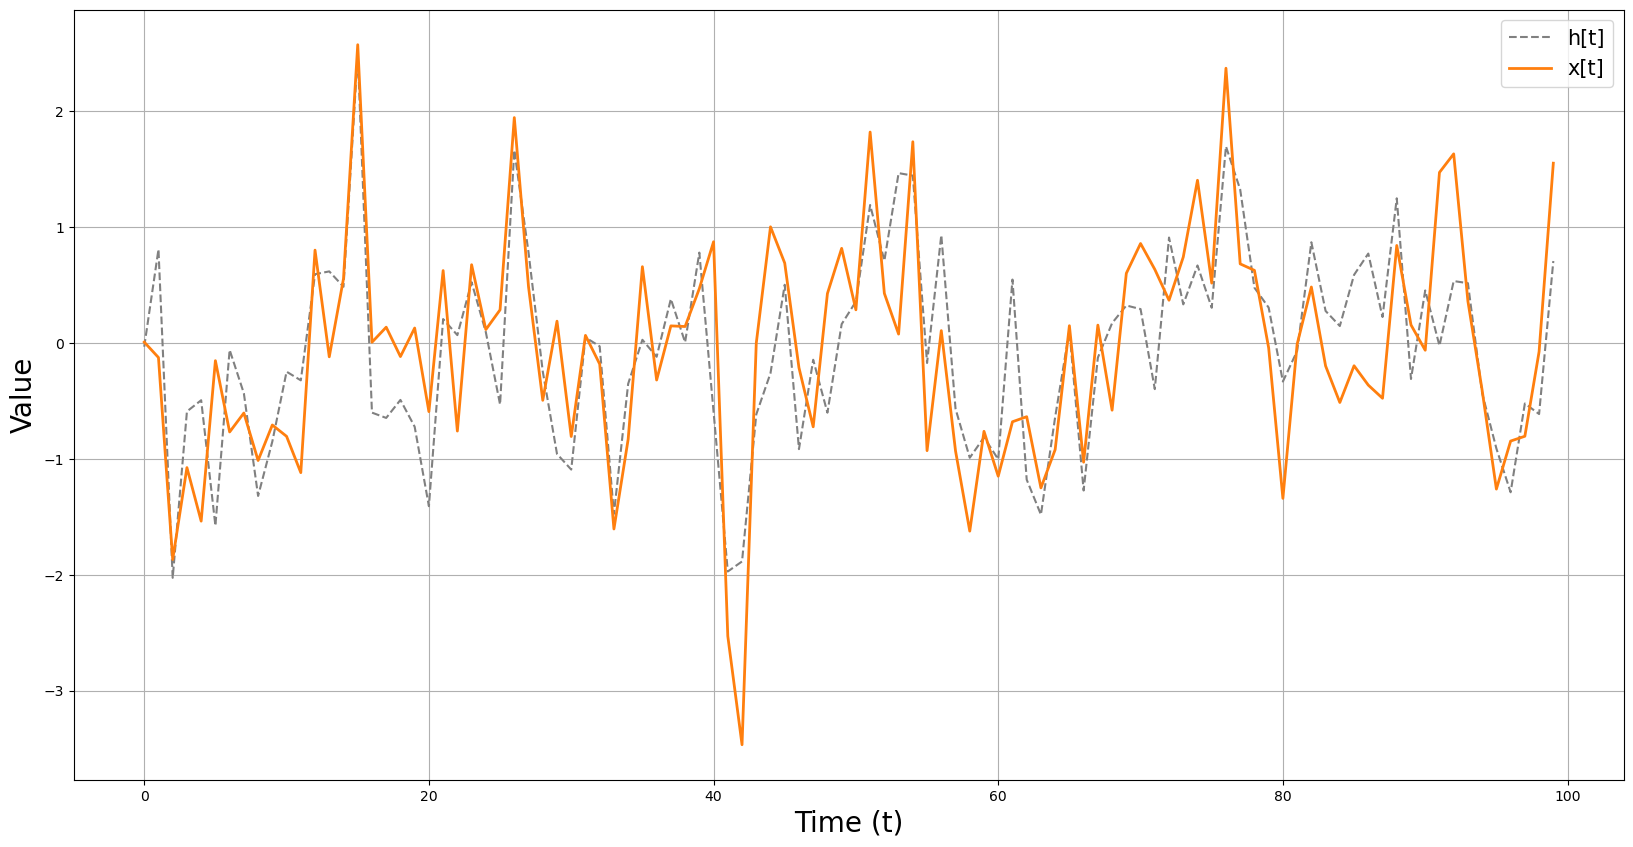

Mean: tensor([-0.0560]) ; Variance: tensor([0.9524])


In [9]:
plt.figure(figsize=(20, 10))
plt.plot(list(map(torch.ravel, h)), color="grey", linestyle="dashed", label="h[t]")
plt.plot(list(map(torch.ravel, x)), color="C1", label="x[t]", linewidth=2)
plt.legend(fontsize=15)
plt.xlabel("Time (t)", fontsize=20)
plt.ylabel("Value"   , fontsize=20)
plt.grid()
plt.show()

print("Mean:", torch.mean(torch.cat(x, dim=0), dim=0), "; Variance:", torch.var(torch.cat(x, dim=0), dim=0))

# Derivation of the log-likelihood

In [10]:
def negative_log_likelihood(x, a, b, c, eta, alpha, beta):
    
    # Initialisation
    mu_s     = zeros((len(beta), 1))
    sigma_s  = beta + b @ eta @ transpose(b)
    mu_ss    = zeros((len(alpha), 1))
    sigma_ss = eta
    
    L = logN(x[0], mu_s, sigma_s)
    
    # Recursion
    for s in range(1, len(x)):
        # Eq. 86        
        mu_s     = b @ (a @ mu_ss + c @ x[s-1])
        sigma_s  = beta + b @ (alpha + a @ sigma_ss @ transpose(a)) @ transpose(b)
        
        # Eq. 87
        mu_s1    = a @ mu_ss + c @ x[s-1]
        sigma_s1 = alpha + a @ sigma_ss @ transpose(a)
        
        # Eq. 88
        mu_ss    = mu_s1 + sigma_ss @ transpose(b) @ inv(sigma_s) @ (x[s] - mu_s)
        sigma_ss = sigma_s1 - sigma_ss @ transpose(b) @ inv(sigma_s) @ b @ sigma_ss
        
        L += logN(x[s], mu_s, sigma_s)
    
    return -L

In [11]:
# the generated suite of observation by the model itself
print(negative_log_likelihood(x, *gum.theta))

# an unlikely suite (constant, equal to 42)
print(negative_log_likelihood([tensor([[42]]) for _ in range(len(x))], *gum.theta))

tensor([[133.7517]])
tensor([[52848.3086]])


# Parameters estimation

In [12]:
from pprint import pprint
n = 1

unknown_gum = GUM(
    a     = tensor([[.3]]),
    b     = tensor([[.9]]),
    c     = tensor([[.1]]),
    eta   = tensor([[.7]]),
    alpha = tensor([[(1 - .3 ** 2 - 2 * .3 * .9 * .1) * .7 - .1 ** 2]]),
    beta  = tensor([[1 - .9 ** 2 * .7]])
)

a     = .1
b     = .9
c     = .1
eta   = .7


gum = GUM(
    a     = tensor([[a]]).requires_grad_(True),
    b     = tensor([[b]]).requires_grad_(True),
    c     = tensor([[c]]).requires_grad_(True),
    eta   = tensor([[eta]]).requires_grad_(True),
    alpha = tensor([[(1 - a**2 - 2 * a * b * c) * eta - c**2]]).requires_grad_(True),
    beta  = tensor([[1 - b**2 * eta]]).requires_grad_(True)
)

optimizer = torch.optim.Adam(gum.theta, lr=0.001)

losses = []

As = []
Bs = []

for _ in range(5000):
    print("\n>", _)
    # Generate sample from the unknown generator
    h, x = sample(unknown_gum, 100)
    
    optimizer.zero_grad()
    
    # Compute gradients (w.r.t. our model)
    losses.append(negative_log_likelihood(x, *gum.theta))
    losses[-1].backward()
     
    As.append(gum.F.detach().numpy().ravel().ravel())
    Bs.append((gum.H @ gum.N).detach().numpy().ravel().ravel())
    
    # Update model's parameters
    optimizer.step()
    
    pprint(gum.theta)
    print("Loss:", losses[-1])

As.append(gum.F.detach().numpy().ravel().ravel())
Bs.append((gum.H @ gum.N).detach().numpy().ravel().ravel())        
losses.append(negative_log_likelihood(x, *gum.theta))

> 0
(tensor([[0.0990]], requires_grad=True),
 tensor([[0.8990]], requires_grad=True),
 tensor([[0.0990]], requires_grad=True),
 tensor([[0.7010]], requires_grad=True),
 tensor([[0.6694]], requires_grad=True),
 tensor([[0.4320]], requires_grad=True))
Loss: tensor([[134.3080]], grad_fn=<NegBackward0>)

> 1
(tensor([[0.0996]], requires_grad=True),
 tensor([[0.8980]], requires_grad=True),
 tensor([[0.0997]], requires_grad=True),
 tensor([[0.7018]], requires_grad=True),
 tensor([[0.6684]], requires_grad=True),
 tensor([[0.4310]], requires_grad=True))
Loss: tensor([[133.8817]], grad_fn=<NegBackward0>)

> 2
(tensor([[0.1002]], requires_grad=True),
 tensor([[0.8975]], requires_grad=True),
 tensor([[0.1005]], requires_grad=True),
 tensor([[0.7026]], requires_grad=True),
 tensor([[0.6677]], requires_grad=True),
 tensor([[0.4304]], requires_grad=True))
Loss: tensor([[142.9596]], grad_fn=<NegBackward0>)

> 3
(tensor([[0.1009]], requires_grad=True),
 tensor([[0.8970]], requires_grad=True),
 tensor(

(tensor([[0.1224]], requires_grad=True),
 tensor([[0.8988]], requires_grad=True),
 tensor([[0.1236]], requires_grad=True),
 tensor([[0.7075]], requires_grad=True),
 tensor([[0.6646]], requires_grad=True),
 tensor([[0.4254]], requires_grad=True))
Loss: tensor([[143.6729]], grad_fn=<NegBackward0>)

> 29
(tensor([[0.1231]], requires_grad=True),
 tensor([[0.8988]], requires_grad=True),
 tensor([[0.1244]], requires_grad=True),
 tensor([[0.7071]], requires_grad=True),
 tensor([[0.6645]], requires_grad=True),
 tensor([[0.4252]], requires_grad=True))
Loss: tensor([[129.9431]], grad_fn=<NegBackward0>)

> 30
(tensor([[0.1239]], requires_grad=True),
 tensor([[0.8989]], requires_grad=True),
 tensor([[0.1252]], requires_grad=True),
 tensor([[0.7067]], requires_grad=True),
 tensor([[0.6645]], requires_grad=True),
 tensor([[0.4251]], requires_grad=True))
Loss: tensor([[147.2420]], grad_fn=<NegBackward0>)

> 31
(tensor([[0.1247]], requires_grad=True),
 tensor([[0.8991]], requires_grad=True),
 tensor([

(tensor([[0.1425]], requires_grad=True),
 tensor([[0.9023]], requires_grad=True),
 tensor([[0.1446]], requires_grad=True),
 tensor([[0.7047]], requires_grad=True),
 tensor([[0.6646]], requires_grad=True),
 tensor([[0.4228]], requires_grad=True))
Loss: tensor([[139.3586]], grad_fn=<NegBackward0>)

> 57
(tensor([[0.1431]], requires_grad=True),
 tensor([[0.9026]], requires_grad=True),
 tensor([[0.1452]], requires_grad=True),
 tensor([[0.7049]], requires_grad=True),
 tensor([[0.6647]], requires_grad=True),
 tensor([[0.4228]], requires_grad=True))
Loss: tensor([[140.7313]], grad_fn=<NegBackward0>)

> 58
(tensor([[0.1438]], requires_grad=True),
 tensor([[0.9028]], requires_grad=True),
 tensor([[0.1459]], requires_grad=True),
 tensor([[0.7051]], requires_grad=True),
 tensor([[0.6648]], requires_grad=True),
 tensor([[0.4229]], requires_grad=True))
Loss: tensor([[143.4045]], grad_fn=<NegBackward0>)

> 59
(tensor([[0.1443]], requires_grad=True),
 tensor([[0.9030]], requires_grad=True),
 tensor([

(tensor([[0.1539]], requires_grad=True),
 tensor([[0.9033]], requires_grad=True),
 tensor([[0.1569]], requires_grad=True),
 tensor([[0.7030]], requires_grad=True),
 tensor([[0.6630]], requires_grad=True),
 tensor([[0.4193]], requires_grad=True))
Loss: tensor([[148.8720]], grad_fn=<NegBackward0>)

> 85
(tensor([[0.1542]], requires_grad=True),
 tensor([[0.9036]], requires_grad=True),
 tensor([[0.1571]], requires_grad=True),
 tensor([[0.7031]], requires_grad=True),
 tensor([[0.6632]], requires_grad=True),
 tensor([[0.4195]], requires_grad=True))
Loss: tensor([[144.6470]], grad_fn=<NegBackward0>)

> 86
(tensor([[0.1545]], requires_grad=True),
 tensor([[0.9039]], requires_grad=True),
 tensor([[0.1574]], requires_grad=True),
 tensor([[0.7035]], requires_grad=True),
 tensor([[0.6635]], requires_grad=True),
 tensor([[0.4198]], requires_grad=True))
Loss: tensor([[145.3777]], grad_fn=<NegBackward0>)

> 87
(tensor([[0.1548]], requires_grad=True),
 tensor([[0.9040]], requires_grad=True),
 tensor([

(tensor([[0.1627]], requires_grad=True),
 tensor([[0.9017]], requires_grad=True),
 tensor([[0.1650]], requires_grad=True),
 tensor([[0.7019]], requires_grad=True),
 tensor([[0.6595]], requires_grad=True),
 tensor([[0.4150]], requires_grad=True))
Loss: tensor([[143.0869]], grad_fn=<NegBackward0>)

> 112
(tensor([[0.1628]], requires_grad=True),
 tensor([[0.9014]], requires_grad=True),
 tensor([[0.1652]], requires_grad=True),
 tensor([[0.7015]], requires_grad=True),
 tensor([[0.6591]], requires_grad=True),
 tensor([[0.4145]], requires_grad=True))
Loss: tensor([[122.4671]], grad_fn=<NegBackward0>)

> 113
(tensor([[0.1629]], requires_grad=True),
 tensor([[0.9012]], requires_grad=True),
 tensor([[0.1653]], requires_grad=True),
 tensor([[0.7010]], requires_grad=True),
 tensor([[0.6590]], requires_grad=True),
 tensor([[0.4143]], requires_grad=True))
Loss: tensor([[153.1118]], grad_fn=<NegBackward0>)

> 114
(tensor([[0.1629]], requires_grad=True),
 tensor([[0.9010]], requires_grad=True),
 tenso

(tensor([[0.1735]], requires_grad=True),
 tensor([[0.9008]], requires_grad=True),
 tensor([[0.1766]], requires_grad=True),
 tensor([[0.7044]], requires_grad=True),
 tensor([[0.6554]], requires_grad=True),
 tensor([[0.4092]], requires_grad=True))
Loss: tensor([[136.1043]], grad_fn=<NegBackward0>)

> 140
(tensor([[0.1738]], requires_grad=True),
 tensor([[0.9007]], requires_grad=True),
 tensor([[0.1770]], requires_grad=True),
 tensor([[0.7044]], requires_grad=True),
 tensor([[0.6551]], requires_grad=True),
 tensor([[0.4090]], requires_grad=True))
Loss: tensor([[132.0346]], grad_fn=<NegBackward0>)

> 141
(tensor([[0.1741]], requires_grad=True),
 tensor([[0.9005]], requires_grad=True),
 tensor([[0.1773]], requires_grad=True),
 tensor([[0.7043]], requires_grad=True),
 tensor([[0.6549]], requires_grad=True),
 tensor([[0.4086]], requires_grad=True))
Loss: tensor([[132.6380]], grad_fn=<NegBackward0>)

> 142
(tensor([[0.1743]], requires_grad=True),
 tensor([[0.9004]], requires_grad=True),
 tenso

(tensor([[0.1799]], requires_grad=True),
 tensor([[0.9011]], requires_grad=True),
 tensor([[0.1842]], requires_grad=True),
 tensor([[0.6992]], requires_grad=True),
 tensor([[0.6543]], requires_grad=True),
 tensor([[0.4066]], requires_grad=True))
Loss: tensor([[136.3075]], grad_fn=<NegBackward0>)

> 168
(tensor([[0.1801]], requires_grad=True),
 tensor([[0.9013]], requires_grad=True),
 tensor([[0.1844]], requires_grad=True),
 tensor([[0.6994]], requires_grad=True),
 tensor([[0.6543]], requires_grad=True),
 tensor([[0.4067]], requires_grad=True))
Loss: tensor([[148.5110]], grad_fn=<NegBackward0>)

> 169
(tensor([[0.1802]], requires_grad=True),
 tensor([[0.9013]], requires_grad=True),
 tensor([[0.1846]], requires_grad=True),
 tensor([[0.6996]], requires_grad=True),
 tensor([[0.6543]], requires_grad=True),
 tensor([[0.4067]], requires_grad=True))
Loss: tensor([[132.2484]], grad_fn=<NegBackward0>)

> 170
(tensor([[0.1802]], requires_grad=True),
 tensor([[0.9013]], requires_grad=True),
 tenso

(tensor([[0.1830]], requires_grad=True),
 tensor([[0.9011]], requires_grad=True),
 tensor([[0.1896]], requires_grad=True),
 tensor([[0.6958]], requires_grad=True),
 tensor([[0.6531]], requires_grad=True),
 tensor([[0.4045]], requires_grad=True))
Loss: tensor([[128.9921]], grad_fn=<NegBackward0>)

> 195
(tensor([[0.1830]], requires_grad=True),
 tensor([[0.9011]], requires_grad=True),
 tensor([[0.1896]], requires_grad=True),
 tensor([[0.6956]], requires_grad=True),
 tensor([[0.6531]], requires_grad=True),
 tensor([[0.4045]], requires_grad=True))
Loss: tensor([[145.3953]], grad_fn=<NegBackward0>)

> 196
(tensor([[0.1829]], requires_grad=True),
 tensor([[0.9011]], requires_grad=True),
 tensor([[0.1895]], requires_grad=True),
 tensor([[0.6954]], requires_grad=True),
 tensor([[0.6532]], requires_grad=True),
 tensor([[0.4045]], requires_grad=True))
Loss: tensor([[141.6539]], grad_fn=<NegBackward0>)

> 197
(tensor([[0.1829]], requires_grad=True),
 tensor([[0.9012]], requires_grad=True),
 tenso

(tensor([[0.1833]], requires_grad=True),
 tensor([[0.8973]], requires_grad=True),
 tensor([[0.1911]], requires_grad=True),
 tensor([[0.6899]], requires_grad=True),
 tensor([[0.6491]], requires_grad=True),
 tensor([[0.4000]], requires_grad=True))
Loss: tensor([[141.0353]], grad_fn=<NegBackward0>)

> 223
(tensor([[0.1836]], requires_grad=True),
 tensor([[0.8975]], requires_grad=True),
 tensor([[0.1913]], requires_grad=True),
 tensor([[0.6903]], requires_grad=True),
 tensor([[0.6492]], requires_grad=True),
 tensor([[0.4002]], requires_grad=True))
Loss: tensor([[139.4032]], grad_fn=<NegBackward0>)

> 224
(tensor([[0.1840]], requires_grad=True),
 tensor([[0.8977]], requires_grad=True),
 tensor([[0.1917]], requires_grad=True),
 tensor([[0.6905]], requires_grad=True),
 tensor([[0.6493]], requires_grad=True),
 tensor([[0.4002]], requires_grad=True))
Loss: tensor([[134.5617]], grad_fn=<NegBackward0>)

> 225
(tensor([[0.1844]], requires_grad=True),
 tensor([[0.8980]], requires_grad=True),
 tenso

(tensor([[0.1845]], requires_grad=True),
 tensor([[0.8971]], requires_grad=True),
 tensor([[0.1929]], requires_grad=True),
 tensor([[0.6892]], requires_grad=True),
 tensor([[0.6485]], requires_grad=True),
 tensor([[0.3991]], requires_grad=True))
Loss: tensor([[144.4274]], grad_fn=<NegBackward0>)

> 250
(tensor([[0.1842]], requires_grad=True),
 tensor([[0.8971]], requires_grad=True),
 tensor([[0.1925]], requires_grad=True),
 tensor([[0.6889]], requires_grad=True),
 tensor([[0.6486]], requires_grad=True),
 tensor([[0.3992]], requires_grad=True))
Loss: tensor([[133.8068]], grad_fn=<NegBackward0>)

> 251
(tensor([[0.1839]], requires_grad=True),
 tensor([[0.8971]], requires_grad=True),
 tensor([[0.1923]], requires_grad=True),
 tensor([[0.6886]], requires_grad=True),
 tensor([[0.6487]], requires_grad=True),
 tensor([[0.3993]], requires_grad=True))
Loss: tensor([[137.9821]], grad_fn=<NegBackward0>)

> 252
(tensor([[0.1837]], requires_grad=True),
 tensor([[0.8972]], requires_grad=True),
 tenso

(tensor([[0.1870]], requires_grad=True),
 tensor([[0.9006]], requires_grad=True),
 tensor([[0.1926]], requires_grad=True),
 tensor([[0.6853]], requires_grad=True),
 tensor([[0.6527]], requires_grad=True),
 tensor([[0.4030]], requires_grad=True))
Loss: tensor([[137.1088]], grad_fn=<NegBackward0>)

> 278
(tensor([[0.1869]], requires_grad=True),
 tensor([[0.9006]], requires_grad=True),
 tensor([[0.1924]], requires_grad=True),
 tensor([[0.6849]], requires_grad=True),
 tensor([[0.6528]], requires_grad=True),
 tensor([[0.4032]], requires_grad=True))
Loss: tensor([[141.9282]], grad_fn=<NegBackward0>)

> 279
(tensor([[0.1867]], requires_grad=True),
 tensor([[0.9006]], requires_grad=True),
 tensor([[0.1921]], requires_grad=True),
 tensor([[0.6846]], requires_grad=True),
 tensor([[0.6530]], requires_grad=True),
 tensor([[0.4034]], requires_grad=True))
Loss: tensor([[141.0502]], grad_fn=<NegBackward0>)

> 280
(tensor([[0.1864]], requires_grad=True),
 tensor([[0.9007]], requires_grad=True),
 tenso

(tensor([[0.1865]], requires_grad=True),
 tensor([[0.8998]], requires_grad=True),
 tensor([[0.1895]], requires_grad=True),
 tensor([[0.6815]], requires_grad=True),
 tensor([[0.6531]], requires_grad=True),
 tensor([[0.4042]], requires_grad=True))
Loss: tensor([[148.2042]], grad_fn=<NegBackward0>)

> 306
(tensor([[0.1866]], requires_grad=True),
 tensor([[0.8997]], requires_grad=True),
 tensor([[0.1897]], requires_grad=True),
 tensor([[0.6813]], requires_grad=True),
 tensor([[0.6530]], requires_grad=True),
 tensor([[0.4041]], requires_grad=True))
Loss: tensor([[132.0338]], grad_fn=<NegBackward0>)

> 307
(tensor([[0.1866]], requires_grad=True),
 tensor([[0.8996]], requires_grad=True),
 tensor([[0.1897]], requires_grad=True),
 tensor([[0.6810]], requires_grad=True),
 tensor([[0.6529]], requires_grad=True),
 tensor([[0.4039]], requires_grad=True))
Loss: tensor([[134.6949]], grad_fn=<NegBackward0>)

> 308
(tensor([[0.1867]], requires_grad=True),
 tensor([[0.8996]], requires_grad=True),
 tenso

(tensor([[0.1885]], requires_grad=True),
 tensor([[0.8953]], requires_grad=True),
 tensor([[0.1926]], requires_grad=True),
 tensor([[0.6839]], requires_grad=True),
 tensor([[0.6473]], requires_grad=True),
 tensor([[0.3984]], requires_grad=True))
Loss: tensor([[134.3714]], grad_fn=<NegBackward0>)

> 334
(tensor([[0.1886]], requires_grad=True),
 tensor([[0.8952]], requires_grad=True),
 tensor([[0.1927]], requires_grad=True),
 tensor([[0.6841]], requires_grad=True),
 tensor([[0.6471]], requires_grad=True),
 tensor([[0.3982]], requires_grad=True))
Loss: tensor([[136.3342]], grad_fn=<NegBackward0>)

> 335
(tensor([[0.1887]], requires_grad=True),
 tensor([[0.8951]], requires_grad=True),
 tensor([[0.1929]], requires_grad=True),
 tensor([[0.6842]], requires_grad=True),
 tensor([[0.6469]], requires_grad=True),
 tensor([[0.3979]], requires_grad=True))
Loss: tensor([[132.0842]], grad_fn=<NegBackward0>)

> 336
(tensor([[0.1888]], requires_grad=True),
 tensor([[0.8950]], requires_grad=True),
 tenso

(tensor([[0.1862]], requires_grad=True),
 tensor([[0.8915]], requires_grad=True),
 tensor([[0.1907]], requires_grad=True),
 tensor([[0.6809]], requires_grad=True),
 tensor([[0.6441]], requires_grad=True),
 tensor([[0.3956]], requires_grad=True))
Loss: tensor([[138.7288]], grad_fn=<NegBackward0>)

> 362
(tensor([[0.1862]], requires_grad=True),
 tensor([[0.8911]], requires_grad=True),
 tensor([[0.1907]], requires_grad=True),
 tensor([[0.6810]], requires_grad=True),
 tensor([[0.6436]], requires_grad=True),
 tensor([[0.3950]], requires_grad=True))
Loss: tensor([[124.7988]], grad_fn=<NegBackward0>)

> 363
(tensor([[0.1861]], requires_grad=True),
 tensor([[0.8907]], requires_grad=True),
 tensor([[0.1907]], requires_grad=True),
 tensor([[0.6810]], requires_grad=True),
 tensor([[0.6432]], requires_grad=True),
 tensor([[0.3946]], requires_grad=True))
Loss: tensor([[142.3535]], grad_fn=<NegBackward0>)

> 364
(tensor([[0.1860]], requires_grad=True),
 tensor([[0.8902]], requires_grad=True),
 tenso

(tensor([[0.1914]], requires_grad=True),
 tensor([[0.8963]], requires_grad=True),
 tensor([[0.1949]], requires_grad=True),
 tensor([[0.6772]], requires_grad=True),
 tensor([[0.6485]], requires_grad=True),
 tensor([[0.3991]], requires_grad=True))
Loss: tensor([[131.2479]], grad_fn=<NegBackward0>)

> 390
(tensor([[0.1916]], requires_grad=True),
 tensor([[0.8967]], requires_grad=True),
 tensor([[0.1950]], requires_grad=True),
 tensor([[0.6773]], requires_grad=True),
 tensor([[0.6488]], requires_grad=True),
 tensor([[0.3995]], requires_grad=True))
Loss: tensor([[134.8437]], grad_fn=<NegBackward0>)

> 391
(tensor([[0.1917]], requires_grad=True),
 tensor([[0.8969]], requires_grad=True),
 tensor([[0.1951]], requires_grad=True),
 tensor([[0.6774]], requires_grad=True),
 tensor([[0.6490]], requires_grad=True),
 tensor([[0.3996]], requires_grad=True))
Loss: tensor([[128.1699]], grad_fn=<NegBackward0>)

> 392
(tensor([[0.1919]], requires_grad=True),
 tensor([[0.8971]], requires_grad=True),
 tenso

(tensor([[0.1957]], requires_grad=True),
 tensor([[0.9017]], requires_grad=True),
 tensor([[0.2000]], requires_grad=True),
 tensor([[0.6759]], requires_grad=True),
 tensor([[0.6530]], requires_grad=True),
 tensor([[0.4028]], requires_grad=True))
Loss: tensor([[140.3888]], grad_fn=<NegBackward0>)

> 418
(tensor([[0.1958]], requires_grad=True),
 tensor([[0.9019]], requires_grad=True),
 tensor([[0.2001]], requires_grad=True),
 tensor([[0.6758]], requires_grad=True),
 tensor([[0.6533]], requires_grad=True),
 tensor([[0.4030]], requires_grad=True))
Loss: tensor([[130.9665]], grad_fn=<NegBackward0>)

> 419
(tensor([[0.1958]], requires_grad=True),
 tensor([[0.9020]], requires_grad=True),
 tensor([[0.2002]], requires_grad=True),
 tensor([[0.6757]], requires_grad=True),
 tensor([[0.6533]], requires_grad=True),
 tensor([[0.4030]], requires_grad=True))
Loss: tensor([[124.5459]], grad_fn=<NegBackward0>)

> 420
(tensor([[0.1957]], requires_grad=True),
 tensor([[0.9020]], requires_grad=True),
 tenso

(tensor([[0.1905]], requires_grad=True),
 tensor([[0.8969]], requires_grad=True),
 tensor([[0.1963]], requires_grad=True),
 tensor([[0.6754]], requires_grad=True),
 tensor([[0.6490]], requires_grad=True),
 tensor([[0.3998]], requires_grad=True))
Loss: tensor([[146.1197]], grad_fn=<NegBackward0>)

> 445
(tensor([[0.1907]], requires_grad=True),
 tensor([[0.8969]], requires_grad=True),
 tensor([[0.1965]], requires_grad=True),
 tensor([[0.6755]], requires_grad=True),
 tensor([[0.6489]], requires_grad=True),
 tensor([[0.3996]], requires_grad=True))
Loss: tensor([[137.8378]], grad_fn=<NegBackward0>)

> 446
(tensor([[0.1909]], requires_grad=True),
 tensor([[0.8969]], requires_grad=True),
 tensor([[0.1966]], requires_grad=True),
 tensor([[0.6757]], requires_grad=True),
 tensor([[0.6488]], requires_grad=True),
 tensor([[0.3996]], requires_grad=True))
Loss: tensor([[143.3036]], grad_fn=<NegBackward0>)

> 447
(tensor([[0.1910]], requires_grad=True),
 tensor([[0.8968]], requires_grad=True),
 tenso

(tensor([[0.1914]], requires_grad=True),
 tensor([[0.8976]], requires_grad=True),
 tensor([[0.1957]], requires_grad=True),
 tensor([[0.6756]], requires_grad=True),
 tensor([[0.6499]], requires_grad=True),
 tensor([[0.4011]], requires_grad=True))
Loss: tensor([[137.7478]], grad_fn=<NegBackward0>)

> 472
(tensor([[0.1913]], requires_grad=True),
 tensor([[0.8973]], requires_grad=True),
 tensor([[0.1956]], requires_grad=True),
 tensor([[0.6753]], requires_grad=True),
 tensor([[0.6496]], requires_grad=True),
 tensor([[0.4008]], requires_grad=True))
Loss: tensor([[140.4883]], grad_fn=<NegBackward0>)

> 473
(tensor([[0.1912]], requires_grad=True),
 tensor([[0.8968]], requires_grad=True),
 tensor([[0.1956]], requires_grad=True),
 tensor([[0.6752]], requires_grad=True),
 tensor([[0.6491]], requires_grad=True),
 tensor([[0.4003]], requires_grad=True))
Loss: tensor([[126.2148]], grad_fn=<NegBackward0>)

> 474
(tensor([[0.1909]], requires_grad=True),
 tensor([[0.8962]], requires_grad=True),
 tenso

(tensor([[0.1885]], requires_grad=True),
 tensor([[0.8915]], requires_grad=True),
 tensor([[0.1948]], requires_grad=True),
 tensor([[0.6712]], requires_grad=True),
 tensor([[0.6440]], requires_grad=True),
 tensor([[0.3956]], requires_grad=True))
Loss: tensor([[131.0920]], grad_fn=<NegBackward0>)

> 500
(tensor([[0.1885]], requires_grad=True),
 tensor([[0.8914]], requires_grad=True),
 tensor([[0.1947]], requires_grad=True),
 tensor([[0.6716]], requires_grad=True),
 tensor([[0.6439]], requires_grad=True),
 tensor([[0.3955]], requires_grad=True))
Loss: tensor([[146.0071]], grad_fn=<NegBackward0>)

> 501
(tensor([[0.1886]], requires_grad=True),
 tensor([[0.8915]], requires_grad=True),
 tensor([[0.1948]], requires_grad=True),
 tensor([[0.6720]], requires_grad=True),
 tensor([[0.6440]], requires_grad=True),
 tensor([[0.3957]], requires_grad=True))
Loss: tensor([[153.0376]], grad_fn=<NegBackward0>)

> 502
(tensor([[0.1888]], requires_grad=True),
 tensor([[0.8917]], requires_grad=True),
 tenso

(tensor([[0.1901]], requires_grad=True),
 tensor([[0.8929]], requires_grad=True),
 tensor([[0.1938]], requires_grad=True),
 tensor([[0.6695]], requires_grad=True),
 tensor([[0.6460]], requires_grad=True),
 tensor([[0.3982]], requires_grad=True))
Loss: tensor([[151.8126]], grad_fn=<NegBackward0>)

> 528
(tensor([[0.1901]], requires_grad=True),
 tensor([[0.8931]], requires_grad=True),
 tensor([[0.1937]], requires_grad=True),
 tensor([[0.6691]], requires_grad=True),
 tensor([[0.6463]], requires_grad=True),
 tensor([[0.3984]], requires_grad=True))
Loss: tensor([[142.9310]], grad_fn=<NegBackward0>)

> 529
(tensor([[0.1903]], requires_grad=True),
 tensor([[0.8933]], requires_grad=True),
 tensor([[0.1938]], requires_grad=True),
 tensor([[0.6686]], requires_grad=True),
 tensor([[0.6465]], requires_grad=True),
 tensor([[0.3986]], requires_grad=True))
Loss: tensor([[140.5315]], grad_fn=<NegBackward0>)

> 530
(tensor([[0.1906]], requires_grad=True),
 tensor([[0.8936]], requires_grad=True),
 tenso

(tensor([[0.1920]], requires_grad=True),
 tensor([[0.8935]], requires_grad=True),
 tensor([[0.1953]], requires_grad=True),
 tensor([[0.6619]], requires_grad=True),
 tensor([[0.6470]], requires_grad=True),
 tensor([[0.3985]], requires_grad=True))
Loss: tensor([[139.2084]], grad_fn=<NegBackward0>)

> 556
(tensor([[0.1920]], requires_grad=True),
 tensor([[0.8935]], requires_grad=True),
 tensor([[0.1953]], requires_grad=True),
 tensor([[0.6616]], requires_grad=True),
 tensor([[0.6471]], requires_grad=True),
 tensor([[0.3984]], requires_grad=True))
Loss: tensor([[140.1270]], grad_fn=<NegBackward0>)

> 557
(tensor([[0.1918]], requires_grad=True),
 tensor([[0.8934]], requires_grad=True),
 tensor([[0.1952]], requires_grad=True),
 tensor([[0.6613]], requires_grad=True),
 tensor([[0.6470]], requires_grad=True),
 tensor([[0.3984]], requires_grad=True))
Loss: tensor([[133.6465]], grad_fn=<NegBackward0>)

> 558
(tensor([[0.1916]], requires_grad=True),
 tensor([[0.8934]], requires_grad=True),
 tenso

(tensor([[0.1878]], requires_grad=True),
 tensor([[0.8939]], requires_grad=True),
 tensor([[0.1913]], requires_grad=True),
 tensor([[0.6570]], requires_grad=True),
 tensor([[0.6489]], requires_grad=True),
 tensor([[0.4009]], requires_grad=True))
Loss: tensor([[150.8145]], grad_fn=<NegBackward0>)

> 583
(tensor([[0.1876]], requires_grad=True),
 tensor([[0.8937]], requires_grad=True),
 tensor([[0.1912]], requires_grad=True),
 tensor([[0.6572]], requires_grad=True),
 tensor([[0.6487]], requires_grad=True),
 tensor([[0.4008]], requires_grad=True))
Loss: tensor([[122.2077]], grad_fn=<NegBackward0>)

> 584
(tensor([[0.1876]], requires_grad=True),
 tensor([[0.8935]], requires_grad=True),
 tensor([[0.1912]], requires_grad=True),
 tensor([[0.6572]], requires_grad=True),
 tensor([[0.6485]], requires_grad=True),
 tensor([[0.4005]], requires_grad=True))
Loss: tensor([[130.6117]], grad_fn=<NegBackward0>)

> 585
(tensor([[0.1875]], requires_grad=True),
 tensor([[0.8933]], requires_grad=True),
 tenso

(tensor([[0.1847]], requires_grad=True),
 tensor([[0.8887]], requires_grad=True),
 tensor([[0.1900]], requires_grad=True),
 tensor([[0.6594]], requires_grad=True),
 tensor([[0.6435]], requires_grad=True),
 tensor([[0.3961]], requires_grad=True))
Loss: tensor([[145.0068]], grad_fn=<NegBackward0>)

> 611
(tensor([[0.1845]], requires_grad=True),
 tensor([[0.8887]], requires_grad=True),
 tensor([[0.1898]], requires_grad=True),
 tensor([[0.6594]], requires_grad=True),
 tensor([[0.6435]], requires_grad=True),
 tensor([[0.3962]], requires_grad=True))
Loss: tensor([[128.1573]], grad_fn=<NegBackward0>)

> 612
(tensor([[0.1843]], requires_grad=True),
 tensor([[0.8886]], requires_grad=True),
 tensor([[0.1896]], requires_grad=True),
 tensor([[0.6594]], requires_grad=True),
 tensor([[0.6434]], requires_grad=True),
 tensor([[0.3962]], requires_grad=True))
Loss: tensor([[130.4746]], grad_fn=<NegBackward0>)

> 613
(tensor([[0.1840]], requires_grad=True),
 tensor([[0.8884]], requires_grad=True),
 tenso

(tensor([[0.1824]], requires_grad=True),
 tensor([[0.8857]], requires_grad=True),
 tensor([[0.1853]], requires_grad=True),
 tensor([[0.6646]], requires_grad=True),
 tensor([[0.6409]], requires_grad=True),
 tensor([[0.3950]], requires_grad=True))
Loss: tensor([[140.3685]], grad_fn=<NegBackward0>)

> 639
(tensor([[0.1825]], requires_grad=True),
 tensor([[0.8858]], requires_grad=True),
 tensor([[0.1853]], requires_grad=True),
 tensor([[0.6644]], requires_grad=True),
 tensor([[0.6411]], requires_grad=True),
 tensor([[0.3952]], requires_grad=True))
Loss: tensor([[145.6581]], grad_fn=<NegBackward0>)

> 640
(tensor([[0.1827]], requires_grad=True),
 tensor([[0.8860]], requires_grad=True),
 tensor([[0.1852]], requires_grad=True),
 tensor([[0.6642]], requires_grad=True),
 tensor([[0.6413]], requires_grad=True),
 tensor([[0.3954]], requires_grad=True))
Loss: tensor([[139.5728]], grad_fn=<NegBackward0>)

> 641
(tensor([[0.1828]], requires_grad=True),
 tensor([[0.8860]], requires_grad=True),
 tenso

(tensor([[0.1845]], requires_grad=True),
 tensor([[0.8879]], requires_grad=True),
 tensor([[0.1850]], requires_grad=True),
 tensor([[0.6633]], requires_grad=True),
 tensor([[0.6434]], requires_grad=True),
 tensor([[0.3978]], requires_grad=True))
Loss: tensor([[133.2212]], grad_fn=<NegBackward0>)

> 667
(tensor([[0.1844]], requires_grad=True),
 tensor([[0.8880]], requires_grad=True),
 tensor([[0.1849]], requires_grad=True),
 tensor([[0.6632]], requires_grad=True),
 tensor([[0.6436]], requires_grad=True),
 tensor([[0.3980]], requires_grad=True))
Loss: tensor([[136.4203]], grad_fn=<NegBackward0>)

> 668
(tensor([[0.1845]], requires_grad=True),
 tensor([[0.8881]], requires_grad=True),
 tensor([[0.1849]], requires_grad=True),
 tensor([[0.6630]], requires_grad=True),
 tensor([[0.6437]], requires_grad=True),
 tensor([[0.3981]], requires_grad=True))
Loss: tensor([[131.8005]], grad_fn=<NegBackward0>)

> 669
(tensor([[0.1846]], requires_grad=True),
 tensor([[0.8882]], requires_grad=True),
 tenso

(tensor([[0.1861]], requires_grad=True),
 tensor([[0.8927]], requires_grad=True),
 tensor([[0.1840]], requires_grad=True),
 tensor([[0.6601]], requires_grad=True),
 tensor([[0.6490]], requires_grad=True),
 tensor([[0.4038]], requires_grad=True))
Loss: tensor([[142.9888]], grad_fn=<NegBackward0>)

> 695
(tensor([[0.1862]], requires_grad=True),
 tensor([[0.8927]], requires_grad=True),
 tensor([[0.1839]], requires_grad=True),
 tensor([[0.6598]], requires_grad=True),
 tensor([[0.6491]], requires_grad=True),
 tensor([[0.4039]], requires_grad=True))
Loss: tensor([[132.6045]], grad_fn=<NegBackward0>)

> 696
(tensor([[0.1864]], requires_grad=True),
 tensor([[0.8928]], requires_grad=True),
 tensor([[0.1841]], requires_grad=True),
 tensor([[0.6594]], requires_grad=True),
 tensor([[0.6491]], requires_grad=True),
 tensor([[0.4039]], requires_grad=True))
Loss: tensor([[134.4431]], grad_fn=<NegBackward0>)

> 697
(tensor([[0.1868]], requires_grad=True),
 tensor([[0.8928]], requires_grad=True),
 tenso

(tensor([[0.1911]], requires_grad=True),
 tensor([[0.8884]], requires_grad=True),
 tensor([[0.1894]], requires_grad=True),
 tensor([[0.6549]], requires_grad=True),
 tensor([[0.6438]], requires_grad=True),
 tensor([[0.3974]], requires_grad=True))
Loss: tensor([[143.9856]], grad_fn=<NegBackward0>)

> 723
(tensor([[0.1913]], requires_grad=True),
 tensor([[0.8885]], requires_grad=True),
 tensor([[0.1895]], requires_grad=True),
 tensor([[0.6549]], requires_grad=True),
 tensor([[0.6439]], requires_grad=True),
 tensor([[0.3974]], requires_grad=True))
Loss: tensor([[143.9380]], grad_fn=<NegBackward0>)

> 724
(tensor([[0.1914]], requires_grad=True),
 tensor([[0.8887]], requires_grad=True),
 tensor([[0.1895]], requires_grad=True),
 tensor([[0.6549]], requires_grad=True),
 tensor([[0.6441]], requires_grad=True),
 tensor([[0.3976]], requires_grad=True))
Loss: tensor([[141.5636]], grad_fn=<NegBackward0>)

> 725
(tensor([[0.1915]], requires_grad=True),
 tensor([[0.8888]], requires_grad=True),
 tenso

(tensor([[0.1913]], requires_grad=True),
 tensor([[0.8904]], requires_grad=True),
 tensor([[0.1884]], requires_grad=True),
 tensor([[0.6499]], requires_grad=True),
 tensor([[0.6466]], requires_grad=True),
 tensor([[0.4000]], requires_grad=True))
Loss: tensor([[137.0388]], grad_fn=<NegBackward0>)

> 751
(tensor([[0.1911]], requires_grad=True),
 tensor([[0.8902]], requires_grad=True),
 tensor([[0.1881]], requires_grad=True),
 tensor([[0.6495]], requires_grad=True),
 tensor([[0.6465]], requires_grad=True),
 tensor([[0.4000]], requires_grad=True))
Loss: tensor([[132.7378]], grad_fn=<NegBackward0>)

> 752
(tensor([[0.1909]], requires_grad=True),
 tensor([[0.8901]], requires_grad=True),
 tensor([[0.1878]], requires_grad=True),
 tensor([[0.6491]], requires_grad=True),
 tensor([[0.6465]], requires_grad=True),
 tensor([[0.4000]], requires_grad=True))
Loss: tensor([[141.4886]], grad_fn=<NegBackward0>)

> 753
(tensor([[0.1908]], requires_grad=True),
 tensor([[0.8901]], requires_grad=True),
 tenso

(tensor([[0.1942]], requires_grad=True),
 tensor([[0.8915]], requires_grad=True),
 tensor([[0.1902]], requires_grad=True),
 tensor([[0.6433]], requires_grad=True),
 tensor([[0.6480]], requires_grad=True),
 tensor([[0.4008]], requires_grad=True))
Loss: tensor([[134.8324]], grad_fn=<NegBackward0>)

> 779
(tensor([[0.1943]], requires_grad=True),
 tensor([[0.8913]], requires_grad=True),
 tensor([[0.1904]], requires_grad=True),
 tensor([[0.6431]], requires_grad=True),
 tensor([[0.6478]], requires_grad=True),
 tensor([[0.4006]], requires_grad=True))
Loss: tensor([[127.1447]], grad_fn=<NegBackward0>)

> 780
(tensor([[0.1947]], requires_grad=True),
 tensor([[0.8911]], requires_grad=True),
 tensor([[0.1907]], requires_grad=True),
 tensor([[0.6429]], requires_grad=True),
 tensor([[0.6475]], requires_grad=True),
 tensor([[0.4003]], requires_grad=True))
Loss: tensor([[127.9602]], grad_fn=<NegBackward0>)

> 781
(tensor([[0.1949]], requires_grad=True),
 tensor([[0.8909]], requires_grad=True),
 tenso

(tensor([[0.1987]], requires_grad=True),
 tensor([[0.8894]], requires_grad=True),
 tensor([[0.1931]], requires_grad=True),
 tensor([[0.6390]], requires_grad=True),
 tensor([[0.6456]], requires_grad=True),
 tensor([[0.3978]], requires_grad=True))
Loss: tensor([[132.2206]], grad_fn=<NegBackward0>)

> 807
(tensor([[0.1990]], requires_grad=True),
 tensor([[0.8895]], requires_grad=True),
 tensor([[0.1933]], requires_grad=True),
 tensor([[0.6393]], requires_grad=True),
 tensor([[0.6456]], requires_grad=True),
 tensor([[0.3979]], requires_grad=True))
Loss: tensor([[134.5224]], grad_fn=<NegBackward0>)

> 808
(tensor([[0.1993]], requires_grad=True),
 tensor([[0.8896]], requires_grad=True),
 tensor([[0.1934]], requires_grad=True),
 tensor([[0.6396]], requires_grad=True),
 tensor([[0.6456]], requires_grad=True),
 tensor([[0.3979]], requires_grad=True))
Loss: tensor([[131.9464]], grad_fn=<NegBackward0>)

> 809
(tensor([[0.1996]], requires_grad=True),
 tensor([[0.8896]], requires_grad=True),
 tenso

(tensor([[0.2059]], requires_grad=True),
 tensor([[0.8904]], requires_grad=True),
 tensor([[0.1967]], requires_grad=True),
 tensor([[0.6434]], requires_grad=True),
 tensor([[0.6454]], requires_grad=True),
 tensor([[0.3984]], requires_grad=True))
Loss: tensor([[136.9747]], grad_fn=<NegBackward0>)

> 835
(tensor([[0.2061]], requires_grad=True),
 tensor([[0.8905]], requires_grad=True),
 tensor([[0.1968]], requires_grad=True),
 tensor([[0.6435]], requires_grad=True),
 tensor([[0.6454]], requires_grad=True),
 tensor([[0.3985]], requires_grad=True))
Loss: tensor([[129.4267]], grad_fn=<NegBackward0>)

> 836
(tensor([[0.2063]], requires_grad=True),
 tensor([[0.8906]], requires_grad=True),
 tensor([[0.1970]], requires_grad=True),
 tensor([[0.6435]], requires_grad=True),
 tensor([[0.6455]], requires_grad=True),
 tensor([[0.3985]], requires_grad=True))
Loss: tensor([[142.0364]], grad_fn=<NegBackward0>)

> 837
(tensor([[0.2064]], requires_grad=True),
 tensor([[0.8907]], requires_grad=True),
 tenso

(tensor([[0.2045]], requires_grad=True),
 tensor([[0.8915]], requires_grad=True),
 tensor([[0.1939]], requires_grad=True),
 tensor([[0.6430]], requires_grad=True),
 tensor([[0.6472]], requires_grad=True),
 tensor([[0.4010]], requires_grad=True))
Loss: tensor([[139.9442]], grad_fn=<NegBackward0>)

> 863
(tensor([[0.2045]], requires_grad=True),
 tensor([[0.8915]], requires_grad=True),
 tensor([[0.1938]], requires_grad=True),
 tensor([[0.6430]], requires_grad=True),
 tensor([[0.6472]], requires_grad=True),
 tensor([[0.4011]], requires_grad=True))
Loss: tensor([[148.1155]], grad_fn=<NegBackward0>)

> 864
(tensor([[0.2046]], requires_grad=True),
 tensor([[0.8916]], requires_grad=True),
 tensor([[0.1939]], requires_grad=True),
 tensor([[0.6430]], requires_grad=True),
 tensor([[0.6473]], requires_grad=True),
 tensor([[0.4011]], requires_grad=True))
Loss: tensor([[141.4794]], grad_fn=<NegBackward0>)

> 865
(tensor([[0.2047]], requires_grad=True),
 tensor([[0.8915]], requires_grad=True),
 tenso

(tensor([[0.1991]], requires_grad=True),
 tensor([[0.8899]], requires_grad=True),
 tensor([[0.1892]], requires_grad=True),
 tensor([[0.6467]], requires_grad=True),
 tensor([[0.6463]], requires_grad=True),
 tensor([[0.4008]], requires_grad=True))
Loss: tensor([[140.2090]], grad_fn=<NegBackward0>)

> 891
(tensor([[0.1991]], requires_grad=True),
 tensor([[0.8897]], requires_grad=True),
 tensor([[0.1893]], requires_grad=True),
 tensor([[0.6467]], requires_grad=True),
 tensor([[0.6460]], requires_grad=True),
 tensor([[0.4005]], requires_grad=True))
Loss: tensor([[132.3990]], grad_fn=<NegBackward0>)

> 892
(tensor([[0.1990]], requires_grad=True),
 tensor([[0.8895]], requires_grad=True),
 tensor([[0.1893]], requires_grad=True),
 tensor([[0.6467]], requires_grad=True),
 tensor([[0.6458]], requires_grad=True),
 tensor([[0.4003]], requires_grad=True))
Loss: tensor([[138.4021]], grad_fn=<NegBackward0>)

> 893
(tensor([[0.1990]], requires_grad=True),
 tensor([[0.8892]], requires_grad=True),
 tenso

(tensor([[0.2020]], requires_grad=True),
 tensor([[0.8882]], requires_grad=True),
 tensor([[0.1930]], requires_grad=True),
 tensor([[0.6550]], requires_grad=True),
 tensor([[0.6428]], requires_grad=True),
 tensor([[0.3976]], requires_grad=True))
Loss: tensor([[154.2706]], grad_fn=<NegBackward0>)

> 919
(tensor([[0.2021]], requires_grad=True),
 tensor([[0.8885]], requires_grad=True),
 tensor([[0.1931]], requires_grad=True),
 tensor([[0.6551]], requires_grad=True),
 tensor([[0.6430]], requires_grad=True),
 tensor([[0.3979]], requires_grad=True))
Loss: tensor([[155.1893]], grad_fn=<NegBackward0>)

> 920
(tensor([[0.2021]], requires_grad=True),
 tensor([[0.8886]], requires_grad=True),
 tensor([[0.1932]], requires_grad=True),
 tensor([[0.6552]], requires_grad=True),
 tensor([[0.6431]], requires_grad=True),
 tensor([[0.3979]], requires_grad=True))
Loss: tensor([[125.5779]], grad_fn=<NegBackward0>)

> 921
(tensor([[0.2021]], requires_grad=True),
 tensor([[0.8886]], requires_grad=True),
 tenso

(tensor([[0.2048]], requires_grad=True),
 tensor([[0.8886]], requires_grad=True),
 tensor([[0.1970]], requires_grad=True),
 tensor([[0.6590]], requires_grad=True),
 tensor([[0.6419]], requires_grad=True),
 tensor([[0.3962]], requires_grad=True))
Loss: tensor([[141.2449]], grad_fn=<NegBackward0>)

> 947
(tensor([[0.2044]], requires_grad=True),
 tensor([[0.8882]], requires_grad=True),
 tensor([[0.1967]], requires_grad=True),
 tensor([[0.6590]], requires_grad=True),
 tensor([[0.6415]], requires_grad=True),
 tensor([[0.3958]], requires_grad=True))
Loss: tensor([[130.6041]], grad_fn=<NegBackward0>)

> 948
(tensor([[0.2041]], requires_grad=True),
 tensor([[0.8878]], requires_grad=True),
 tensor([[0.1965]], requires_grad=True),
 tensor([[0.6590]], requires_grad=True),
 tensor([[0.6411]], requires_grad=True),
 tensor([[0.3955]], requires_grad=True))
Loss: tensor([[131.2833]], grad_fn=<NegBackward0>)

> 949
(tensor([[0.2037]], requires_grad=True),
 tensor([[0.8874]], requires_grad=True),
 tenso

(tensor([[0.2082]], requires_grad=True),
 tensor([[0.8834]], requires_grad=True),
 tensor([[0.2001]], requires_grad=True),
 tensor([[0.6564]], requires_grad=True),
 tensor([[0.6359]], requires_grad=True),
 tensor([[0.3898]], requires_grad=True))
Loss: tensor([[133.6621]], grad_fn=<NegBackward0>)

> 975
(tensor([[0.2087]], requires_grad=True),
 tensor([[0.8835]], requires_grad=True),
 tensor([[0.2005]], requires_grad=True),
 tensor([[0.6564]], requires_grad=True),
 tensor([[0.6359]], requires_grad=True),
 tensor([[0.3898]], requires_grad=True))
Loss: tensor([[150.5133]], grad_fn=<NegBackward0>)

> 976
(tensor([[0.2092]], requires_grad=True),
 tensor([[0.8837]], requires_grad=True),
 tensor([[0.2009]], requires_grad=True),
 tensor([[0.6562]], requires_grad=True),
 tensor([[0.6360]], requires_grad=True),
 tensor([[0.3898]], requires_grad=True))
Loss: tensor([[139.3632]], grad_fn=<NegBackward0>)

> 977
(tensor([[0.2095]], requires_grad=True),
 tensor([[0.8839]], requires_grad=True),
 tenso

(tensor([[0.2093]], requires_grad=True),
 tensor([[0.8905]], requires_grad=True),
 tensor([[0.1980]], requires_grad=True),
 tensor([[0.6577]], requires_grad=True),
 tensor([[0.6438]], requires_grad=True),
 tensor([[0.3984]], requires_grad=True))
Loss: tensor([[139.8552]], grad_fn=<NegBackward0>)

> 1003
(tensor([[0.2091]], requires_grad=True),
 tensor([[0.8906]], requires_grad=True),
 tensor([[0.1978]], requires_grad=True),
 tensor([[0.6578]], requires_grad=True),
 tensor([[0.6439]], requires_grad=True),
 tensor([[0.3985]], requires_grad=True))
Loss: tensor([[131.8141]], grad_fn=<NegBackward0>)

> 1004
(tensor([[0.2089]], requires_grad=True),
 tensor([[0.8904]], requires_grad=True),
 tensor([[0.1975]], requires_grad=True),
 tensor([[0.6580]], requires_grad=True),
 tensor([[0.6439]], requires_grad=True),
 tensor([[0.3986]], requires_grad=True))
Loss: tensor([[127.9831]], grad_fn=<NegBackward0>)

> 1005
(tensor([[0.2085]], requires_grad=True),
 tensor([[0.8903]], requires_grad=True),
 te

(tensor([[0.2018]], requires_grad=True),
 tensor([[0.8842]], requires_grad=True),
 tensor([[0.1911]], requires_grad=True),
 tensor([[0.6637]], requires_grad=True),
 tensor([[0.6382]], requires_grad=True),
 tensor([[0.3945]], requires_grad=True))
Loss: tensor([[125.5677]], grad_fn=<NegBackward0>)

> 1030
(tensor([[0.2017]], requires_grad=True),
 tensor([[0.8839]], requires_grad=True),
 tensor([[0.1910]], requires_grad=True),
 tensor([[0.6639]], requires_grad=True),
 tensor([[0.6379]], requires_grad=True),
 tensor([[0.3942]], requires_grad=True))
Loss: tensor([[141.4652]], grad_fn=<NegBackward0>)

> 1031
(tensor([[0.2016]], requires_grad=True),
 tensor([[0.8837]], requires_grad=True),
 tensor([[0.1910]], requires_grad=True),
 tensor([[0.6641]], requires_grad=True),
 tensor([[0.6377]], requires_grad=True),
 tensor([[0.3940]], requires_grad=True))
Loss: tensor([[141.1354]], grad_fn=<NegBackward0>)

> 1032
(tensor([[0.2015]], requires_grad=True),
 tensor([[0.8835]], requires_grad=True),
 te

(tensor([[0.1996]], requires_grad=True),
 tensor([[0.8842]], requires_grad=True),
 tensor([[0.1898]], requires_grad=True),
 tensor([[0.6657]], requires_grad=True),
 tensor([[0.6383]], requires_grad=True),
 tensor([[0.3950]], requires_grad=True))
Loss: tensor([[135.6151]], grad_fn=<NegBackward0>)

> 1058
(tensor([[0.1998]], requires_grad=True),
 tensor([[0.8843]], requires_grad=True),
 tensor([[0.1900]], requires_grad=True),
 tensor([[0.6659]], requires_grad=True),
 tensor([[0.6384]], requires_grad=True),
 tensor([[0.3951]], requires_grad=True))
Loss: tensor([[126.8583]], grad_fn=<NegBackward0>)

> 1059
(tensor([[0.2002]], requires_grad=True),
 tensor([[0.8847]], requires_grad=True),
 tensor([[0.1903]], requires_grad=True),
 tensor([[0.6662]], requires_grad=True),
 tensor([[0.6387]], requires_grad=True),
 tensor([[0.3954]], requires_grad=True))
Loss: tensor([[151.5524]], grad_fn=<NegBackward0>)

> 1060
(tensor([[0.2004]], requires_grad=True),
 tensor([[0.8851]], requires_grad=True),
 te

(tensor([[0.1984]], requires_grad=True),
 tensor([[0.8924]], requires_grad=True),
 tensor([[0.1871]], requires_grad=True),
 tensor([[0.6631]], requires_grad=True),
 tensor([[0.6479]], requires_grad=True),
 tensor([[0.4050]], requires_grad=True))
Loss: tensor([[137.3860]], grad_fn=<NegBackward0>)

> 1086
(tensor([[0.1982]], requires_grad=True),
 tensor([[0.8926]], requires_grad=True),
 tensor([[0.1869]], requires_grad=True),
 tensor([[0.6630]], requires_grad=True),
 tensor([[0.6481]], requires_grad=True),
 tensor([[0.4053]], requires_grad=True))
Loss: tensor([[133.7300]], grad_fn=<NegBackward0>)

> 1087
(tensor([[0.1982]], requires_grad=True),
 tensor([[0.8928]], requires_grad=True),
 tensor([[0.1868]], requires_grad=True),
 tensor([[0.6628]], requires_grad=True),
 tensor([[0.6484]], requires_grad=True),
 tensor([[0.4056]], requires_grad=True))
Loss: tensor([[142.2843]], grad_fn=<NegBackward0>)

> 1088
(tensor([[0.1980]], requires_grad=True),
 tensor([[0.8929]], requires_grad=True),
 te

(tensor([[0.2033]], requires_grad=True),
 tensor([[0.8951]], requires_grad=True),
 tensor([[0.1919]], requires_grad=True),
 tensor([[0.6610]], requires_grad=True),
 tensor([[0.6499]], requires_grad=True),
 tensor([[0.4061]], requires_grad=True))
Loss: tensor([[148.6086]], grad_fn=<NegBackward0>)

> 1114
(tensor([[0.2036]], requires_grad=True),
 tensor([[0.8951]], requires_grad=True),
 tensor([[0.1922]], requires_grad=True),
 tensor([[0.6613]], requires_grad=True),
 tensor([[0.6498]], requires_grad=True),
 tensor([[0.4060]], requires_grad=True))
Loss: tensor([[137.8541]], grad_fn=<NegBackward0>)

> 1115
(tensor([[0.2038]], requires_grad=True),
 tensor([[0.8951]], requires_grad=True),
 tensor([[0.1923]], requires_grad=True),
 tensor([[0.6615]], requires_grad=True),
 tensor([[0.6498]], requires_grad=True),
 tensor([[0.4059]], requires_grad=True))
Loss: tensor([[140.0225]], grad_fn=<NegBackward0>)

> 1116
(tensor([[0.2039]], requires_grad=True),
 tensor([[0.8951]], requires_grad=True),
 te

(tensor([[0.2020]], requires_grad=True),
 tensor([[0.8888]], requires_grad=True),
 tensor([[0.1897]], requires_grad=True),
 tensor([[0.6629]], requires_grad=True),
 tensor([[0.6436]], requires_grad=True),
 tensor([[0.4006]], requires_grad=True))
Loss: tensor([[137.2153]], grad_fn=<NegBackward0>)

> 1142
(tensor([[0.2018]], requires_grad=True),
 tensor([[0.8888]], requires_grad=True),
 tensor([[0.1895]], requires_grad=True),
 tensor([[0.6632]], requires_grad=True),
 tensor([[0.6436]], requires_grad=True),
 tensor([[0.4007]], requires_grad=True))
Loss: tensor([[143.7825]], grad_fn=<NegBackward0>)

> 1143
(tensor([[0.2018]], requires_grad=True),
 tensor([[0.8889]], requires_grad=True),
 tensor([[0.1893]], requires_grad=True),
 tensor([[0.6634]], requires_grad=True),
 tensor([[0.6437]], requires_grad=True),
 tensor([[0.4009]], requires_grad=True))
Loss: tensor([[146.0896]], grad_fn=<NegBackward0>)

> 1144
(tensor([[0.2018]], requires_grad=True),
 tensor([[0.8889]], requires_grad=True),
 te

(tensor([[0.2040]], requires_grad=True),
 tensor([[0.8939]], requires_grad=True),
 tensor([[0.1904]], requires_grad=True),
 tensor([[0.6706]], requires_grad=True),
 tensor([[0.6480]], requires_grad=True),
 tensor([[0.4059]], requires_grad=True))
Loss: tensor([[134.4200]], grad_fn=<NegBackward0>)

> 1170
(tensor([[0.2039]], requires_grad=True),
 tensor([[0.8939]], requires_grad=True),
 tensor([[0.1905]], requires_grad=True),
 tensor([[0.6709]], requires_grad=True),
 tensor([[0.6479]], requires_grad=True),
 tensor([[0.4058]], requires_grad=True))
Loss: tensor([[135.0254]], grad_fn=<NegBackward0>)

> 1171
(tensor([[0.2039]], requires_grad=True),
 tensor([[0.8939]], requires_grad=True),
 tensor([[0.1905]], requires_grad=True),
 tensor([[0.6712]], requires_grad=True),
 tensor([[0.6478]], requires_grad=True),
 tensor([[0.4057]], requires_grad=True))
Loss: tensor([[135.7652]], grad_fn=<NegBackward0>)

> 1172
(tensor([[0.2040]], requires_grad=True),
 tensor([[0.8938]], requires_grad=True),
 te

(tensor([[0.2071]], requires_grad=True),
 tensor([[0.8904]], requires_grad=True),
 tensor([[0.1946]], requires_grad=True),
 tensor([[0.6758]], requires_grad=True),
 tensor([[0.6427]], requires_grad=True),
 tensor([[0.4009]], requires_grad=True))
Loss: tensor([[132.4017]], grad_fn=<NegBackward0>)

> 1198
(tensor([[0.2071]], requires_grad=True),
 tensor([[0.8905]], requires_grad=True),
 tensor([[0.1947]], requires_grad=True),
 tensor([[0.6760]], requires_grad=True),
 tensor([[0.6427]], requires_grad=True),
 tensor([[0.4009]], requires_grad=True))
Loss: tensor([[149.0309]], grad_fn=<NegBackward0>)

> 1199
(tensor([[0.2072]], requires_grad=True),
 tensor([[0.8905]], requires_grad=True),
 tensor([[0.1947]], requires_grad=True),
 tensor([[0.6761]], requires_grad=True),
 tensor([[0.6427]], requires_grad=True),
 tensor([[0.4009]], requires_grad=True))
Loss: tensor([[134.8853]], grad_fn=<NegBackward0>)

> 1200
(tensor([[0.2071]], requires_grad=True),
 tensor([[0.8902]], requires_grad=True),
 te

(tensor([[0.2079]], requires_grad=True),
 tensor([[0.8913]], requires_grad=True),
 tensor([[0.1950]], requires_grad=True),
 tensor([[0.6803]], requires_grad=True),
 tensor([[0.6430]], requires_grad=True),
 tensor([[0.4019]], requires_grad=True))
Loss: tensor([[127.9409]], grad_fn=<NegBackward0>)

> 1226
(tensor([[0.2081]], requires_grad=True),
 tensor([[0.8914]], requires_grad=True),
 tensor([[0.1951]], requires_grad=True),
 tensor([[0.6805]], requires_grad=True),
 tensor([[0.6431]], requires_grad=True),
 tensor([[0.4020]], requires_grad=True))
Loss: tensor([[140.9888]], grad_fn=<NegBackward0>)

> 1227
(tensor([[0.2082]], requires_grad=True),
 tensor([[0.8917]], requires_grad=True),
 tensor([[0.1950]], requires_grad=True),
 tensor([[0.6809]], requires_grad=True),
 tensor([[0.6433]], requires_grad=True),
 tensor([[0.4023]], requires_grad=True))
Loss: tensor([[148.5304]], grad_fn=<NegBackward0>)

> 1228
(tensor([[0.2083]], requires_grad=True),
 tensor([[0.8918]], requires_grad=True),
 te

(tensor([[0.2072]], requires_grad=True),
 tensor([[0.8917]], requires_grad=True),
 tensor([[0.1934]], requires_grad=True),
 tensor([[0.6794]], requires_grad=True),
 tensor([[0.6440]], requires_grad=True),
 tensor([[0.4032]], requires_grad=True))
Loss: tensor([[128.9729]], grad_fn=<NegBackward0>)

> 1254
(tensor([[0.2072]], requires_grad=True),
 tensor([[0.8915]], requires_grad=True),
 tensor([[0.1934]], requires_grad=True),
 tensor([[0.6791]], requires_grad=True),
 tensor([[0.6438]], requires_grad=True),
 tensor([[0.4030]], requires_grad=True))
Loss: tensor([[139.7970]], grad_fn=<NegBackward0>)

> 1255
(tensor([[0.2071]], requires_grad=True),
 tensor([[0.8913]], requires_grad=True),
 tensor([[0.1933]], requires_grad=True),
 tensor([[0.6788]], requires_grad=True),
 tensor([[0.6436]], requires_grad=True),
 tensor([[0.4028]], requires_grad=True))
Loss: tensor([[145.6028]], grad_fn=<NegBackward0>)

> 1256
(tensor([[0.2069]], requires_grad=True),
 tensor([[0.8911]], requires_grad=True),
 te

(tensor([[0.2043]], requires_grad=True),
 tensor([[0.8890]], requires_grad=True),
 tensor([[0.1905]], requires_grad=True),
 tensor([[0.6733]], requires_grad=True),
 tensor([[0.6425]], requires_grad=True),
 tensor([[0.4018]], requires_grad=True))
Loss: tensor([[150.7724]], grad_fn=<NegBackward0>)

> 1282
(tensor([[0.2043]], requires_grad=True),
 tensor([[0.8892]], requires_grad=True),
 tensor([[0.1904]], requires_grad=True),
 tensor([[0.6732]], requires_grad=True),
 tensor([[0.6428]], requires_grad=True),
 tensor([[0.4020]], requires_grad=True))
Loss: tensor([[142.5608]], grad_fn=<NegBackward0>)

> 1283
(tensor([[0.2041]], requires_grad=True),
 tensor([[0.8894]], requires_grad=True),
 tensor([[0.1902]], requires_grad=True),
 tensor([[0.6734]], requires_grad=True),
 tensor([[0.6431]], requires_grad=True),
 tensor([[0.4024]], requires_grad=True))
Loss: tensor([[145.5158]], grad_fn=<NegBackward0>)

> 1284
(tensor([[0.2038]], requires_grad=True),
 tensor([[0.8896]], requires_grad=True),
 te

(tensor([[0.1991]], requires_grad=True),
 tensor([[0.8918]], requires_grad=True),
 tensor([[0.1865]], requires_grad=True),
 tensor([[0.6718]], requires_grad=True),
 tensor([[0.6466]], requires_grad=True),
 tensor([[0.4063]], requires_grad=True))
Loss: tensor([[133.7054]], grad_fn=<NegBackward0>)

> 1310
(tensor([[0.1991]], requires_grad=True),
 tensor([[0.8917]], requires_grad=True),
 tensor([[0.1864]], requires_grad=True),
 tensor([[0.6718]], requires_grad=True),
 tensor([[0.6466]], requires_grad=True),
 tensor([[0.4062]], requires_grad=True))
Loss: tensor([[136.7248]], grad_fn=<NegBackward0>)

> 1311
(tensor([[0.1990]], requires_grad=True),
 tensor([[0.8916]], requires_grad=True),
 tensor([[0.1863]], requires_grad=True),
 tensor([[0.6719]], requires_grad=True),
 tensor([[0.6464]], requires_grad=True),
 tensor([[0.4061]], requires_grad=True))
Loss: tensor([[137.5677]], grad_fn=<NegBackward0>)

> 1312
(tensor([[0.1989]], requires_grad=True),
 tensor([[0.8915]], requires_grad=True),
 te

(tensor([[0.2001]], requires_grad=True),
 tensor([[0.8905]], requires_grad=True),
 tensor([[0.1872]], requires_grad=True),
 tensor([[0.6755]], requires_grad=True),
 tensor([[0.6446]], requires_grad=True),
 tensor([[0.4043]], requires_grad=True))
Loss: tensor([[138.3439]], grad_fn=<NegBackward0>)

> 1338
(tensor([[0.2001]], requires_grad=True),
 tensor([[0.8904]], requires_grad=True),
 tensor([[0.1872]], requires_grad=True),
 tensor([[0.6757]], requires_grad=True),
 tensor([[0.6446]], requires_grad=True),
 tensor([[0.4043]], requires_grad=True))
Loss: tensor([[141.6962]], grad_fn=<NegBackward0>)

> 1339
(tensor([[0.2001]], requires_grad=True),
 tensor([[0.8903]], requires_grad=True),
 tensor([[0.1872]], requires_grad=True),
 tensor([[0.6758]], requires_grad=True),
 tensor([[0.6445]], requires_grad=True),
 tensor([[0.4042]], requires_grad=True))
Loss: tensor([[133.6715]], grad_fn=<NegBackward0>)

> 1340
(tensor([[0.2001]], requires_grad=True),
 tensor([[0.8902]], requires_grad=True),
 te

(tensor([[0.1950]], requires_grad=True),
 tensor([[0.8867]], requires_grad=True),
 tensor([[0.1817]], requires_grad=True),
 tensor([[0.6753]], requires_grad=True),
 tensor([[0.6420]], requires_grad=True),
 tensor([[0.4026]], requires_grad=True))
Loss: tensor([[139.5201]], grad_fn=<NegBackward0>)

> 1366
(tensor([[0.1949]], requires_grad=True),
 tensor([[0.8869]], requires_grad=True),
 tensor([[0.1815]], requires_grad=True),
 tensor([[0.6756]], requires_grad=True),
 tensor([[0.6422]], requires_grad=True),
 tensor([[0.4028]], requires_grad=True))
Loss: tensor([[147.8083]], grad_fn=<NegBackward0>)

> 1367
(tensor([[0.1952]], requires_grad=True),
 tensor([[0.8873]], requires_grad=True),
 tensor([[0.1816]], requires_grad=True),
 tensor([[0.6758]], requires_grad=True),
 tensor([[0.6426]], requires_grad=True),
 tensor([[0.4032]], requires_grad=True))
Loss: tensor([[151.7059]], grad_fn=<NegBackward0>)

> 1368
(tensor([[0.1952]], requires_grad=True),
 tensor([[0.8878]], requires_grad=True),
 te

(tensor([[0.1969]], requires_grad=True),
 tensor([[0.8929]], requires_grad=True),
 tensor([[0.1814]], requires_grad=True),
 tensor([[0.6754]], requires_grad=True),
 tensor([[0.6486]], requires_grad=True),
 tensor([[0.4097]], requires_grad=True))
Loss: tensor([[138.6574]], grad_fn=<NegBackward0>)

> 1394
(tensor([[0.1970]], requires_grad=True),
 tensor([[0.8928]], requires_grad=True),
 tensor([[0.1816]], requires_grad=True),
 tensor([[0.6753]], requires_grad=True),
 tensor([[0.6484]], requires_grad=True),
 tensor([[0.4095]], requires_grad=True))
Loss: tensor([[137.9231]], grad_fn=<NegBackward0>)

> 1395
(tensor([[0.1972]], requires_grad=True),
 tensor([[0.8927]], requires_grad=True),
 tensor([[0.1819]], requires_grad=True),
 tensor([[0.6752]], requires_grad=True),
 tensor([[0.6483]], requires_grad=True),
 tensor([[0.4093]], requires_grad=True))
Loss: tensor([[136.3462]], grad_fn=<NegBackward0>)

> 1396
(tensor([[0.1972]], requires_grad=True),
 tensor([[0.8926]], requires_grad=True),
 te

(tensor([[0.2003]], requires_grad=True),
 tensor([[0.8951]], requires_grad=True),
 tensor([[0.1854]], requires_grad=True),
 tensor([[0.6740]], requires_grad=True),
 tensor([[0.6502]], requires_grad=True),
 tensor([[0.4108]], requires_grad=True))
Loss: tensor([[146.3142]], grad_fn=<NegBackward0>)

> 1422
(tensor([[0.2004]], requires_grad=True),
 tensor([[0.8953]], requires_grad=True),
 tensor([[0.1855]], requires_grad=True),
 tensor([[0.6739]], requires_grad=True),
 tensor([[0.6504]], requires_grad=True),
 tensor([[0.4110]], requires_grad=True))
Loss: tensor([[151.3571]], grad_fn=<NegBackward0>)

> 1423
(tensor([[0.2005]], requires_grad=True),
 tensor([[0.8955]], requires_grad=True),
 tensor([[0.1858]], requires_grad=True),
 tensor([[0.6740]], requires_grad=True),
 tensor([[0.6505]], requires_grad=True),
 tensor([[0.4110]], requires_grad=True))
Loss: tensor([[130.8141]], grad_fn=<NegBackward0>)

> 1424
(tensor([[0.2008]], requires_grad=True),
 tensor([[0.8955]], requires_grad=True),
 te

(tensor([[0.2007]], requires_grad=True),
 tensor([[0.8924]], requires_grad=True),
 tensor([[0.1861]], requires_grad=True),
 tensor([[0.6791]], requires_grad=True),
 tensor([[0.6466]], requires_grad=True),
 tensor([[0.4075]], requires_grad=True))
Loss: tensor([[135.7915]], grad_fn=<NegBackward0>)

> 1450
(tensor([[0.2007]], requires_grad=True),
 tensor([[0.8924]], requires_grad=True),
 tensor([[0.1861]], requires_grad=True),
 tensor([[0.6791]], requires_grad=True),
 tensor([[0.6467]], requires_grad=True),
 tensor([[0.4076]], requires_grad=True))
Loss: tensor([[138.3046]], grad_fn=<NegBackward0>)

> 1451
(tensor([[0.2008]], requires_grad=True),
 tensor([[0.8925]], requires_grad=True),
 tensor([[0.1862]], requires_grad=True),
 tensor([[0.6790]], requires_grad=True),
 tensor([[0.6467]], requires_grad=True),
 tensor([[0.4075]], requires_grad=True))
Loss: tensor([[133.5963]], grad_fn=<NegBackward0>)

> 1452
(tensor([[0.2010]], requires_grad=True),
 tensor([[0.8924]], requires_grad=True),
 te

(tensor([[0.2047]], requires_grad=True),
 tensor([[0.8922]], requires_grad=True),
 tensor([[0.1901]], requires_grad=True),
 tensor([[0.6743]], requires_grad=True),
 tensor([[0.6460]], requires_grad=True),
 tensor([[0.4063]], requires_grad=True))
Loss: tensor([[125.2990]], grad_fn=<NegBackward0>)

> 1478
(tensor([[0.2045]], requires_grad=True),
 tensor([[0.8921]], requires_grad=True),
 tensor([[0.1899]], requires_grad=True),
 tensor([[0.6740]], requires_grad=True),
 tensor([[0.6459]], requires_grad=True),
 tensor([[0.4063]], requires_grad=True))
Loss: tensor([[143.7329]], grad_fn=<NegBackward0>)

> 1479
(tensor([[0.2045]], requires_grad=True),
 tensor([[0.8920]], requires_grad=True),
 tensor([[0.1897]], requires_grad=True),
 tensor([[0.6738]], requires_grad=True),
 tensor([[0.6460]], requires_grad=True),
 tensor([[0.4064]], requires_grad=True))
Loss: tensor([[145.0999]], grad_fn=<NegBackward0>)

> 1480
(tensor([[0.2045]], requires_grad=True),
 tensor([[0.8921]], requires_grad=True),
 te

(tensor([[0.2008]], requires_grad=True),
 tensor([[0.8880]], requires_grad=True),
 tensor([[0.1855]], requires_grad=True),
 tensor([[0.6731]], requires_grad=True),
 tensor([[0.6427]], requires_grad=True),
 tensor([[0.4040]], requires_grad=True))
Loss: tensor([[132.2810]], grad_fn=<NegBackward0>)

> 1505
(tensor([[0.2007]], requires_grad=True),
 tensor([[0.8878]], requires_grad=True),
 tensor([[0.1853]], requires_grad=True),
 tensor([[0.6729]], requires_grad=True),
 tensor([[0.6426]], requires_grad=True),
 tensor([[0.4039]], requires_grad=True))
Loss: tensor([[133.6449]], grad_fn=<NegBackward0>)

> 1506
(tensor([[0.2006]], requires_grad=True),
 tensor([[0.8875]], requires_grad=True),
 tensor([[0.1852]], requires_grad=True),
 tensor([[0.6727]], requires_grad=True),
 tensor([[0.6424]], requires_grad=True),
 tensor([[0.4037]], requires_grad=True))
Loss: tensor([[130.4085]], grad_fn=<NegBackward0>)

> 1507
(tensor([[0.2003]], requires_grad=True),
 tensor([[0.8873]], requires_grad=True),
 te

(tensor([[0.2033]], requires_grad=True),
 tensor([[0.8888]], requires_grad=True),
 tensor([[0.1876]], requires_grad=True),
 tensor([[0.6698]], requires_grad=True),
 tensor([[0.6435]], requires_grad=True),
 tensor([[0.4041]], requires_grad=True))
Loss: tensor([[136.9795]], grad_fn=<NegBackward0>)

> 1533
(tensor([[0.2038]], requires_grad=True),
 tensor([[0.8891]], requires_grad=True),
 tensor([[0.1880]], requires_grad=True),
 tensor([[0.6695]], requires_grad=True),
 tensor([[0.6438]], requires_grad=True),
 tensor([[0.4043]], requires_grad=True))
Loss: tensor([[145.1811]], grad_fn=<NegBackward0>)

> 1534
(tensor([[0.2042]], requires_grad=True),
 tensor([[0.8894]], requires_grad=True),
 tensor([[0.1883]], requires_grad=True),
 tensor([[0.6692]], requires_grad=True),
 tensor([[0.6441]], requires_grad=True),
 tensor([[0.4045]], requires_grad=True))
Loss: tensor([[137.9744]], grad_fn=<NegBackward0>)

> 1535
(tensor([[0.2045]], requires_grad=True),
 tensor([[0.8899]], requires_grad=True),
 te

(tensor([[0.2083]], requires_grad=True),
 tensor([[0.8992]], requires_grad=True),
 tensor([[0.1923]], requires_grad=True),
 tensor([[0.6783]], requires_grad=True),
 tensor([[0.6524]], requires_grad=True),
 tensor([[0.4133]], requires_grad=True))
Loss: tensor([[138.2024]], grad_fn=<NegBackward0>)

> 1561
(tensor([[0.2081]], requires_grad=True),
 tensor([[0.8993]], requires_grad=True),
 tensor([[0.1922]], requires_grad=True),
 tensor([[0.6785]], requires_grad=True),
 tensor([[0.6526]], requires_grad=True),
 tensor([[0.4134]], requires_grad=True))
Loss: tensor([[141.5187]], grad_fn=<NegBackward0>)

> 1562
(tensor([[0.2079]], requires_grad=True),
 tensor([[0.8993]], requires_grad=True),
 tensor([[0.1921]], requires_grad=True),
 tensor([[0.6789]], requires_grad=True),
 tensor([[0.6526]], requires_grad=True),
 tensor([[0.4135]], requires_grad=True))
Loss: tensor([[133.6077]], grad_fn=<NegBackward0>)

> 1563
(tensor([[0.2078]], requires_grad=True),
 tensor([[0.8994]], requires_grad=True),
 te

(tensor([[0.2145]], requires_grad=True),
 tensor([[0.8995]], requires_grad=True),
 tensor([[0.1988]], requires_grad=True),
 tensor([[0.6784]], requires_grad=True),
 tensor([[0.6513]], requires_grad=True),
 tensor([[0.4112]], requires_grad=True))
Loss: tensor([[136.4097]], grad_fn=<NegBackward0>)

> 1589
(tensor([[0.2149]], requires_grad=True),
 tensor([[0.8995]], requires_grad=True),
 tensor([[0.1992]], requires_grad=True),
 tensor([[0.6783]], requires_grad=True),
 tensor([[0.6512]], requires_grad=True),
 tensor([[0.4110]], requires_grad=True))
Loss: tensor([[138.5995]], grad_fn=<NegBackward0>)

> 1590
(tensor([[0.2151]], requires_grad=True),
 tensor([[0.8995]], requires_grad=True),
 tensor([[0.1995]], requires_grad=True),
 tensor([[0.6782]], requires_grad=True),
 tensor([[0.6511]], requires_grad=True),
 tensor([[0.4109]], requires_grad=True))
Loss: tensor([[145.5539]], grad_fn=<NegBackward0>)

> 1591
(tensor([[0.2152]], requires_grad=True),
 tensor([[0.8994]], requires_grad=True),
 te

(tensor([[0.2100]], requires_grad=True),
 tensor([[0.8932]], requires_grad=True),
 tensor([[0.1943]], requires_grad=True),
 tensor([[0.6763]], requires_grad=True),
 tensor([[0.6459]], requires_grad=True),
 tensor([[0.4065]], requires_grad=True))
Loss: tensor([[141.3678]], grad_fn=<NegBackward0>)

> 1617
(tensor([[0.2101]], requires_grad=True),
 tensor([[0.8931]], requires_grad=True),
 tensor([[0.1945]], requires_grad=True),
 tensor([[0.6764]], requires_grad=True),
 tensor([[0.6458]], requires_grad=True),
 tensor([[0.4063]], requires_grad=True))
Loss: tensor([[130.1451]], grad_fn=<NegBackward0>)

> 1618
(tensor([[0.2101]], requires_grad=True),
 tensor([[0.8930]], requires_grad=True),
 tensor([[0.1945]], requires_grad=True),
 tensor([[0.6764]], requires_grad=True),
 tensor([[0.6456]], requires_grad=True),
 tensor([[0.4062]], requires_grad=True))
Loss: tensor([[139.4728]], grad_fn=<NegBackward0>)

> 1619
(tensor([[0.2100]], requires_grad=True),
 tensor([[0.8928]], requires_grad=True),
 te

(tensor([[0.2081]], requires_grad=True),
 tensor([[0.8896]], requires_grad=True),
 tensor([[0.1913]], requires_grad=True),
 tensor([[0.6744]], requires_grad=True),
 tensor([[0.6430]], requires_grad=True),
 tensor([[0.4046]], requires_grad=True))
Loss: tensor([[139.0021]], grad_fn=<NegBackward0>)

> 1645
(tensor([[0.2080]], requires_grad=True),
 tensor([[0.8895]], requires_grad=True),
 tensor([[0.1912]], requires_grad=True),
 tensor([[0.6744]], requires_grad=True),
 tensor([[0.6430]], requires_grad=True),
 tensor([[0.4046]], requires_grad=True))
Loss: tensor([[131.6746]], grad_fn=<NegBackward0>)

> 1646
(tensor([[0.2079]], requires_grad=True),
 tensor([[0.8895]], requires_grad=True),
 tensor([[0.1911]], requires_grad=True),
 tensor([[0.6743]], requires_grad=True),
 tensor([[0.6430]], requires_grad=True),
 tensor([[0.4046]], requires_grad=True))
Loss: tensor([[142.1217]], grad_fn=<NegBackward0>)

> 1647
(tensor([[0.2079]], requires_grad=True),
 tensor([[0.8896]], requires_grad=True),
 te

(tensor([[0.2064]], requires_grad=True),
 tensor([[0.8905]], requires_grad=True),
 tensor([[0.1875]], requires_grad=True),
 tensor([[0.6721]], requires_grad=True),
 tensor([[0.6452]], requires_grad=True),
 tensor([[0.4075]], requires_grad=True))
Loss: tensor([[149.3287]], grad_fn=<NegBackward0>)

> 1673
(tensor([[0.2065]], requires_grad=True),
 tensor([[0.8907]], requires_grad=True),
 tensor([[0.1875]], requires_grad=True),
 tensor([[0.6717]], requires_grad=True),
 tensor([[0.6454]], requires_grad=True),
 tensor([[0.4077]], requires_grad=True))
Loss: tensor([[146.2773]], grad_fn=<NegBackward0>)

> 1674
(tensor([[0.2069]], requires_grad=True),
 tensor([[0.8911]], requires_grad=True),
 tensor([[0.1877]], requires_grad=True),
 tensor([[0.6713]], requires_grad=True),
 tensor([[0.6459]], requires_grad=True),
 tensor([[0.4081]], requires_grad=True))
Loss: tensor([[152.9715]], grad_fn=<NegBackward0>)

> 1675
(tensor([[0.2072]], requires_grad=True),
 tensor([[0.8915]], requires_grad=True),
 te

(tensor([[0.2119]], requires_grad=True),
 tensor([[0.8960]], requires_grad=True),
 tensor([[0.1925]], requires_grad=True),
 tensor([[0.6722]], requires_grad=True),
 tensor([[0.6499]], requires_grad=True),
 tensor([[0.4115]], requires_grad=True))
Loss: tensor([[136.8693]], grad_fn=<NegBackward0>)

> 1701
(tensor([[0.2120]], requires_grad=True),
 tensor([[0.8960]], requires_grad=True),
 tensor([[0.1926]], requires_grad=True),
 tensor([[0.6723]], requires_grad=True),
 tensor([[0.6498]], requires_grad=True),
 tensor([[0.4115]], requires_grad=True))
Loss: tensor([[136.8275]], grad_fn=<NegBackward0>)

> 1702
(tensor([[0.2119]], requires_grad=True),
 tensor([[0.8960]], requires_grad=True),
 tensor([[0.1926]], requires_grad=True),
 tensor([[0.6728]], requires_grad=True),
 tensor([[0.6498]], requires_grad=True),
 tensor([[0.4115]], requires_grad=True))
Loss: tensor([[143.5057]], grad_fn=<NegBackward0>)

> 1703
(tensor([[0.2120]], requires_grad=True),
 tensor([[0.8961]], requires_grad=True),
 te

(tensor([[0.2138]], requires_grad=True),
 tensor([[0.8971]], requires_grad=True),
 tensor([[0.1966]], requires_grad=True),
 tensor([[0.6722]], requires_grad=True),
 tensor([[0.6500]], requires_grad=True),
 tensor([[0.4110]], requires_grad=True))
Loss: tensor([[134.8959]], grad_fn=<NegBackward0>)

> 1729
(tensor([[0.2137]], requires_grad=True),
 tensor([[0.8968]], requires_grad=True),
 tensor([[0.1966]], requires_grad=True),
 tensor([[0.6721]], requires_grad=True),
 tensor([[0.6498]], requires_grad=True),
 tensor([[0.4107]], requires_grad=True))
Loss: tensor([[134.9382]], grad_fn=<NegBackward0>)

> 1730
(tensor([[0.2137]], requires_grad=True),
 tensor([[0.8967]], requires_grad=True),
 tensor([[0.1966]], requires_grad=True),
 tensor([[0.6719]], requires_grad=True),
 tensor([[0.6496]], requires_grad=True),
 tensor([[0.4105]], requires_grad=True))
Loss: tensor([[144.7889]], grad_fn=<NegBackward0>)

> 1731
(tensor([[0.2138]], requires_grad=True),
 tensor([[0.8965]], requires_grad=True),
 te

(tensor([[0.2107]], requires_grad=True),
 tensor([[0.8958]], requires_grad=True),
 tensor([[0.1942]], requires_grad=True),
 tensor([[0.6726]], requires_grad=True),
 tensor([[0.6492]], requires_grad=True),
 tensor([[0.4103]], requires_grad=True))
Loss: tensor([[135.9876]], grad_fn=<NegBackward0>)

> 1757
(tensor([[0.2109]], requires_grad=True),
 tensor([[0.8956]], requires_grad=True),
 tensor([[0.1943]], requires_grad=True),
 tensor([[0.6728]], requires_grad=True),
 tensor([[0.6489]], requires_grad=True),
 tensor([[0.4100]], requires_grad=True))
Loss: tensor([[131.7775]], grad_fn=<NegBackward0>)

> 1758
(tensor([[0.2111]], requires_grad=True),
 tensor([[0.8955]], requires_grad=True),
 tensor([[0.1945]], requires_grad=True),
 tensor([[0.6728]], requires_grad=True),
 tensor([[0.6487]], requires_grad=True),
 tensor([[0.4099]], requires_grad=True))
Loss: tensor([[141.8255]], grad_fn=<NegBackward0>)

> 1759
(tensor([[0.2113]], requires_grad=True),
 tensor([[0.8954]], requires_grad=True),
 te

(tensor([[0.2149]], requires_grad=True),
 tensor([[0.8922]], requires_grad=True),
 tensor([[0.1996]], requires_grad=True),
 tensor([[0.6766]], requires_grad=True),
 tensor([[0.6437]], requires_grad=True),
 tensor([[0.4044]], requires_grad=True))
Loss: tensor([[150.1175]], grad_fn=<NegBackward0>)

> 1785
(tensor([[0.2148]], requires_grad=True),
 tensor([[0.8921]], requires_grad=True),
 tensor([[0.1996]], requires_grad=True),
 tensor([[0.6769]], requires_grad=True),
 tensor([[0.6435]], requires_grad=True),
 tensor([[0.4043]], requires_grad=True))
Loss: tensor([[137.3476]], grad_fn=<NegBackward0>)

> 1786
(tensor([[0.2148]], requires_grad=True),
 tensor([[0.8919]], requires_grad=True),
 tensor([[0.1995]], requires_grad=True),
 tensor([[0.6771]], requires_grad=True),
 tensor([[0.6433]], requires_grad=True),
 tensor([[0.4041]], requires_grad=True))
Loss: tensor([[133.5274]], grad_fn=<NegBackward0>)

> 1787
(tensor([[0.2146]], requires_grad=True),
 tensor([[0.8916]], requires_grad=True),
 te

(tensor([[0.2095]], requires_grad=True),
 tensor([[0.8883]], requires_grad=True),
 tensor([[0.1968]], requires_grad=True),
 tensor([[0.6756]], requires_grad=True),
 tensor([[0.6403]], requires_grad=True),
 tensor([[0.4012]], requires_grad=True))
Loss: tensor([[133.5226]], grad_fn=<NegBackward0>)

> 1813
(tensor([[0.2091]], requires_grad=True),
 tensor([[0.8881]], requires_grad=True),
 tensor([[0.1964]], requires_grad=True),
 tensor([[0.6759]], requires_grad=True),
 tensor([[0.6402]], requires_grad=True),
 tensor([[0.4011]], requires_grad=True))
Loss: tensor([[140.4066]], grad_fn=<NegBackward0>)

> 1814
(tensor([[0.2087]], requires_grad=True),
 tensor([[0.8880]], requires_grad=True),
 tensor([[0.1959]], requires_grad=True),
 tensor([[0.6762]], requires_grad=True),
 tensor([[0.6401]], requires_grad=True),
 tensor([[0.4011]], requires_grad=True))
Loss: tensor([[143.4819]], grad_fn=<NegBackward0>)

> 1815
(tensor([[0.2082]], requires_grad=True),
 tensor([[0.8876]], requires_grad=True),
 te

(tensor([[0.2004]], requires_grad=True),
 tensor([[0.8845]], requires_grad=True),
 tensor([[0.1883]], requires_grad=True),
 tensor([[0.6786]], requires_grad=True),
 tensor([[0.6380]], requires_grad=True),
 tensor([[0.4005]], requires_grad=True))
Loss: tensor([[147.9487]], grad_fn=<NegBackward0>)

> 1841
(tensor([[0.2000]], requires_grad=True),
 tensor([[0.8847]], requires_grad=True),
 tensor([[0.1879]], requires_grad=True),
 tensor([[0.6787]], requires_grad=True),
 tensor([[0.6383]], requires_grad=True),
 tensor([[0.4008]], requires_grad=True))
Loss: tensor([[136.4979]], grad_fn=<NegBackward0>)

> 1842
(tensor([[0.1997]], requires_grad=True),
 tensor([[0.8848]], requires_grad=True),
 tensor([[0.1875]], requires_grad=True),
 tensor([[0.6789]], requires_grad=True),
 tensor([[0.6385]], requires_grad=True),
 tensor([[0.4011]], requires_grad=True))
Loss: tensor([[135.8101]], grad_fn=<NegBackward0>)

> 1843
(tensor([[0.1993]], requires_grad=True),
 tensor([[0.8848]], requires_grad=True),
 te

(tensor([[0.1998]], requires_grad=True),
 tensor([[0.8872]], requires_grad=True),
 tensor([[0.1854]], requires_grad=True),
 tensor([[0.6899]], requires_grad=True),
 tensor([[0.6402]], requires_grad=True),
 tensor([[0.4044]], requires_grad=True))
Loss: tensor([[142.8219]], grad_fn=<NegBackward0>)

> 1869
(tensor([[0.1997]], requires_grad=True),
 tensor([[0.8872]], requires_grad=True),
 tensor([[0.1851]], requires_grad=True),
 tensor([[0.6902]], requires_grad=True),
 tensor([[0.6403]], requires_grad=True),
 tensor([[0.4045]], requires_grad=True))
Loss: tensor([[134.6754]], grad_fn=<NegBackward0>)

> 1870
(tensor([[0.1996]], requires_grad=True),
 tensor([[0.8872]], requires_grad=True),
 tensor([[0.1849]], requires_grad=True),
 tensor([[0.6904]], requires_grad=True),
 tensor([[0.6403]], requires_grad=True),
 tensor([[0.4046]], requires_grad=True))
Loss: tensor([[133.6568]], grad_fn=<NegBackward0>)

> 1871
(tensor([[0.1995]], requires_grad=True),
 tensor([[0.8871]], requires_grad=True),
 te

(tensor([[0.2015]], requires_grad=True),
 tensor([[0.8888]], requires_grad=True),
 tensor([[0.1853]], requires_grad=True),
 tensor([[0.6926]], requires_grad=True),
 tensor([[0.6417]], requires_grad=True),
 tensor([[0.4066]], requires_grad=True))
Loss: tensor([[141.5183]], grad_fn=<NegBackward0>)

> 1897
(tensor([[0.2016]], requires_grad=True),
 tensor([[0.8889]], requires_grad=True),
 tensor([[0.1853]], requires_grad=True),
 tensor([[0.6928]], requires_grad=True),
 tensor([[0.6417]], requires_grad=True),
 tensor([[0.4067]], requires_grad=True))
Loss: tensor([[133.9276]], grad_fn=<NegBackward0>)

> 1898
(tensor([[0.2017]], requires_grad=True),
 tensor([[0.8890]], requires_grad=True),
 tensor([[0.1854]], requires_grad=True),
 tensor([[0.6931]], requires_grad=True),
 tensor([[0.6417]], requires_grad=True),
 tensor([[0.4067]], requires_grad=True))
Loss: tensor([[140.2241]], grad_fn=<NegBackward0>)

> 1899
(tensor([[0.2018]], requires_grad=True),
 tensor([[0.8889]], requires_grad=True),
 te

(tensor([[0.2027]], requires_grad=True),
 tensor([[0.8880]], requires_grad=True),
 tensor([[0.1868]], requires_grad=True),
 tensor([[0.6965]], requires_grad=True),
 tensor([[0.6400]], requires_grad=True),
 tensor([[0.4052]], requires_grad=True))
Loss: tensor([[146.9378]], grad_fn=<NegBackward0>)

> 1925
(tensor([[0.2029]], requires_grad=True),
 tensor([[0.8882]], requires_grad=True),
 tensor([[0.1869]], requires_grad=True),
 tensor([[0.6967]], requires_grad=True),
 tensor([[0.6402]], requires_grad=True),
 tensor([[0.4054]], requires_grad=True))
Loss: tensor([[128.4226]], grad_fn=<NegBackward0>)

> 1926
(tensor([[0.2030]], requires_grad=True),
 tensor([[0.8885]], requires_grad=True),
 tensor([[0.1870]], requires_grad=True),
 tensor([[0.6969]], requires_grad=True),
 tensor([[0.6404]], requires_grad=True),
 tensor([[0.4056]], requires_grad=True))
Loss: tensor([[142.2960]], grad_fn=<NegBackward0>)

> 1927
(tensor([[0.2032]], requires_grad=True),
 tensor([[0.8888]], requires_grad=True),
 te

(tensor([[0.2043]], requires_grad=True),
 tensor([[0.8896]], requires_grad=True),
 tensor([[0.1880]], requires_grad=True),
 tensor([[0.6955]], requires_grad=True),
 tensor([[0.6416]], requires_grad=True),
 tensor([[0.4066]], requires_grad=True))
Loss: tensor([[138.4109]], grad_fn=<NegBackward0>)

> 1952
(tensor([[0.2043]], requires_grad=True),
 tensor([[0.8896]], requires_grad=True),
 tensor([[0.1880]], requires_grad=True),
 tensor([[0.6955]], requires_grad=True),
 tensor([[0.6415]], requires_grad=True),
 tensor([[0.4066]], requires_grad=True))
Loss: tensor([[141.3981]], grad_fn=<NegBackward0>)

> 1953
(tensor([[0.2044]], requires_grad=True),
 tensor([[0.8896]], requires_grad=True),
 tensor([[0.1882]], requires_grad=True),
 tensor([[0.6955]], requires_grad=True),
 tensor([[0.6415]], requires_grad=True),
 tensor([[0.4066]], requires_grad=True))
Loss: tensor([[142.2532]], grad_fn=<NegBackward0>)

> 1954
(tensor([[0.2045]], requires_grad=True),
 tensor([[0.8895]], requires_grad=True),
 te

(tensor([[0.2014]], requires_grad=True),
 tensor([[0.8877]], requires_grad=True),
 tensor([[0.1859]], requires_grad=True),
 tensor([[0.6968]], requires_grad=True),
 tensor([[0.6399]], requires_grad=True),
 tensor([[0.4056]], requires_grad=True))
Loss: tensor([[140.1380]], grad_fn=<NegBackward0>)

> 1980
(tensor([[0.2010]], requires_grad=True),
 tensor([[0.8873]], requires_grad=True),
 tensor([[0.1856]], requires_grad=True),
 tensor([[0.6966]], requires_grad=True),
 tensor([[0.6395]], requires_grad=True),
 tensor([[0.4053]], requires_grad=True))
Loss: tensor([[129.4202]], grad_fn=<NegBackward0>)

> 1981
(tensor([[0.2006]], requires_grad=True),
 tensor([[0.8870]], requires_grad=True),
 tensor([[0.1852]], requires_grad=True),
 tensor([[0.6965]], requires_grad=True),
 tensor([[0.6393]], requires_grad=True),
 tensor([[0.4052]], requires_grad=True))
Loss: tensor([[149.6162]], grad_fn=<NegBackward0>)

> 1982
(tensor([[0.2003]], requires_grad=True),
 tensor([[0.8869]], requires_grad=True),
 te

(tensor([[0.2007]], requires_grad=True),
 tensor([[0.8914]], requires_grad=True),
 tensor([[0.1833]], requires_grad=True),
 tensor([[0.6920]], requires_grad=True),
 tensor([[0.6449]], requires_grad=True),
 tensor([[0.4110]], requires_grad=True))
Loss: tensor([[135.9332]], grad_fn=<NegBackward0>)

> 2008
(tensor([[0.2006]], requires_grad=True),
 tensor([[0.8914]], requires_grad=True),
 tensor([[0.1831]], requires_grad=True),
 tensor([[0.6921]], requires_grad=True),
 tensor([[0.6450]], requires_grad=True),
 tensor([[0.4111]], requires_grad=True))
Loss: tensor([[134.0871]], grad_fn=<NegBackward0>)

> 2009
(tensor([[0.2005]], requires_grad=True),
 tensor([[0.8915]], requires_grad=True),
 tensor([[0.1828]], requires_grad=True),
 tensor([[0.6922]], requires_grad=True),
 tensor([[0.6451]], requires_grad=True),
 tensor([[0.4112]], requires_grad=True))
Loss: tensor([[145.4520]], grad_fn=<NegBackward0>)

> 2010
(tensor([[0.2003]], requires_grad=True),
 tensor([[0.8915]], requires_grad=True),
 te

(tensor([[0.2031]], requires_grad=True),
 tensor([[0.8850]], requires_grad=True),
 tensor([[0.1840]], requires_grad=True),
 tensor([[0.6944]], requires_grad=True),
 tensor([[0.6378]], requires_grad=True),
 tensor([[0.4041]], requires_grad=True))
Loss: tensor([[137.8289]], grad_fn=<NegBackward0>)

> 2036
(tensor([[0.2032]], requires_grad=True),
 tensor([[0.8847]], requires_grad=True),
 tensor([[0.1840]], requires_grad=True),
 tensor([[0.6940]], requires_grad=True),
 tensor([[0.6375]], requires_grad=True),
 tensor([[0.4038]], requires_grad=True))
Loss: tensor([[132.3615]], grad_fn=<NegBackward0>)

> 2037
(tensor([[0.2036]], requires_grad=True),
 tensor([[0.8847]], requires_grad=True),
 tensor([[0.1842]], requires_grad=True),
 tensor([[0.6936]], requires_grad=True),
 tensor([[0.6375]], requires_grad=True),
 tensor([[0.4038]], requires_grad=True))
Loss: tensor([[154.5249]], grad_fn=<NegBackward0>)

> 2038
(tensor([[0.2038]], requires_grad=True),
 tensor([[0.8847]], requires_grad=True),
 te

(tensor([[0.2063]], requires_grad=True),
 tensor([[0.8849]], requires_grad=True),
 tensor([[0.1834]], requires_grad=True),
 tensor([[0.6903]], requires_grad=True),
 tensor([[0.6383]], requires_grad=True),
 tensor([[0.4049]], requires_grad=True))
Loss: tensor([[132.4641]], grad_fn=<NegBackward0>)

> 2064
(tensor([[0.2066]], requires_grad=True),
 tensor([[0.8848]], requires_grad=True),
 tensor([[0.1835]], requires_grad=True),
 tensor([[0.6902]], requires_grad=True),
 tensor([[0.6382]], requires_grad=True),
 tensor([[0.4048]], requires_grad=True))
Loss: tensor([[141.2810]], grad_fn=<NegBackward0>)

> 2065
(tensor([[0.2069]], requires_grad=True),
 tensor([[0.8847]], requires_grad=True),
 tensor([[0.1836]], requires_grad=True),
 tensor([[0.6904]], requires_grad=True),
 tensor([[0.6381]], requires_grad=True),
 tensor([[0.4047]], requires_grad=True))
Loss: tensor([[141.9722]], grad_fn=<NegBackward0>)

> 2066
(tensor([[0.2072]], requires_grad=True),
 tensor([[0.8846]], requires_grad=True),
 te

(tensor([[0.2088]], requires_grad=True),
 tensor([[0.8832]], requires_grad=True),
 tensor([[0.1857]], requires_grad=True),
 tensor([[0.6886]], requires_grad=True),
 tensor([[0.6362]], requires_grad=True),
 tensor([[0.4025]], requires_grad=True))
Loss: tensor([[128.0858]], grad_fn=<NegBackward0>)

> 2092
(tensor([[0.2089]], requires_grad=True),
 tensor([[0.8830]], requires_grad=True),
 tensor([[0.1859]], requires_grad=True),
 tensor([[0.6884]], requires_grad=True),
 tensor([[0.6360]], requires_grad=True),
 tensor([[0.4023]], requires_grad=True))
Loss: tensor([[139.2222]], grad_fn=<NegBackward0>)

> 2093
(tensor([[0.2092]], requires_grad=True),
 tensor([[0.8829]], requires_grad=True),
 tensor([[0.1863]], requires_grad=True),
 tensor([[0.6881]], requires_grad=True),
 tensor([[0.6359]], requires_grad=True),
 tensor([[0.4021]], requires_grad=True))
Loss: tensor([[132.2804]], grad_fn=<NegBackward0>)

> 2094
(tensor([[0.2095]], requires_grad=True),
 tensor([[0.8826]], requires_grad=True),
 te

(tensor([[0.2207]], requires_grad=True),
 tensor([[0.8885]], requires_grad=True),
 tensor([[0.1961]], requires_grad=True),
 tensor([[0.6813]], requires_grad=True),
 tensor([[0.6403]], requires_grad=True),
 tensor([[0.4048]], requires_grad=True))
Loss: tensor([[144.3051]], grad_fn=<NegBackward0>)

> 2120
(tensor([[0.2208]], requires_grad=True),
 tensor([[0.8885]], requires_grad=True),
 tensor([[0.1960]], requires_grad=True),
 tensor([[0.6809]], requires_grad=True),
 tensor([[0.6403]], requires_grad=True),
 tensor([[0.4049]], requires_grad=True))
Loss: tensor([[130.2613]], grad_fn=<NegBackward0>)

> 2121
(tensor([[0.2209]], requires_grad=True),
 tensor([[0.8887]], requires_grad=True),
 tensor([[0.1959]], requires_grad=True),
 tensor([[0.6805]], requires_grad=True),
 tensor([[0.6406]], requires_grad=True),
 tensor([[0.4051]], requires_grad=True))
Loss: tensor([[155.6438]], grad_fn=<NegBackward0>)

> 2122
(tensor([[0.2212]], requires_grad=True),
 tensor([[0.8892]], requires_grad=True),
 te

(tensor([[0.2243]], requires_grad=True),
 tensor([[0.8936]], requires_grad=True),
 tensor([[0.1948]], requires_grad=True),
 tensor([[0.6771]], requires_grad=True),
 tensor([[0.6465]], requires_grad=True),
 tensor([[0.4111]], requires_grad=True))
Loss: tensor([[136.3380]], grad_fn=<NegBackward0>)

> 2148
(tensor([[0.2242]], requires_grad=True),
 tensor([[0.8935]], requires_grad=True),
 tensor([[0.1947]], requires_grad=True),
 tensor([[0.6769]], requires_grad=True),
 tensor([[0.6464]], requires_grad=True),
 tensor([[0.4110]], requires_grad=True))
Loss: tensor([[135.7988]], grad_fn=<NegBackward0>)

> 2149
(tensor([[0.2242]], requires_grad=True),
 tensor([[0.8934]], requires_grad=True),
 tensor([[0.1946]], requires_grad=True),
 tensor([[0.6769]], requires_grad=True),
 tensor([[0.6463]], requires_grad=True),
 tensor([[0.4110]], requires_grad=True))
Loss: tensor([[138.6758]], grad_fn=<NegBackward0>)

> 2150
(tensor([[0.2242]], requires_grad=True),
 tensor([[0.8932]], requires_grad=True),
 te

(tensor([[0.2225]], requires_grad=True),
 tensor([[0.8903]], requires_grad=True),
 tensor([[0.1935]], requires_grad=True),
 tensor([[0.6768]], requires_grad=True),
 tensor([[0.6434]], requires_grad=True),
 tensor([[0.4082]], requires_grad=True))
Loss: tensor([[138.9360]], grad_fn=<NegBackward0>)

> 2175
(tensor([[0.2225]], requires_grad=True),
 tensor([[0.8901]], requires_grad=True),
 tensor([[0.1935]], requires_grad=True),
 tensor([[0.6771]], requires_grad=True),
 tensor([[0.6431]], requires_grad=True),
 tensor([[0.4079]], requires_grad=True))
Loss: tensor([[134.0813]], grad_fn=<NegBackward0>)

> 2176
(tensor([[0.2225]], requires_grad=True),
 tensor([[0.8900]], requires_grad=True),
 tensor([[0.1934]], requires_grad=True),
 tensor([[0.6773]], requires_grad=True),
 tensor([[0.6429]], requires_grad=True),
 tensor([[0.4078]], requires_grad=True))
Loss: tensor([[142.8800]], grad_fn=<NegBackward0>)

> 2177
(tensor([[0.2225]], requires_grad=True),
 tensor([[0.8899]], requires_grad=True),
 te

(tensor([[0.2206]], requires_grad=True),
 tensor([[0.8860]], requires_grad=True),
 tensor([[0.1900]], requires_grad=True),
 tensor([[0.6789]], requires_grad=True),
 tensor([[0.6394]], requires_grad=True),
 tensor([[0.4051]], requires_grad=True))
Loss: tensor([[137.9432]], grad_fn=<NegBackward0>)

> 2203
(tensor([[0.2205]], requires_grad=True),
 tensor([[0.8862]], requires_grad=True),
 tensor([[0.1898]], requires_grad=True),
 tensor([[0.6791]], requires_grad=True),
 tensor([[0.6396]], requires_grad=True),
 tensor([[0.4054]], requires_grad=True))
Loss: tensor([[132.9044]], grad_fn=<NegBackward0>)

> 2204
(tensor([[0.2204]], requires_grad=True),
 tensor([[0.8862]], requires_grad=True),
 tensor([[0.1896]], requires_grad=True),
 tensor([[0.6794]], requires_grad=True),
 tensor([[0.6396]], requires_grad=True),
 tensor([[0.4054]], requires_grad=True))
Loss: tensor([[123.7398]], grad_fn=<NegBackward0>)

> 2205
(tensor([[0.2203]], requires_grad=True),
 tensor([[0.8862]], requires_grad=True),
 te

(tensor([[0.2193]], requires_grad=True),
 tensor([[0.8859]], requires_grad=True),
 tensor([[0.1892]], requires_grad=True),
 tensor([[0.6865]], requires_grad=True),
 tensor([[0.6386]], requires_grad=True),
 tensor([[0.4055]], requires_grad=True))
Loss: tensor([[139.3450]], grad_fn=<NegBackward0>)

> 2231
(tensor([[0.2191]], requires_grad=True),
 tensor([[0.8855]], requires_grad=True),
 tensor([[0.1891]], requires_grad=True),
 tensor([[0.6865]], requires_grad=True),
 tensor([[0.6382]], requires_grad=True),
 tensor([[0.4051]], requires_grad=True))
Loss: tensor([[129.2324]], grad_fn=<NegBackward0>)

> 2232
(tensor([[0.2190]], requires_grad=True),
 tensor([[0.8853]], requires_grad=True),
 tensor([[0.1890]], requires_grad=True),
 tensor([[0.6864]], requires_grad=True),
 tensor([[0.6380]], requires_grad=True),
 tensor([[0.4049]], requires_grad=True))
Loss: tensor([[145.2336]], grad_fn=<NegBackward0>)

> 2233
(tensor([[0.2189]], requires_grad=True),
 tensor([[0.8851]], requires_grad=True),
 te

(tensor([[0.2216]], requires_grad=True),
 tensor([[0.8823]], requires_grad=True),
 tensor([[0.1922]], requires_grad=True),
 tensor([[0.6858]], requires_grad=True),
 tensor([[0.6342]], requires_grad=True),
 tensor([[0.4007]], requires_grad=True))
Loss: tensor([[139.8651]], grad_fn=<NegBackward0>)

> 2259
(tensor([[0.2219]], requires_grad=True),
 tensor([[0.8822]], requires_grad=True),
 tensor([[0.1925]], requires_grad=True),
 tensor([[0.6855]], requires_grad=True),
 tensor([[0.6340]], requires_grad=True),
 tensor([[0.4005]], requires_grad=True))
Loss: tensor([[127.6662]], grad_fn=<NegBackward0>)

> 2260
(tensor([[0.2224]], requires_grad=True),
 tensor([[0.8821]], requires_grad=True),
 tensor([[0.1929]], requires_grad=True),
 tensor([[0.6853]], requires_grad=True),
 tensor([[0.6339]], requires_grad=True),
 tensor([[0.4003]], requires_grad=True))
Loss: tensor([[135.2267]], grad_fn=<NegBackward0>)

> 2261
(tensor([[0.2230]], requires_grad=True),
 tensor([[0.8822]], requires_grad=True),
 te

(tensor([[0.2309]], requires_grad=True),
 tensor([[0.8858]], requires_grad=True),
 tensor([[0.2016]], requires_grad=True),
 tensor([[0.6840]], requires_grad=True),
 tensor([[0.6359]], requires_grad=True),
 tensor([[0.4007]], requires_grad=True))
Loss: tensor([[132.9558]], grad_fn=<NegBackward0>)

> 2287
(tensor([[0.2312]], requires_grad=True),
 tensor([[0.8860]], requires_grad=True),
 tensor([[0.2020]], requires_grad=True),
 tensor([[0.6841]], requires_grad=True),
 tensor([[0.6359]], requires_grad=True),
 tensor([[0.4006]], requires_grad=True))
Loss: tensor([[139.5062]], grad_fn=<NegBackward0>)

> 2288
(tensor([[0.2314]], requires_grad=True),
 tensor([[0.8861]], requires_grad=True),
 tensor([[0.2023]], requires_grad=True),
 tensor([[0.6840]], requires_grad=True),
 tensor([[0.6360]], requires_grad=True),
 tensor([[0.4006]], requires_grad=True))
Loss: tensor([[142.1770]], grad_fn=<NegBackward0>)

> 2289
(tensor([[0.2317]], requires_grad=True),
 tensor([[0.8861]], requires_grad=True),
 te

(tensor([[0.2301]], requires_grad=True),
 tensor([[0.8847]], requires_grad=True),
 tensor([[0.2026]], requires_grad=True),
 tensor([[0.6835]], requires_grad=True),
 tensor([[0.6345]], requires_grad=True),
 tensor([[0.3990]], requires_grad=True))
Loss: tensor([[147.3992]], grad_fn=<NegBackward0>)

> 2314
(tensor([[0.2298]], requires_grad=True),
 tensor([[0.8848]], requires_grad=True),
 tensor([[0.2022]], requires_grad=True),
 tensor([[0.6834]], requires_grad=True),
 tensor([[0.6347]], requires_grad=True),
 tensor([[0.3993]], requires_grad=True))
Loss: tensor([[134.0922]], grad_fn=<NegBackward0>)

> 2315
(tensor([[0.2296]], requires_grad=True),
 tensor([[0.8847]], requires_grad=True),
 tensor([[0.2019]], requires_grad=True),
 tensor([[0.6833]], requires_grad=True),
 tensor([[0.6348]], requires_grad=True),
 tensor([[0.3994]], requires_grad=True))
Loss: tensor([[127.4750]], grad_fn=<NegBackward0>)

> 2316
(tensor([[0.2294]], requires_grad=True),
 tensor([[0.8846]], requires_grad=True),
 te

(tensor([[0.2282]], requires_grad=True),
 tensor([[0.8830]], requires_grad=True),
 tensor([[0.2011]], requires_grad=True),
 tensor([[0.6802]], requires_grad=True),
 tensor([[0.6335]], requires_grad=True),
 tensor([[0.3980]], requires_grad=True))
Loss: tensor([[144.1956]], grad_fn=<NegBackward0>)

> 2342
(tensor([[0.2283]], requires_grad=True),
 tensor([[0.8830]], requires_grad=True),
 tensor([[0.2013]], requires_grad=True),
 tensor([[0.6799]], requires_grad=True),
 tensor([[0.6336]], requires_grad=True),
 tensor([[0.3980]], requires_grad=True))
Loss: tensor([[143.3291]], grad_fn=<NegBackward0>)

> 2343
(tensor([[0.2283]], requires_grad=True),
 tensor([[0.8830]], requires_grad=True),
 tensor([[0.2013]], requires_grad=True),
 tensor([[0.6796]], requires_grad=True),
 tensor([[0.6335]], requires_grad=True),
 tensor([[0.3979]], requires_grad=True))
Loss: tensor([[133.5104]], grad_fn=<NegBackward0>)

> 2344
(tensor([[0.2284]], requires_grad=True),
 tensor([[0.8828]], requires_grad=True),
 te

(tensor([[0.2338]], requires_grad=True),
 tensor([[0.8833]], requires_grad=True),
 tensor([[0.2074]], requires_grad=True),
 tensor([[0.6764]], requires_grad=True),
 tensor([[0.6328]], requires_grad=True),
 tensor([[0.3964]], requires_grad=True))
Loss: tensor([[146.3094]], grad_fn=<NegBackward0>)

> 2370
(tensor([[0.2337]], requires_grad=True),
 tensor([[0.8830]], requires_grad=True),
 tensor([[0.2073]], requires_grad=True),
 tensor([[0.6764]], requires_grad=True),
 tensor([[0.6325]], requires_grad=True),
 tensor([[0.3962]], requires_grad=True))
Loss: tensor([[135.7257]], grad_fn=<NegBackward0>)

> 2371
(tensor([[0.2335]], requires_grad=True),
 tensor([[0.8828]], requires_grad=True),
 tensor([[0.2072]], requires_grad=True),
 tensor([[0.6763]], requires_grad=True),
 tensor([[0.6323]], requires_grad=True),
 tensor([[0.3960]], requires_grad=True))
Loss: tensor([[138.7117]], grad_fn=<NegBackward0>)

> 2372
(tensor([[0.2333]], requires_grad=True),
 tensor([[0.8825]], requires_grad=True),
 te

(tensor([[0.2262]], requires_grad=True),
 tensor([[0.8822]], requires_grad=True),
 tensor([[0.2002]], requires_grad=True),
 tensor([[0.6749]], requires_grad=True),
 tensor([[0.6336]], requires_grad=True),
 tensor([[0.3986]], requires_grad=True))
Loss: tensor([[124.0913]], grad_fn=<NegBackward0>)

> 2398
(tensor([[0.2260]], requires_grad=True),
 tensor([[0.8822]], requires_grad=True),
 tensor([[0.2000]], requires_grad=True),
 tensor([[0.6748]], requires_grad=True),
 tensor([[0.6336]], requires_grad=True),
 tensor([[0.3986]], requires_grad=True))
Loss: tensor([[131.9066]], grad_fn=<NegBackward0>)

> 2399
(tensor([[0.2257]], requires_grad=True),
 tensor([[0.8821]], requires_grad=True),
 tensor([[0.1997]], requires_grad=True),
 tensor([[0.6750]], requires_grad=True),
 tensor([[0.6336]], requires_grad=True),
 tensor([[0.3987]], requires_grad=True))
Loss: tensor([[137.2565]], grad_fn=<NegBackward0>)

> 2400
(tensor([[0.2254]], requires_grad=True),
 tensor([[0.8820]], requires_grad=True),
 te

(tensor([[0.2190]], requires_grad=True),
 tensor([[0.8798]], requires_grad=True),
 tensor([[0.1914]], requires_grad=True),
 tensor([[0.6779]], requires_grad=True),
 tensor([[0.6328]], requires_grad=True),
 tensor([[0.3995]], requires_grad=True))
Loss: tensor([[132.5551]], grad_fn=<NegBackward0>)

> 2425
(tensor([[0.2188]], requires_grad=True),
 tensor([[0.8799]], requires_grad=True),
 tensor([[0.1912]], requires_grad=True),
 tensor([[0.6777]], requires_grad=True),
 tensor([[0.6331]], requires_grad=True),
 tensor([[0.3998]], requires_grad=True))
Loss: tensor([[143.6014]], grad_fn=<NegBackward0>)

> 2426
(tensor([[0.2185]], requires_grad=True),
 tensor([[0.8801]], requires_grad=True),
 tensor([[0.1907]], requires_grad=True),
 tensor([[0.6775]], requires_grad=True),
 tensor([[0.6334]], requires_grad=True),
 tensor([[0.4002]], requires_grad=True))
Loss: tensor([[143.1155]], grad_fn=<NegBackward0>)

> 2427
(tensor([[0.2183]], requires_grad=True),
 tensor([[0.8803]], requires_grad=True),
 te

(tensor([[0.2114]], requires_grad=True),
 tensor([[0.8758]], requires_grad=True),
 tensor([[0.1831]], requires_grad=True),
 tensor([[0.6757]], requires_grad=True),
 tensor([[0.6308]], requires_grad=True),
 tensor([[0.3987]], requires_grad=True))
Loss: tensor([[134.3334]], grad_fn=<NegBackward0>)

> 2453
(tensor([[0.2111]], requires_grad=True),
 tensor([[0.8754]], requires_grad=True),
 tensor([[0.1828]], requires_grad=True),
 tensor([[0.6758]], requires_grad=True),
 tensor([[0.6305]], requires_grad=True),
 tensor([[0.3984]], requires_grad=True))
Loss: tensor([[124.3921]], grad_fn=<NegBackward0>)

> 2454
(tensor([[0.2107]], requires_grad=True),
 tensor([[0.8751]], requires_grad=True),
 tensor([[0.1825]], requires_grad=True),
 tensor([[0.6758]], requires_grad=True),
 tensor([[0.6302]], requires_grad=True),
 tensor([[0.3982]], requires_grad=True))
Loss: tensor([[138.3539]], grad_fn=<NegBackward0>)

> 2455
(tensor([[0.2104]], requires_grad=True),
 tensor([[0.8750]], requires_grad=True),
 te

(tensor([[0.2194]], requires_grad=True),
 tensor([[0.8782]], requires_grad=True),
 tensor([[0.1901]], requires_grad=True),
 tensor([[0.6750]], requires_grad=True),
 tensor([[0.6319]], requires_grad=True),
 tensor([[0.3988]], requires_grad=True))
Loss: tensor([[149.9710]], grad_fn=<NegBackward0>)

> 2480
(tensor([[0.2199]], requires_grad=True),
 tensor([[0.8785]], requires_grad=True),
 tensor([[0.1904]], requires_grad=True),
 tensor([[0.6749]], requires_grad=True),
 tensor([[0.6321]], requires_grad=True),
 tensor([[0.3990]], requires_grad=True))
Loss: tensor([[132.7004]], grad_fn=<NegBackward0>)

> 2481
(tensor([[0.2204]], requires_grad=True),
 tensor([[0.8787]], requires_grad=True),
 tensor([[0.1907]], requires_grad=True),
 tensor([[0.6747]], requires_grad=True),
 tensor([[0.6323]], requires_grad=True),
 tensor([[0.3991]], requires_grad=True))
Loss: tensor([[135.4921]], grad_fn=<NegBackward0>)

> 2482
(tensor([[0.2207]], requires_grad=True),
 tensor([[0.8789]], requires_grad=True),
 te

(tensor([[0.2236]], requires_grad=True),
 tensor([[0.8827]], requires_grad=True),
 tensor([[0.1937]], requires_grad=True),
 tensor([[0.6750]], requires_grad=True),
 tensor([[0.6358]], requires_grad=True),
 tensor([[0.4026]], requires_grad=True))
Loss: tensor([[133.6268]], grad_fn=<NegBackward0>)

> 2508
(tensor([[0.2238]], requires_grad=True),
 tensor([[0.8828]], requires_grad=True),
 tensor([[0.1938]], requires_grad=True),
 tensor([[0.6750]], requires_grad=True),
 tensor([[0.6359]], requires_grad=True),
 tensor([[0.4027]], requires_grad=True))
Loss: tensor([[148.6579]], grad_fn=<NegBackward0>)

> 2509
(tensor([[0.2237]], requires_grad=True),
 tensor([[0.8829]], requires_grad=True),
 tensor([[0.1937]], requires_grad=True),
 tensor([[0.6750]], requires_grad=True),
 tensor([[0.6360]], requires_grad=True),
 tensor([[0.4028]], requires_grad=True))
Loss: tensor([[139.4519]], grad_fn=<NegBackward0>)

> 2510
(tensor([[0.2237]], requires_grad=True),
 tensor([[0.8830]], requires_grad=True),
 te

(tensor([[0.2179]], requires_grad=True),
 tensor([[0.8844]], requires_grad=True),
 tensor([[0.1843]], requires_grad=True),
 tensor([[0.6715]], requires_grad=True),
 tensor([[0.6402]], requires_grad=True),
 tensor([[0.4088]], requires_grad=True))
Loss: tensor([[140.7668]], grad_fn=<NegBackward0>)

> 2536
(tensor([[0.2177]], requires_grad=True),
 tensor([[0.8846]], requires_grad=True),
 tensor([[0.1840]], requires_grad=True),
 tensor([[0.6715]], requires_grad=True),
 tensor([[0.6405]], requires_grad=True),
 tensor([[0.4092]], requires_grad=True))
Loss: tensor([[151.0458]], grad_fn=<NegBackward0>)

> 2537
(tensor([[0.2177]], requires_grad=True),
 tensor([[0.8849]], requires_grad=True),
 tensor([[0.1838]], requires_grad=True),
 tensor([[0.6714]], requires_grad=True),
 tensor([[0.6408]], requires_grad=True),
 tensor([[0.4096]], requires_grad=True))
Loss: tensor([[136.0875]], grad_fn=<NegBackward0>)

> 2538
(tensor([[0.2178]], requires_grad=True),
 tensor([[0.8852]], requires_grad=True),
 te

(tensor([[0.2191]], requires_grad=True),
 tensor([[0.8895]], requires_grad=True),
 tensor([[0.1851]], requires_grad=True),
 tensor([[0.6719]], requires_grad=True),
 tensor([[0.6453]], requires_grad=True),
 tensor([[0.4142]], requires_grad=True))
Loss: tensor([[151.2266]], grad_fn=<NegBackward0>)

> 2564
(tensor([[0.2192]], requires_grad=True),
 tensor([[0.8899]], requires_grad=True),
 tensor([[0.1852]], requires_grad=True),
 tensor([[0.6719]], requires_grad=True),
 tensor([[0.6458]], requires_grad=True),
 tensor([[0.4146]], requires_grad=True))
Loss: tensor([[149.7099]], grad_fn=<NegBackward0>)

> 2565
(tensor([[0.2192]], requires_grad=True),
 tensor([[0.8902]], requires_grad=True),
 tensor([[0.1852]], requires_grad=True),
 tensor([[0.6720]], requires_grad=True),
 tensor([[0.6461]], requires_grad=True),
 tensor([[0.4150]], requires_grad=True))
Loss: tensor([[131.1007]], grad_fn=<NegBackward0>)

> 2566
(tensor([[0.2191]], requires_grad=True),
 tensor([[0.8904]], requires_grad=True),
 te

(tensor([[0.2197]], requires_grad=True),
 tensor([[0.8886]], requires_grad=True),
 tensor([[0.1882]], requires_grad=True),
 tensor([[0.6759]], requires_grad=True),
 tensor([[0.6433]], requires_grad=True),
 tensor([[0.4123]], requires_grad=True))
Loss: tensor([[128.4171]], grad_fn=<NegBackward0>)

> 2592
(tensor([[0.2197]], requires_grad=True),
 tensor([[0.8884]], requires_grad=True),
 tensor([[0.1884]], requires_grad=True),
 tensor([[0.6759]], requires_grad=True),
 tensor([[0.6430]], requires_grad=True),
 tensor([[0.4120]], requires_grad=True))
Loss: tensor([[134.5119]], grad_fn=<NegBackward0>)

> 2593
(tensor([[0.2197]], requires_grad=True),
 tensor([[0.8879]], requires_grad=True),
 tensor([[0.1886]], requires_grad=True),
 tensor([[0.6758]], requires_grad=True),
 tensor([[0.6425]], requires_grad=True),
 tensor([[0.4115]], requires_grad=True))
Loss: tensor([[124.4513]], grad_fn=<NegBackward0>)

> 2594
(tensor([[0.2197]], requires_grad=True),
 tensor([[0.8876]], requires_grad=True),
 te

(tensor([[0.2150]], requires_grad=True),
 tensor([[0.8831]], requires_grad=True),
 tensor([[0.1866]], requires_grad=True),
 tensor([[0.6673]], requires_grad=True),
 tensor([[0.6388]], requires_grad=True),
 tensor([[0.4076]], requires_grad=True))
Loss: tensor([[143.8144]], grad_fn=<NegBackward0>)

> 2620
(tensor([[0.2151]], requires_grad=True),
 tensor([[0.8832]], requires_grad=True),
 tensor([[0.1867]], requires_grad=True),
 tensor([[0.6669]], requires_grad=True),
 tensor([[0.6390]], requires_grad=True),
 tensor([[0.4077]], requires_grad=True))
Loss: tensor([[133.1662]], grad_fn=<NegBackward0>)

> 2621
(tensor([[0.2152]], requires_grad=True),
 tensor([[0.8834]], requires_grad=True),
 tensor([[0.1868]], requires_grad=True),
 tensor([[0.6665]], requires_grad=True),
 tensor([[0.6393]], requires_grad=True),
 tensor([[0.4080]], requires_grad=True))
Loss: tensor([[145.9434]], grad_fn=<NegBackward0>)

> 2622
(tensor([[0.2152]], requires_grad=True),
 tensor([[0.8835]], requires_grad=True),
 te

(tensor([[0.2169]], requires_grad=True),
 tensor([[0.8842]], requires_grad=True),
 tensor([[0.1888]], requires_grad=True),
 tensor([[0.6564]], requires_grad=True),
 tensor([[0.6408]], requires_grad=True),
 tensor([[0.4086]], requires_grad=True))
Loss: tensor([[132.5627]], grad_fn=<NegBackward0>)

> 2647
(tensor([[0.2167]], requires_grad=True),
 tensor([[0.8841]], requires_grad=True),
 tensor([[0.1887]], requires_grad=True),
 tensor([[0.6562]], requires_grad=True),
 tensor([[0.6407]], requires_grad=True),
 tensor([[0.4085]], requires_grad=True))
Loss: tensor([[139.2048]], grad_fn=<NegBackward0>)

> 2648
(tensor([[0.2165]], requires_grad=True),
 tensor([[0.8839]], requires_grad=True),
 tensor([[0.1886]], requires_grad=True),
 tensor([[0.6557]], requires_grad=True),
 tensor([[0.6406]], requires_grad=True),
 tensor([[0.4083]], requires_grad=True))
Loss: tensor([[133.2846]], grad_fn=<NegBackward0>)

> 2649
(tensor([[0.2162]], requires_grad=True),
 tensor([[0.8837]], requires_grad=True),
 te

(tensor([[0.2155]], requires_grad=True),
 tensor([[0.8832]], requires_grad=True),
 tensor([[0.1880]], requires_grad=True),
 tensor([[0.6523]], requires_grad=True),
 tensor([[0.6403]], requires_grad=True),
 tensor([[0.4081]], requires_grad=True))
Loss: tensor([[133.1322]], grad_fn=<NegBackward0>)

> 2675
(tensor([[0.2158]], requires_grad=True),
 tensor([[0.8833]], requires_grad=True),
 tensor([[0.1883]], requires_grad=True),
 tensor([[0.6524]], requires_grad=True),
 tensor([[0.6404]], requires_grad=True),
 tensor([[0.4083]], requires_grad=True))
Loss: tensor([[140.8430]], grad_fn=<NegBackward0>)

> 2676
(tensor([[0.2161]], requires_grad=True),
 tensor([[0.8836]], requires_grad=True),
 tensor([[0.1886]], requires_grad=True),
 tensor([[0.6524]], requires_grad=True),
 tensor([[0.6406]], requires_grad=True),
 tensor([[0.4085]], requires_grad=True))
Loss: tensor([[143.9887]], grad_fn=<NegBackward0>)

> 2677
(tensor([[0.2164]], requires_grad=True),
 tensor([[0.8839]], requires_grad=True),
 te

(tensor([[0.2260]], requires_grad=True),
 tensor([[0.8940]], requires_grad=True),
 tensor([[0.1963]], requires_grad=True),
 tensor([[0.6520]], requires_grad=True),
 tensor([[0.6498]], requires_grad=True),
 tensor([[0.4166]], requires_grad=True))
Loss: tensor([[141.4530]], grad_fn=<NegBackward0>)

> 2703
(tensor([[0.2258]], requires_grad=True),
 tensor([[0.8941]], requires_grad=True),
 tensor([[0.1959]], requires_grad=True),
 tensor([[0.6518]], requires_grad=True),
 tensor([[0.6501]], requires_grad=True),
 tensor([[0.4169]], requires_grad=True))
Loss: tensor([[140.0592]], grad_fn=<NegBackward0>)

> 2704
(tensor([[0.2256]], requires_grad=True),
 tensor([[0.8942]], requires_grad=True),
 tensor([[0.1957]], requires_grad=True),
 tensor([[0.6518]], requires_grad=True),
 tensor([[0.6502]], requires_grad=True),
 tensor([[0.4170]], requires_grad=True))
Loss: tensor([[130.0214]], grad_fn=<NegBackward0>)

> 2705
(tensor([[0.2255]], requires_grad=True),
 tensor([[0.8942]], requires_grad=True),
 te

(tensor([[0.2225]], requires_grad=True),
 tensor([[0.8916]], requires_grad=True),
 tensor([[0.1923]], requires_grad=True),
 tensor([[0.6442]], requires_grad=True),
 tensor([[0.6491]], requires_grad=True),
 tensor([[0.4158]], requires_grad=True))
Loss: tensor([[146.6726]], grad_fn=<NegBackward0>)

> 2731
(tensor([[0.2221]], requires_grad=True),
 tensor([[0.8914]], requires_grad=True),
 tensor([[0.1920]], requires_grad=True),
 tensor([[0.6439]], requires_grad=True),
 tensor([[0.6490]], requires_grad=True),
 tensor([[0.4157]], requires_grad=True))
Loss: tensor([[135.2845]], grad_fn=<NegBackward0>)

> 2732
(tensor([[0.2217]], requires_grad=True),
 tensor([[0.8912]], requires_grad=True),
 tensor([[0.1917]], requires_grad=True),
 tensor([[0.6436]], requires_grad=True),
 tensor([[0.6489]], requires_grad=True),
 tensor([[0.4156]], requires_grad=True))
Loss: tensor([[138.1435]], grad_fn=<NegBackward0>)

> 2733
(tensor([[0.2212]], requires_grad=True),
 tensor([[0.8910]], requires_grad=True),
 te

(tensor([[0.2168]], requires_grad=True),
 tensor([[0.8845]], requires_grad=True),
 tensor([[0.1886]], requires_grad=True),
 tensor([[0.6378]], requires_grad=True),
 tensor([[0.6432]], requires_grad=True),
 tensor([[0.4098]], requires_grad=True))
Loss: tensor([[144.2986]], grad_fn=<NegBackward0>)

> 2759
(tensor([[0.2165]], requires_grad=True),
 tensor([[0.8845]], requires_grad=True),
 tensor([[0.1882]], requires_grad=True),
 tensor([[0.6378]], requires_grad=True),
 tensor([[0.6433]], requires_grad=True),
 tensor([[0.4099]], requires_grad=True))
Loss: tensor([[147.6686]], grad_fn=<NegBackward0>)

> 2760
(tensor([[0.2162]], requires_grad=True),
 tensor([[0.8846]], requires_grad=True),
 tensor([[0.1879]], requires_grad=True),
 tensor([[0.6377]], requires_grad=True),
 tensor([[0.6435]], requires_grad=True),
 tensor([[0.4101]], requires_grad=True))
Loss: tensor([[142.4065]], grad_fn=<NegBackward0>)

> 2761
(tensor([[0.2161]], requires_grad=True),
 tensor([[0.8848]], requires_grad=True),
 te

(tensor([[0.2118]], requires_grad=True),
 tensor([[0.8835]], requires_grad=True),
 tensor([[0.1838]], requires_grad=True),
 tensor([[0.6370]], requires_grad=True),
 tensor([[0.6434]], requires_grad=True),
 tensor([[0.4109]], requires_grad=True))
Loss: tensor([[139.1211]], grad_fn=<NegBackward0>)

> 2787
(tensor([[0.2119]], requires_grad=True),
 tensor([[0.8836]], requires_grad=True),
 tensor([[0.1838]], requires_grad=True),
 tensor([[0.6369]], requires_grad=True),
 tensor([[0.6434]], requires_grad=True),
 tensor([[0.4109]], requires_grad=True))
Loss: tensor([[138.9650]], grad_fn=<NegBackward0>)

> 2788
(tensor([[0.2121]], requires_grad=True),
 tensor([[0.8837]], requires_grad=True),
 tensor([[0.1840]], requires_grad=True),
 tensor([[0.6368]], requires_grad=True),
 tensor([[0.6435]], requires_grad=True),
 tensor([[0.4109]], requires_grad=True))
Loss: tensor([[139.4439]], grad_fn=<NegBackward0>)

> 2789
(tensor([[0.2122]], requires_grad=True),
 tensor([[0.8836]], requires_grad=True),
 te

(tensor([[0.2120]], requires_grad=True),
 tensor([[0.8775]], requires_grad=True),
 tensor([[0.1849]], requires_grad=True),
 tensor([[0.6322]], requires_grad=True),
 tensor([[0.6373]], requires_grad=True),
 tensor([[0.4044]], requires_grad=True))
Loss: tensor([[134.3480]], grad_fn=<NegBackward0>)

> 2815
(tensor([[0.2122]], requires_grad=True),
 tensor([[0.8775]], requires_grad=True),
 tensor([[0.1851]], requires_grad=True),
 tensor([[0.6321]], requires_grad=True),
 tensor([[0.6373]], requires_grad=True),
 tensor([[0.4043]], requires_grad=True))
Loss: tensor([[137.2223]], grad_fn=<NegBackward0>)

> 2816
(tensor([[0.2123]], requires_grad=True),
 tensor([[0.8776]], requires_grad=True),
 tensor([[0.1851]], requires_grad=True),
 tensor([[0.6318]], requires_grad=True),
 tensor([[0.6374]], requires_grad=True),
 tensor([[0.4045]], requires_grad=True))
Loss: tensor([[148.3721]], grad_fn=<NegBackward0>)

> 2817
(tensor([[0.2125]], requires_grad=True),
 tensor([[0.8778]], requires_grad=True),
 te

(tensor([[0.2119]], requires_grad=True),
 tensor([[0.8840]], requires_grad=True),
 tensor([[0.1843]], requires_grad=True),
 tensor([[0.6357]], requires_grad=True),
 tensor([[0.6439]], requires_grad=True),
 tensor([[0.4117]], requires_grad=True))
Loss: tensor([[134.1331]], grad_fn=<NegBackward0>)

> 2843
(tensor([[0.2114]], requires_grad=True),
 tensor([[0.8837]], requires_grad=True),
 tensor([[0.1838]], requires_grad=True),
 tensor([[0.6362]], requires_grad=True),
 tensor([[0.6437]], requires_grad=True),
 tensor([[0.4116]], requires_grad=True))
Loss: tensor([[131.0322]], grad_fn=<NegBackward0>)

> 2844
(tensor([[0.2108]], requires_grad=True),
 tensor([[0.8835]], requires_grad=True),
 tensor([[0.1830]], requires_grad=True),
 tensor([[0.6365]], requires_grad=True),
 tensor([[0.6436]], requires_grad=True),
 tensor([[0.4117]], requires_grad=True))
Loss: tensor([[147.7308]], grad_fn=<NegBackward0>)

> 2845
(tensor([[0.2103]], requires_grad=True),
 tensor([[0.8832]], requires_grad=True),
 te

(tensor([[0.2132]], requires_grad=True),
 tensor([[0.8817]], requires_grad=True),
 tensor([[0.1841]], requires_grad=True),
 tensor([[0.6399]], requires_grad=True),
 tensor([[0.6412]], requires_grad=True),
 tensor([[0.4100]], requires_grad=True))
Loss: tensor([[136.6970]], grad_fn=<NegBackward0>)

> 2871
(tensor([[0.2130]], requires_grad=True),
 tensor([[0.8816]], requires_grad=True),
 tensor([[0.1839]], requires_grad=True),
 tensor([[0.6399]], requires_grad=True),
 tensor([[0.6411]], requires_grad=True),
 tensor([[0.4100]], requires_grad=True))
Loss: tensor([[126.0751]], grad_fn=<NegBackward0>)

> 2872
(tensor([[0.2130]], requires_grad=True),
 tensor([[0.8815]], requires_grad=True),
 tensor([[0.1838]], requires_grad=True),
 tensor([[0.6399]], requires_grad=True),
 tensor([[0.6410]], requires_grad=True),
 tensor([[0.4099]], requires_grad=True))
Loss: tensor([[135.9481]], grad_fn=<NegBackward0>)

> 2873
(tensor([[0.2129]], requires_grad=True),
 tensor([[0.8813]], requires_grad=True),
 te

(tensor([[0.2067]], requires_grad=True),
 tensor([[0.8751]], requires_grad=True),
 tensor([[0.1790]], requires_grad=True),
 tensor([[0.6430]], requires_grad=True),
 tensor([[0.6351]], requires_grad=True),
 tensor([[0.4053]], requires_grad=True))
Loss: tensor([[129.8249]], grad_fn=<NegBackward0>)

> 2898
(tensor([[0.2067]], requires_grad=True),
 tensor([[0.8747]], requires_grad=True),
 tensor([[0.1791]], requires_grad=True),
 tensor([[0.6431]], requires_grad=True),
 tensor([[0.6346]], requires_grad=True),
 tensor([[0.4049]], requires_grad=True))
Loss: tensor([[133.2413]], grad_fn=<NegBackward0>)

> 2899
(tensor([[0.2065]], requires_grad=True),
 tensor([[0.8742]], requires_grad=True),
 tensor([[0.1790]], requires_grad=True),
 tensor([[0.6433]], requires_grad=True),
 tensor([[0.6341]], requires_grad=True),
 tensor([[0.4044]], requires_grad=True))
Loss: tensor([[130.1464]], grad_fn=<NegBackward0>)

> 2900
(tensor([[0.2064]], requires_grad=True),
 tensor([[0.8735]], requires_grad=True),
 te

(tensor([[0.2134]], requires_grad=True),
 tensor([[0.8740]], requires_grad=True),
 tensor([[0.1851]], requires_grad=True),
 tensor([[0.6510]], requires_grad=True),
 tensor([[0.6317]], requires_grad=True),
 tensor([[0.4018]], requires_grad=True))
Loss: tensor([[142.8913]], grad_fn=<NegBackward0>)

> 2926
(tensor([[0.2138]], requires_grad=True),
 tensor([[0.8745]], requires_grad=True),
 tensor([[0.1854]], requires_grad=True),
 tensor([[0.6513]], requires_grad=True),
 tensor([[0.6321]], requires_grad=True),
 tensor([[0.4022]], requires_grad=True))
Loss: tensor([[137.4652]], grad_fn=<NegBackward0>)

> 2927
(tensor([[0.2143]], requires_grad=True),
 tensor([[0.8751]], requires_grad=True),
 tensor([[0.1858]], requires_grad=True),
 tensor([[0.6514]], requires_grad=True),
 tensor([[0.6327]], requires_grad=True),
 tensor([[0.4028]], requires_grad=True))
Loss: tensor([[150.7654]], grad_fn=<NegBackward0>)

> 2928
(tensor([[0.2147]], requires_grad=True),
 tensor([[0.8759]], requires_grad=True),
 te

(tensor([[0.2209]], requires_grad=True),
 tensor([[0.8812]], requires_grad=True),
 tensor([[0.1941]], requires_grad=True),
 tensor([[0.6523]], requires_grad=True),
 tensor([[0.6370]], requires_grad=True),
 tensor([[0.4060]], requires_grad=True))
Loss: tensor([[140.5589]], grad_fn=<NegBackward0>)

> 2954
(tensor([[0.2208]], requires_grad=True),
 tensor([[0.8812]], requires_grad=True),
 tensor([[0.1940]], requires_grad=True),
 tensor([[0.6529]], requires_grad=True),
 tensor([[0.6371]], requires_grad=True),
 tensor([[0.4061]], requires_grad=True))
Loss: tensor([[142.2560]], grad_fn=<NegBackward0>)

> 2955
(tensor([[0.2207]], requires_grad=True),
 tensor([[0.8812]], requires_grad=True),
 tensor([[0.1937]], requires_grad=True),
 tensor([[0.6535]], requires_grad=True),
 tensor([[0.6370]], requires_grad=True),
 tensor([[0.4062]], requires_grad=True))
Loss: tensor([[136.1624]], grad_fn=<NegBackward0>)

> 2956
(tensor([[0.2204]], requires_grad=True),
 tensor([[0.8811]], requires_grad=True),
 te

(tensor([[0.2215]], requires_grad=True),
 tensor([[0.8847]], requires_grad=True),
 tensor([[0.1945]], requires_grad=True),
 tensor([[0.6537]], requires_grad=True),
 tensor([[0.6406]], requires_grad=True),
 tensor([[0.4097]], requires_grad=True))
Loss: tensor([[142.9225]], grad_fn=<NegBackward0>)

> 2982
(tensor([[0.2219]], requires_grad=True),
 tensor([[0.8849]], requires_grad=True),
 tensor([[0.1949]], requires_grad=True),
 tensor([[0.6534]], requires_grad=True),
 tensor([[0.6407]], requires_grad=True),
 tensor([[0.4098]], requires_grad=True))
Loss: tensor([[137.1439]], grad_fn=<NegBackward0>)

> 2983
(tensor([[0.2221]], requires_grad=True),
 tensor([[0.8850]], requires_grad=True),
 tensor([[0.1952]], requires_grad=True),
 tensor([[0.6532]], requires_grad=True),
 tensor([[0.6407]], requires_grad=True),
 tensor([[0.4098]], requires_grad=True))
Loss: tensor([[134.6646]], grad_fn=<NegBackward0>)

> 2984
(tensor([[0.2223]], requires_grad=True),
 tensor([[0.8849]], requires_grad=True),
 te

(tensor([[0.2188]], requires_grad=True),
 tensor([[0.8852]], requires_grad=True),
 tensor([[0.1926]], requires_grad=True),
 tensor([[0.6552]], requires_grad=True),
 tensor([[0.6414]], requires_grad=True),
 tensor([[0.4106]], requires_grad=True))
Loss: tensor([[137.8827]], grad_fn=<NegBackward0>)

> 3010
(tensor([[0.2187]], requires_grad=True),
 tensor([[0.8850]], requires_grad=True),
 tensor([[0.1924]], requires_grad=True),
 tensor([[0.6554]], requires_grad=True),
 tensor([[0.6412]], requires_grad=True),
 tensor([[0.4106]], requires_grad=True))
Loss: tensor([[127.8533]], grad_fn=<NegBackward0>)

> 3011
(tensor([[0.2186]], requires_grad=True),
 tensor([[0.8850]], requires_grad=True),
 tensor([[0.1923]], requires_grad=True),
 tensor([[0.6556]], requires_grad=True),
 tensor([[0.6412]], requires_grad=True),
 tensor([[0.4106]], requires_grad=True))
Loss: tensor([[142.0397]], grad_fn=<NegBackward0>)

> 3012
(tensor([[0.2184]], requires_grad=True),
 tensor([[0.8849]], requires_grad=True),
 te

(tensor([[0.2112]], requires_grad=True),
 tensor([[0.8803]], requires_grad=True),
 tensor([[0.1868]], requires_grad=True),
 tensor([[0.6541]], requires_grad=True),
 tensor([[0.6377]], requires_grad=True),
 tensor([[0.4078]], requires_grad=True))
Loss: tensor([[152.5140]], grad_fn=<NegBackward0>)

> 3038
(tensor([[0.2108]], requires_grad=True),
 tensor([[0.8802]], requires_grad=True),
 tensor([[0.1864]], requires_grad=True),
 tensor([[0.6541]], requires_grad=True),
 tensor([[0.6377]], requires_grad=True),
 tensor([[0.4079]], requires_grad=True))
Loss: tensor([[133.3582]], grad_fn=<NegBackward0>)

> 3039
(tensor([[0.2105]], requires_grad=True),
 tensor([[0.8801]], requires_grad=True),
 tensor([[0.1860]], requires_grad=True),
 tensor([[0.6540]], requires_grad=True),
 tensor([[0.6377]], requires_grad=True),
 tensor([[0.4079]], requires_grad=True))
Loss: tensor([[135.2181]], grad_fn=<NegBackward0>)

> 3040
(tensor([[0.2102]], requires_grad=True),
 tensor([[0.8799]], requires_grad=True),
 te

(tensor([[0.2105]], requires_grad=True),
 tensor([[0.8753]], requires_grad=True),
 tensor([[0.1847]], requires_grad=True),
 tensor([[0.6528]], requires_grad=True),
 tensor([[0.6331]], requires_grad=True),
 tensor([[0.4038]], requires_grad=True))
Loss: tensor([[129.1070]], grad_fn=<NegBackward0>)

> 3066
(tensor([[0.2107]], requires_grad=True),
 tensor([[0.8752]], requires_grad=True),
 tensor([[0.1850]], requires_grad=True),
 tensor([[0.6525]], requires_grad=True),
 tensor([[0.6330]], requires_grad=True),
 tensor([[0.4036]], requires_grad=True))
Loss: tensor([[128.0673]], grad_fn=<NegBackward0>)

> 3067
(tensor([[0.2108]], requires_grad=True),
 tensor([[0.8751]], requires_grad=True),
 tensor([[0.1852]], requires_grad=True),
 tensor([[0.6522]], requires_grad=True),
 tensor([[0.6329]], requires_grad=True),
 tensor([[0.4034]], requires_grad=True))
Loss: tensor([[129.3657]], grad_fn=<NegBackward0>)

> 3068
(tensor([[0.2108]], requires_grad=True),
 tensor([[0.8750]], requires_grad=True),
 te

(tensor([[0.2128]], requires_grad=True),
 tensor([[0.8761]], requires_grad=True),
 tensor([[0.1889]], requires_grad=True),
 tensor([[0.6556]], requires_grad=True),
 tensor([[0.6327]], requires_grad=True),
 tensor([[0.4029]], requires_grad=True))
Loss: tensor([[129.3985]], grad_fn=<NegBackward0>)

> 3094
(tensor([[0.2128]], requires_grad=True),
 tensor([[0.8761]], requires_grad=True),
 tensor([[0.1890]], requires_grad=True),
 tensor([[0.6555]], requires_grad=True),
 tensor([[0.6327]], requires_grad=True),
 tensor([[0.4028]], requires_grad=True))
Loss: tensor([[140.0328]], grad_fn=<NegBackward0>)

> 3095
(tensor([[0.2127]], requires_grad=True),
 tensor([[0.8761]], requires_grad=True),
 tensor([[0.1891]], requires_grad=True),
 tensor([[0.6556]], requires_grad=True),
 tensor([[0.6326]], requires_grad=True),
 tensor([[0.4027]], requires_grad=True))
Loss: tensor([[139.6855]], grad_fn=<NegBackward0>)

> 3096
(tensor([[0.2129]], requires_grad=True),
 tensor([[0.8764]], requires_grad=True),
 te

(tensor([[0.2093]], requires_grad=True),
 tensor([[0.8726]], requires_grad=True),
 tensor([[0.1861]], requires_grad=True),
 tensor([[0.6521]], requires_grad=True),
 tensor([[0.6301]], requires_grad=True),
 tensor([[0.4003]], requires_grad=True))
Loss: tensor([[126.5434]], grad_fn=<NegBackward0>)

> 3122
(tensor([[0.2092]], requires_grad=True),
 tensor([[0.8726]], requires_grad=True),
 tensor([[0.1859]], requires_grad=True),
 tensor([[0.6520]], requires_grad=True),
 tensor([[0.6302]], requires_grad=True),
 tensor([[0.4004]], requires_grad=True))
Loss: tensor([[150.1675]], grad_fn=<NegBackward0>)

> 3123
(tensor([[0.2091]], requires_grad=True),
 tensor([[0.8726]], requires_grad=True),
 tensor([[0.1858]], requires_grad=True),
 tensor([[0.6519]], requires_grad=True),
 tensor([[0.6301]], requires_grad=True),
 tensor([[0.4004]], requires_grad=True))
Loss: tensor([[131.3959]], grad_fn=<NegBackward0>)

> 3124
(tensor([[0.2090]], requires_grad=True),
 tensor([[0.8726]], requires_grad=True),
 te

(tensor([[0.2043]], requires_grad=True),
 tensor([[0.8734]], requires_grad=True),
 tensor([[0.1818]], requires_grad=True),
 tensor([[0.6579]], requires_grad=True),
 tensor([[0.6313]], requires_grad=True),
 tensor([[0.4028]], requires_grad=True))
Loss: tensor([[147.9853]], grad_fn=<NegBackward0>)

> 3150
(tensor([[0.2045]], requires_grad=True),
 tensor([[0.8735]], requires_grad=True),
 tensor([[0.1821]], requires_grad=True),
 tensor([[0.6582]], requires_grad=True),
 tensor([[0.6313]], requires_grad=True),
 tensor([[0.4028]], requires_grad=True))
Loss: tensor([[126.7473]], grad_fn=<NegBackward0>)

> 3151
(tensor([[0.2047]], requires_grad=True),
 tensor([[0.8735]], requires_grad=True),
 tensor([[0.1824]], requires_grad=True),
 tensor([[0.6584]], requires_grad=True),
 tensor([[0.6312]], requires_grad=True),
 tensor([[0.4026]], requires_grad=True))
Loss: tensor([[126.6345]], grad_fn=<NegBackward0>)

> 3152
(tensor([[0.2049]], requires_grad=True),
 tensor([[0.8736]], requires_grad=True),
 te

(tensor([[0.2076]], requires_grad=True),
 tensor([[0.8763]], requires_grad=True),
 tensor([[0.1853]], requires_grad=True),
 tensor([[0.6643]], requires_grad=True),
 tensor([[0.6328]], requires_grad=True),
 tensor([[0.4045]], requires_grad=True))
Loss: tensor([[142.6597]], grad_fn=<NegBackward0>)

> 3178
(tensor([[0.2081]], requires_grad=True),
 tensor([[0.8766]], requires_grad=True),
 tensor([[0.1858]], requires_grad=True),
 tensor([[0.6644]], requires_grad=True),
 tensor([[0.6330]], requires_grad=True),
 tensor([[0.4047]], requires_grad=True))
Loss: tensor([[141.7253]], grad_fn=<NegBackward0>)

> 3179
(tensor([[0.2085]], requires_grad=True),
 tensor([[0.8769]], requires_grad=True),
 tensor([[0.1861]], requires_grad=True),
 tensor([[0.6646]], requires_grad=True),
 tensor([[0.6332]], requires_grad=True),
 tensor([[0.4049]], requires_grad=True))
Loss: tensor([[137.5929]], grad_fn=<NegBackward0>)

> 3180
(tensor([[0.2089]], requires_grad=True),
 tensor([[0.8771]], requires_grad=True),
 te

(tensor([[0.2102]], requires_grad=True),
 tensor([[0.8784]], requires_grad=True),
 tensor([[0.1869]], requires_grad=True),
 tensor([[0.6699]], requires_grad=True),
 tensor([[0.6340]], requires_grad=True),
 tensor([[0.4063]], requires_grad=True))
Loss: tensor([[127.6315]], grad_fn=<NegBackward0>)

> 3206
(tensor([[0.2099]], requires_grad=True),
 tensor([[0.8781]], requires_grad=True),
 tensor([[0.1867]], requires_grad=True),
 tensor([[0.6697]], requires_grad=True),
 tensor([[0.6337]], requires_grad=True),
 tensor([[0.4059]], requires_grad=True))
Loss: tensor([[143.4003]], grad_fn=<NegBackward0>)

> 3207
(tensor([[0.2097]], requires_grad=True),
 tensor([[0.8777]], requires_grad=True),
 tensor([[0.1868]], requires_grad=True),
 tensor([[0.6696]], requires_grad=True),
 tensor([[0.6333]], requires_grad=True),
 tensor([[0.4055]], requires_grad=True))
Loss: tensor([[126.4800]], grad_fn=<NegBackward0>)

> 3208
(tensor([[0.2096]], requires_grad=True),
 tensor([[0.8774]], requires_grad=True),
 te

(tensor([[0.2091]], requires_grad=True),
 tensor([[0.8806]], requires_grad=True),
 tensor([[0.1870]], requires_grad=True),
 tensor([[0.6753]], requires_grad=True),
 tensor([[0.6356]], requires_grad=True),
 tensor([[0.4080]], requires_grad=True))
Loss: tensor([[137.6531]], grad_fn=<NegBackward0>)

> 3234
(tensor([[0.2091]], requires_grad=True),
 tensor([[0.8807]], requires_grad=True),
 tensor([[0.1871]], requires_grad=True),
 tensor([[0.6756]], requires_grad=True),
 tensor([[0.6357]], requires_grad=True),
 tensor([[0.4081]], requires_grad=True))
Loss: tensor([[134.2091]], grad_fn=<NegBackward0>)

> 3235
(tensor([[0.2090]], requires_grad=True),
 tensor([[0.8806]], requires_grad=True),
 tensor([[0.1872]], requires_grad=True),
 tensor([[0.6758]], requires_grad=True),
 tensor([[0.6355]], requires_grad=True),
 tensor([[0.4079]], requires_grad=True))
Loss: tensor([[124.0309]], grad_fn=<NegBackward0>)

> 3236
(tensor([[0.2089]], requires_grad=True),
 tensor([[0.8804]], requires_grad=True),
 te

(tensor([[0.2087]], requires_grad=True),
 tensor([[0.8809]], requires_grad=True),
 tensor([[0.1863]], requires_grad=True),
 tensor([[0.6769]], requires_grad=True),
 tensor([[0.6360]], requires_grad=True),
 tensor([[0.4083]], requires_grad=True))
Loss: tensor([[142.9025]], grad_fn=<NegBackward0>)

> 3262
(tensor([[0.2086]], requires_grad=True),
 tensor([[0.8810]], requires_grad=True),
 tensor([[0.1860]], requires_grad=True),
 tensor([[0.6770]], requires_grad=True),
 tensor([[0.6361]], requires_grad=True),
 tensor([[0.4084]], requires_grad=True))
Loss: tensor([[141.5927]], grad_fn=<NegBackward0>)

> 3263
(tensor([[0.2087]], requires_grad=True),
 tensor([[0.8811]], requires_grad=True),
 tensor([[0.1860]], requires_grad=True),
 tensor([[0.6771]], requires_grad=True),
 tensor([[0.6362]], requires_grad=True),
 tensor([[0.4086]], requires_grad=True))
Loss: tensor([[139.0444]], grad_fn=<NegBackward0>)

> 3264
(tensor([[0.2090]], requires_grad=True),
 tensor([[0.8815]], requires_grad=True),
 te

(tensor([[0.2112]], requires_grad=True),
 tensor([[0.8830]], requires_grad=True),
 tensor([[0.1864]], requires_grad=True),
 tensor([[0.6841]], requires_grad=True),
 tensor([[0.6373]], requires_grad=True),
 tensor([[0.4102]], requires_grad=True))
Loss: tensor([[157.4391]], grad_fn=<NegBackward0>)

> 3290
(tensor([[0.2117]], requires_grad=True),
 tensor([[0.8833]], requires_grad=True),
 tensor([[0.1868]], requires_grad=True),
 tensor([[0.6841]], requires_grad=True),
 tensor([[0.6375]], requires_grad=True),
 tensor([[0.4104]], requires_grad=True))
Loss: tensor([[138.0857]], grad_fn=<NegBackward0>)

> 3291
(tensor([[0.2121]], requires_grad=True),
 tensor([[0.8835]], requires_grad=True),
 tensor([[0.1871]], requires_grad=True),
 tensor([[0.6842]], requires_grad=True),
 tensor([[0.6377]], requires_grad=True),
 tensor([[0.4106]], requires_grad=True))
Loss: tensor([[137.8965]], grad_fn=<NegBackward0>)

> 3292
(tensor([[0.2126]], requires_grad=True),
 tensor([[0.8838]], requires_grad=True),
 te

(tensor([[0.2185]], requires_grad=True),
 tensor([[0.8862]], requires_grad=True),
 tensor([[0.1922]], requires_grad=True),
 tensor([[0.6881]], requires_grad=True),
 tensor([[0.6389]], requires_grad=True),
 tensor([[0.4118]], requires_grad=True))
Loss: tensor([[133.7138]], grad_fn=<NegBackward0>)

> 3318
(tensor([[0.2183]], requires_grad=True),
 tensor([[0.8860]], requires_grad=True),
 tensor([[0.1920]], requires_grad=True),
 tensor([[0.6880]], requires_grad=True),
 tensor([[0.6387]], requires_grad=True),
 tensor([[0.4117]], requires_grad=True))
Loss: tensor([[141.6541]], grad_fn=<NegBackward0>)

> 3319
(tensor([[0.2181]], requires_grad=True),
 tensor([[0.8859]], requires_grad=True),
 tensor([[0.1919]], requires_grad=True),
 tensor([[0.6881]], requires_grad=True),
 tensor([[0.6386]], requires_grad=True),
 tensor([[0.4116]], requires_grad=True))
Loss: tensor([[138.3941]], grad_fn=<NegBackward0>)

> 3320
(tensor([[0.2180]], requires_grad=True),
 tensor([[0.8856]], requires_grad=True),
 te

(tensor([[0.2154]], requires_grad=True),
 tensor([[0.8880]], requires_grad=True),
 tensor([[0.1878]], requires_grad=True),
 tensor([[0.6841]], requires_grad=True),
 tensor([[0.6422]], requires_grad=True),
 tensor([[0.4154]], requires_grad=True))
Loss: tensor([[135.2796]], grad_fn=<NegBackward0>)

> 3346
(tensor([[0.2151]], requires_grad=True),
 tensor([[0.8882]], requires_grad=True),
 tensor([[0.1874]], requires_grad=True),
 tensor([[0.6839]], requires_grad=True),
 tensor([[0.6425]], requires_grad=True),
 tensor([[0.4157]], requires_grad=True))
Loss: tensor([[143.6368]], grad_fn=<NegBackward0>)

> 3347
(tensor([[0.2151]], requires_grad=True),
 tensor([[0.8885]], requires_grad=True),
 tensor([[0.1873]], requires_grad=True),
 tensor([[0.6836]], requires_grad=True),
 tensor([[0.6429]], requires_grad=True),
 tensor([[0.4161]], requires_grad=True))
Loss: tensor([[150.9615]], grad_fn=<NegBackward0>)

> 3348
(tensor([[0.2150]], requires_grad=True),
 tensor([[0.8889]], requires_grad=True),
 te

(tensor([[0.2111]], requires_grad=True),
 tensor([[0.8908]], requires_grad=True),
 tensor([[0.1842]], requires_grad=True),
 tensor([[0.6882]], requires_grad=True),
 tensor([[0.6455]], requires_grad=True),
 tensor([[0.4194]], requires_grad=True))
Loss: tensor([[153.6728]], grad_fn=<NegBackward0>)

> 3373
(tensor([[0.2107]], requires_grad=True),
 tensor([[0.8909]], requires_grad=True),
 tensor([[0.1837]], requires_grad=True),
 tensor([[0.6882]], requires_grad=True),
 tensor([[0.6457]], requires_grad=True),
 tensor([[0.4196]], requires_grad=True))
Loss: tensor([[128.2263]], grad_fn=<NegBackward0>)

> 3374
(tensor([[0.2102]], requires_grad=True),
 tensor([[0.8908]], requires_grad=True),
 tensor([[0.1834]], requires_grad=True),
 tensor([[0.6881]], requires_grad=True),
 tensor([[0.6457]], requires_grad=True),
 tensor([[0.4196]], requires_grad=True))
Loss: tensor([[126.5090]], grad_fn=<NegBackward0>)

> 3375
(tensor([[0.2097]], requires_grad=True),
 tensor([[0.8906]], requires_grad=True),
 te

(tensor([[0.2063]], requires_grad=True),
 tensor([[0.8897]], requires_grad=True),
 tensor([[0.1809]], requires_grad=True),
 tensor([[0.6824]], requires_grad=True),
 tensor([[0.6458]], requires_grad=True),
 tensor([[0.4196]], requires_grad=True))
Loss: tensor([[142.0334]], grad_fn=<NegBackward0>)

> 3401
(tensor([[0.2061]], requires_grad=True),
 tensor([[0.8896]], requires_grad=True),
 tensor([[0.1807]], requires_grad=True),
 tensor([[0.6822]], requires_grad=True),
 tensor([[0.6457]], requires_grad=True),
 tensor([[0.4195]], requires_grad=True))
Loss: tensor([[138.1024]], grad_fn=<NegBackward0>)

> 3402
(tensor([[0.2060]], requires_grad=True),
 tensor([[0.8895]], requires_grad=True),
 tensor([[0.1806]], requires_grad=True),
 tensor([[0.6821]], requires_grad=True),
 tensor([[0.6457]], requires_grad=True),
 tensor([[0.4195]], requires_grad=True))
Loss: tensor([[140.9937]], grad_fn=<NegBackward0>)

> 3403
(tensor([[0.2059]], requires_grad=True),
 tensor([[0.8895]], requires_grad=True),
 te

(tensor([[0.2047]], requires_grad=True),
 tensor([[0.8894]], requires_grad=True),
 tensor([[0.1802]], requires_grad=True),
 tensor([[0.6816]], requires_grad=True),
 tensor([[0.6458]], requires_grad=True),
 tensor([[0.4195]], requires_grad=True))
Loss: tensor([[143.1622]], grad_fn=<NegBackward0>)

> 3429
(tensor([[0.2047]], requires_grad=True),
 tensor([[0.8891]], requires_grad=True),
 tensor([[0.1804]], requires_grad=True),
 tensor([[0.6819]], requires_grad=True),
 tensor([[0.6453]], requires_grad=True),
 tensor([[0.4190]], requires_grad=True))
Loss: tensor([[119.7597]], grad_fn=<NegBackward0>)

> 3430
(tensor([[0.2049]], requires_grad=True),
 tensor([[0.8888]], requires_grad=True),
 tensor([[0.1809]], requires_grad=True),
 tensor([[0.6822]], requires_grad=True),
 tensor([[0.6449]], requires_grad=True),
 tensor([[0.4185]], requires_grad=True))
Loss: tensor([[134.5254]], grad_fn=<NegBackward0>)

> 3431
(tensor([[0.2050]], requires_grad=True),
 tensor([[0.8885]], requires_grad=True),
 te

(tensor([[0.2051]], requires_grad=True),
 tensor([[0.8822]], requires_grad=True),
 tensor([[0.1836]], requires_grad=True),
 tensor([[0.6874]], requires_grad=True),
 tensor([[0.6368]], requires_grad=True),
 tensor([[0.4108]], requires_grad=True))
Loss: tensor([[153.1379]], grad_fn=<NegBackward0>)

> 3457
(tensor([[0.2054]], requires_grad=True),
 tensor([[0.8826]], requires_grad=True),
 tensor([[0.1838]], requires_grad=True),
 tensor([[0.6876]], requires_grad=True),
 tensor([[0.6371]], requires_grad=True),
 tensor([[0.4112]], requires_grad=True))
Loss: tensor([[149.9976]], grad_fn=<NegBackward0>)

> 3458
(tensor([[0.2057]], requires_grad=True),
 tensor([[0.8830]], requires_grad=True),
 tensor([[0.1842]], requires_grad=True),
 tensor([[0.6879]], requires_grad=True),
 tensor([[0.6374]], requires_grad=True),
 tensor([[0.4115]], requires_grad=True))
Loss: tensor([[140.4098]], grad_fn=<NegBackward0>)

> 3459
(tensor([[0.2061]], requires_grad=True),
 tensor([[0.8832]], requires_grad=True),
 te

(tensor([[0.2048]], requires_grad=True),
 tensor([[0.8856]], requires_grad=True),
 tensor([[0.1815]], requires_grad=True),
 tensor([[0.6833]], requires_grad=True),
 tensor([[0.6413]], requires_grad=True),
 tensor([[0.4155]], requires_grad=True))
Loss: tensor([[146.7210]], grad_fn=<NegBackward0>)

> 3485
(tensor([[0.2047]], requires_grad=True),
 tensor([[0.8858]], requires_grad=True),
 tensor([[0.1813]], requires_grad=True),
 tensor([[0.6829]], requires_grad=True),
 tensor([[0.6417]], requires_grad=True),
 tensor([[0.4158]], requires_grad=True))
Loss: tensor([[151.8524]], grad_fn=<NegBackward0>)

> 3486
(tensor([[0.2046]], requires_grad=True),
 tensor([[0.8861]], requires_grad=True),
 tensor([[0.1812]], requires_grad=True),
 tensor([[0.6825]], requires_grad=True),
 tensor([[0.6420]], requires_grad=True),
 tensor([[0.4161]], requires_grad=True))
Loss: tensor([[140.3505]], grad_fn=<NegBackward0>)

> 3487
(tensor([[0.2046]], requires_grad=True),
 tensor([[0.8862]], requires_grad=True),
 te

(tensor([[0.2110]], requires_grad=True),
 tensor([[0.8921]], requires_grad=True),
 tensor([[0.1880]], requires_grad=True),
 tensor([[0.6766]], requires_grad=True),
 tensor([[0.6475]], requires_grad=True),
 tensor([[0.4202]], requires_grad=True))
Loss: tensor([[139.1912]], grad_fn=<NegBackward0>)

> 3513
(tensor([[0.2113]], requires_grad=True),
 tensor([[0.8920]], requires_grad=True),
 tensor([[0.1884]], requires_grad=True),
 tensor([[0.6766]], requires_grad=True),
 tensor([[0.6474]], requires_grad=True),
 tensor([[0.4200]], requires_grad=True))
Loss: tensor([[132.5479]], grad_fn=<NegBackward0>)

> 3514
(tensor([[0.2117]], requires_grad=True),
 tensor([[0.8920]], requires_grad=True),
 tensor([[0.1888]], requires_grad=True),
 tensor([[0.6766]], requires_grad=True),
 tensor([[0.6472]], requires_grad=True),
 tensor([[0.4198]], requires_grad=True))
Loss: tensor([[140.4485]], grad_fn=<NegBackward0>)

> 3515
(tensor([[0.2121]], requires_grad=True),
 tensor([[0.8919]], requires_grad=True),
 te

(tensor([[0.2121]], requires_grad=True),
 tensor([[0.8918]], requires_grad=True),
 tensor([[0.1894]], requires_grad=True),
 tensor([[0.6743]], requires_grad=True),
 tensor([[0.6472]], requires_grad=True),
 tensor([[0.4200]], requires_grad=True))
Loss: tensor([[141.1890]], grad_fn=<NegBackward0>)

> 3541
(tensor([[0.2123]], requires_grad=True),
 tensor([[0.8917]], requires_grad=True),
 tensor([[0.1896]], requires_grad=True),
 tensor([[0.6740]], requires_grad=True),
 tensor([[0.6472]], requires_grad=True),
 tensor([[0.4199]], requires_grad=True))
Loss: tensor([[137.6384]], grad_fn=<NegBackward0>)

> 3542
(tensor([[0.2123]], requires_grad=True),
 tensor([[0.8917]], requires_grad=True),
 tensor([[0.1896]], requires_grad=True),
 tensor([[0.6736]], requires_grad=True),
 tensor([[0.6472]], requires_grad=True),
 tensor([[0.4199]], requires_grad=True))
Loss: tensor([[144.8799]], grad_fn=<NegBackward0>)

> 3543
(tensor([[0.2123]], requires_grad=True),
 tensor([[0.8915]], requires_grad=True),
 te

(tensor([[0.2124]], requires_grad=True),
 tensor([[0.8845]], requires_grad=True),
 tensor([[0.1900]], requires_grad=True),
 tensor([[0.6699]], requires_grad=True),
 tensor([[0.6400]], requires_grad=True),
 tensor([[0.4127]], requires_grad=True))
Loss: tensor([[134.7194]], grad_fn=<NegBackward0>)

> 3569
(tensor([[0.2125]], requires_grad=True),
 tensor([[0.8845]], requires_grad=True),
 tensor([[0.1900]], requires_grad=True),
 tensor([[0.6697]], requires_grad=True),
 tensor([[0.6401]], requires_grad=True),
 tensor([[0.4127]], requires_grad=True))
Loss: tensor([[148.3941]], grad_fn=<NegBackward0>)

> 3570
(tensor([[0.2128]], requires_grad=True),
 tensor([[0.8846]], requires_grad=True),
 tensor([[0.1903]], requires_grad=True),
 tensor([[0.6695]], requires_grad=True),
 tensor([[0.6402]], requires_grad=True),
 tensor([[0.4127]], requires_grad=True))
Loss: tensor([[139.0582]], grad_fn=<NegBackward0>)

> 3571
(tensor([[0.2131]], requires_grad=True),
 tensor([[0.8846]], requires_grad=True),
 te

(tensor([[0.2154]], requires_grad=True),
 tensor([[0.8812]], requires_grad=True),
 tensor([[0.1944]], requires_grad=True),
 tensor([[0.6664]], requires_grad=True),
 tensor([[0.6361]], requires_grad=True),
 tensor([[0.4077]], requires_grad=True))
Loss: tensor([[150.1309]], grad_fn=<NegBackward0>)

> 3597
(tensor([[0.2156]], requires_grad=True),
 tensor([[0.8814]], requires_grad=True),
 tensor([[0.1944]], requires_grad=True),
 tensor([[0.6663]], requires_grad=True),
 tensor([[0.6363]], requires_grad=True),
 tensor([[0.4079]], requires_grad=True))
Loss: tensor([[144.2740]], grad_fn=<NegBackward0>)

> 3598
(tensor([[0.2157]], requires_grad=True),
 tensor([[0.8815]], requires_grad=True),
 tensor([[0.1943]], requires_grad=True),
 tensor([[0.6662]], requires_grad=True),
 tensor([[0.6364]], requires_grad=True),
 tensor([[0.4081]], requires_grad=True))
Loss: tensor([[137.3175]], grad_fn=<NegBackward0>)

> 3599
(tensor([[0.2157]], requires_grad=True),
 tensor([[0.8816]], requires_grad=True),
 te

(tensor([[0.2183]], requires_grad=True),
 tensor([[0.8845]], requires_grad=True),
 tensor([[0.1960]], requires_grad=True),
 tensor([[0.6654]], requires_grad=True),
 tensor([[0.6393]], requires_grad=True),
 tensor([[0.4106]], requires_grad=True))
Loss: tensor([[136.6112]], grad_fn=<NegBackward0>)

> 3625
(tensor([[0.2182]], requires_grad=True),
 tensor([[0.8846]], requires_grad=True),
 tensor([[0.1960]], requires_grad=True),
 tensor([[0.6652]], requires_grad=True),
 tensor([[0.6393]], requires_grad=True),
 tensor([[0.4106]], requires_grad=True))
Loss: tensor([[133.9202]], grad_fn=<NegBackward0>)

> 3626
(tensor([[0.2180]], requires_grad=True),
 tensor([[0.8846]], requires_grad=True),
 tensor([[0.1960]], requires_grad=True),
 tensor([[0.6650]], requires_grad=True),
 tensor([[0.6394]], requires_grad=True),
 tensor([[0.4106]], requires_grad=True))
Loss: tensor([[135.5809]], grad_fn=<NegBackward0>)

> 3627
(tensor([[0.2179]], requires_grad=True),
 tensor([[0.8844]], requires_grad=True),
 te

(tensor([[0.2124]], requires_grad=True),
 tensor([[0.8863]], requires_grad=True),
 tensor([[0.1921]], requires_grad=True),
 tensor([[0.6579]], requires_grad=True),
 tensor([[0.6429]], requires_grad=True),
 tensor([[0.4137]], requires_grad=True))
Loss: tensor([[144.3608]], grad_fn=<NegBackward0>)

> 3653
(tensor([[0.2118]], requires_grad=True),
 tensor([[0.8861]], requires_grad=True),
 tensor([[0.1915]], requires_grad=True),
 tensor([[0.6578]], requires_grad=True),
 tensor([[0.6429]], requires_grad=True),
 tensor([[0.4138]], requires_grad=True))
Loss: tensor([[132.7018]], grad_fn=<NegBackward0>)

> 3654
(tensor([[0.2112]], requires_grad=True),
 tensor([[0.8858]], requires_grad=True),
 tensor([[0.1910]], requires_grad=True),
 tensor([[0.6581]], requires_grad=True),
 tensor([[0.6427]], requires_grad=True),
 tensor([[0.4137]], requires_grad=True))
Loss: tensor([[128.9239]], grad_fn=<NegBackward0>)

> 3655
(tensor([[0.2105]], requires_grad=True),
 tensor([[0.8856]], requires_grad=True),
 te

(tensor([[0.2075]], requires_grad=True),
 tensor([[0.8823]], requires_grad=True),
 tensor([[0.1892]], requires_grad=True),
 tensor([[0.6609]], requires_grad=True),
 tensor([[0.6390]], requires_grad=True),
 tensor([[0.4107]], requires_grad=True))
Loss: tensor([[139.7587]], grad_fn=<NegBackward0>)

> 3681
(tensor([[0.2075]], requires_grad=True),
 tensor([[0.8819]], requires_grad=True),
 tensor([[0.1892]], requires_grad=True),
 tensor([[0.6609]], requires_grad=True),
 tensor([[0.6387]], requires_grad=True),
 tensor([[0.4103]], requires_grad=True))
Loss: tensor([[126.2910]], grad_fn=<NegBackward0>)

> 3682
(tensor([[0.2075]], requires_grad=True),
 tensor([[0.8815]], requires_grad=True),
 tensor([[0.1892]], requires_grad=True),
 tensor([[0.6607]], requires_grad=True),
 tensor([[0.6382]], requires_grad=True),
 tensor([[0.4098]], requires_grad=True))
Loss: tensor([[130.4738]], grad_fn=<NegBackward0>)

> 3683
(tensor([[0.2074]], requires_grad=True),
 tensor([[0.8812]], requires_grad=True),
 te

(tensor([[0.2089]], requires_grad=True),
 tensor([[0.8827]], requires_grad=True),
 tensor([[0.1926]], requires_grad=True),
 tensor([[0.6615]], requires_grad=True),
 tensor([[0.6387]], requires_grad=True),
 tensor([[0.4095]], requires_grad=True))
Loss: tensor([[140.8650]], grad_fn=<NegBackward0>)

> 3709
(tensor([[0.2090]], requires_grad=True),
 tensor([[0.8830]], requires_grad=True),
 tensor([[0.1926]], requires_grad=True),
 tensor([[0.6613]], requires_grad=True),
 tensor([[0.6390]], requires_grad=True),
 tensor([[0.4097]], requires_grad=True))
Loss: tensor([[138.6570]], grad_fn=<NegBackward0>)

> 3710
(tensor([[0.2091]], requires_grad=True),
 tensor([[0.8834]], requires_grad=True),
 tensor([[0.1927]], requires_grad=True),
 tensor([[0.6613]], requires_grad=True),
 tensor([[0.6394]], requires_grad=True),
 tensor([[0.4102]], requires_grad=True))
Loss: tensor([[153.6859]], grad_fn=<NegBackward0>)

> 3711
(tensor([[0.2094]], requires_grad=True),
 tensor([[0.8840]], requires_grad=True),
 te

(tensor([[0.2100]], requires_grad=True),
 tensor([[0.8871]], requires_grad=True),
 tensor([[0.1923]], requires_grad=True),
 tensor([[0.6611]], requires_grad=True),
 tensor([[0.6434]], requires_grad=True),
 tensor([[0.4144]], requires_grad=True))
Loss: tensor([[144.4783]], grad_fn=<NegBackward0>)

> 3737
(tensor([[0.2101]], requires_grad=True),
 tensor([[0.8873]], requires_grad=True),
 tensor([[0.1923]], requires_grad=True),
 tensor([[0.6611]], requires_grad=True),
 tensor([[0.6436]], requires_grad=True),
 tensor([[0.4147]], requires_grad=True))
Loss: tensor([[140.5877]], grad_fn=<NegBackward0>)

> 3738
(tensor([[0.2102]], requires_grad=True),
 tensor([[0.8875]], requires_grad=True),
 tensor([[0.1923]], requires_grad=True),
 tensor([[0.6610]], requires_grad=True),
 tensor([[0.6438]], requires_grad=True),
 tensor([[0.4149]], requires_grad=True))
Loss: tensor([[136.2707]], grad_fn=<NegBackward0>)

> 3739
(tensor([[0.2104]], requires_grad=True),
 tensor([[0.8877]], requires_grad=True),
 te

(tensor([[0.2082]], requires_grad=True),
 tensor([[0.8903]], requires_grad=True),
 tensor([[0.1886]], requires_grad=True),
 tensor([[0.6632]], requires_grad=True),
 tensor([[0.6474]], requires_grad=True),
 tensor([[0.4194]], requires_grad=True))
Loss: tensor([[135.3463]], grad_fn=<NegBackward0>)

> 3765
(tensor([[0.2079]], requires_grad=True),
 tensor([[0.8904]], requires_grad=True),
 tensor([[0.1882]], requires_grad=True),
 tensor([[0.6635]], requires_grad=True),
 tensor([[0.6475]], requires_grad=True),
 tensor([[0.4196]], requires_grad=True))
Loss: tensor([[156.5513]], grad_fn=<NegBackward0>)

> 3766
(tensor([[0.2076]], requires_grad=True),
 tensor([[0.8904]], requires_grad=True),
 tensor([[0.1878]], requires_grad=True),
 tensor([[0.6638]], requires_grad=True),
 tensor([[0.6475]], requires_grad=True),
 tensor([[0.4197]], requires_grad=True))
Loss: tensor([[135.5959]], grad_fn=<NegBackward0>)

> 3767
(tensor([[0.2073]], requires_grad=True),
 tensor([[0.8904]], requires_grad=True),
 te

(tensor([[0.2035]], requires_grad=True),
 tensor([[0.8850]], requires_grad=True),
 tensor([[0.1846]], requires_grad=True),
 tensor([[0.6641]], requires_grad=True),
 tensor([[0.6426]], requires_grad=True),
 tensor([[0.4156]], requires_grad=True))
Loss: tensor([[126.2169]], grad_fn=<NegBackward0>)

> 3792
(tensor([[0.2035]], requires_grad=True),
 tensor([[0.8846]], requires_grad=True),
 tensor([[0.1847]], requires_grad=True),
 tensor([[0.6642]], requires_grad=True),
 tensor([[0.6422]], requires_grad=True),
 tensor([[0.4152]], requires_grad=True))
Loss: tensor([[133.6586]], grad_fn=<NegBackward0>)

> 3793
(tensor([[0.2035]], requires_grad=True),
 tensor([[0.8844]], requires_grad=True),
 tensor([[0.1847]], requires_grad=True),
 tensor([[0.6641]], requires_grad=True),
 tensor([[0.6420]], requires_grad=True),
 tensor([[0.4149]], requires_grad=True))
Loss: tensor([[147.7222]], grad_fn=<NegBackward0>)

> 3794
(tensor([[0.2034]], requires_grad=True),
 tensor([[0.8842]], requires_grad=True),
 te

(tensor([[0.2033]], requires_grad=True),
 tensor([[0.8867]], requires_grad=True),
 tensor([[0.1838]], requires_grad=True),
 tensor([[0.6663]], requires_grad=True),
 tensor([[0.6443]], requires_grad=True),
 tensor([[0.4179]], requires_grad=True))
Loss: tensor([[144.0704]], grad_fn=<NegBackward0>)

> 3820
(tensor([[0.2030]], requires_grad=True),
 tensor([[0.8866]], requires_grad=True),
 tensor([[0.1834]], requires_grad=True),
 tensor([[0.6665]], requires_grad=True),
 tensor([[0.6443]], requires_grad=True),
 tensor([[0.4180]], requires_grad=True))
Loss: tensor([[126.8127]], grad_fn=<NegBackward0>)

> 3821
(tensor([[0.2027]], requires_grad=True),
 tensor([[0.8867]], requires_grad=True),
 tensor([[0.1831]], requires_grad=True),
 tensor([[0.6665]], requires_grad=True),
 tensor([[0.6444]], requires_grad=True),
 tensor([[0.4182]], requires_grad=True))
Loss: tensor([[142.4657]], grad_fn=<NegBackward0>)

> 3822
(tensor([[0.2024]], requires_grad=True),
 tensor([[0.8867]], requires_grad=True),
 te

(tensor([[0.2052]], requires_grad=True),
 tensor([[0.8857]], requires_grad=True),
 tensor([[0.1847]], requires_grad=True),
 tensor([[0.6667]], requires_grad=True),
 tensor([[0.6431]], requires_grad=True),
 tensor([[0.4172]], requires_grad=True))
Loss: tensor([[139.9143]], grad_fn=<NegBackward0>)

> 3848
(tensor([[0.2054]], requires_grad=True),
 tensor([[0.8855]], requires_grad=True),
 tensor([[0.1850]], requires_grad=True),
 tensor([[0.6667]], requires_grad=True),
 tensor([[0.6428]], requires_grad=True),
 tensor([[0.4169]], requires_grad=True))
Loss: tensor([[134.2816]], grad_fn=<NegBackward0>)

> 3849
(tensor([[0.2060]], requires_grad=True),
 tensor([[0.8854]], requires_grad=True),
 tensor([[0.1855]], requires_grad=True),
 tensor([[0.6667]], requires_grad=True),
 tensor([[0.6426]], requires_grad=True),
 tensor([[0.4167]], requires_grad=True))
Loss: tensor([[145.7890]], grad_fn=<NegBackward0>)

> 3850
(tensor([[0.2065]], requires_grad=True),
 tensor([[0.8855]], requires_grad=True),
 te

(tensor([[0.2145]], requires_grad=True),
 tensor([[0.8841]], requires_grad=True),
 tensor([[0.1955]], requires_grad=True),
 tensor([[0.6660]], requires_grad=True),
 tensor([[0.6392]], requires_grad=True),
 tensor([[0.4118]], requires_grad=True))
Loss: tensor([[128.4440]], grad_fn=<NegBackward0>)

> 3876
(tensor([[0.2145]], requires_grad=True),
 tensor([[0.8840]], requires_grad=True),
 tensor([[0.1956]], requires_grad=True),
 tensor([[0.6659]], requires_grad=True),
 tensor([[0.6390]], requires_grad=True),
 tensor([[0.4115]], requires_grad=True))
Loss: tensor([[142.2877]], grad_fn=<NegBackward0>)

> 3877
(tensor([[0.2145]], requires_grad=True),
 tensor([[0.8838]], requires_grad=True),
 tensor([[0.1958]], requires_grad=True),
 tensor([[0.6665]], requires_grad=True),
 tensor([[0.6386]], requires_grad=True),
 tensor([[0.4112]], requires_grad=True))
Loss: tensor([[133.3884]], grad_fn=<NegBackward0>)

> 3878
(tensor([[0.2145]], requires_grad=True),
 tensor([[0.8836]], requires_grad=True),
 te

(tensor([[0.2133]], requires_grad=True),
 tensor([[0.8811]], requires_grad=True),
 tensor([[0.1981]], requires_grad=True),
 tensor([[0.6680]], requires_grad=True),
 tensor([[0.6352]], requires_grad=True),
 tensor([[0.4073]], requires_grad=True))
Loss: tensor([[129.9877]], grad_fn=<NegBackward0>)

> 3904
(tensor([[0.2132]], requires_grad=True),
 tensor([[0.8811]], requires_grad=True),
 tensor([[0.1981]], requires_grad=True),
 tensor([[0.6679]], requires_grad=True),
 tensor([[0.6351]], requires_grad=True),
 tensor([[0.4072]], requires_grad=True))
Loss: tensor([[137.4704]], grad_fn=<NegBackward0>)

> 3905
(tensor([[0.2131]], requires_grad=True),
 tensor([[0.8809]], requires_grad=True),
 tensor([[0.1981]], requires_grad=True),
 tensor([[0.6678]], requires_grad=True),
 tensor([[0.6350]], requires_grad=True),
 tensor([[0.4070]], requires_grad=True))
Loss: tensor([[131.4286]], grad_fn=<NegBackward0>)

> 3906
(tensor([[0.2130]], requires_grad=True),
 tensor([[0.8808]], requires_grad=True),
 te

(tensor([[0.2138]], requires_grad=True),
 tensor([[0.8826]], requires_grad=True),
 tensor([[0.1964]], requires_grad=True),
 tensor([[0.6598]], requires_grad=True),
 tensor([[0.6381]], requires_grad=True),
 tensor([[0.4101]], requires_grad=True))
Loss: tensor([[139.6830]], grad_fn=<NegBackward0>)

> 3932
(tensor([[0.2138]], requires_grad=True),
 tensor([[0.8824]], requires_grad=True),
 tensor([[0.1964]], requires_grad=True),
 tensor([[0.6597]], requires_grad=True),
 tensor([[0.6379]], requires_grad=True),
 tensor([[0.4099]], requires_grad=True))
Loss: tensor([[129.8594]], grad_fn=<NegBackward0>)

> 3933
(tensor([[0.2137]], requires_grad=True),
 tensor([[0.8822]], requires_grad=True),
 tensor([[0.1963]], requires_grad=True),
 tensor([[0.6596]], requires_grad=True),
 tensor([[0.6377]], requires_grad=True),
 tensor([[0.4097]], requires_grad=True))
Loss: tensor([[137.6021]], grad_fn=<NegBackward0>)

> 3934
(tensor([[0.2136]], requires_grad=True),
 tensor([[0.8819]], requires_grad=True),
 te

(tensor([[0.2141]], requires_grad=True),
 tensor([[0.8844]], requires_grad=True),
 tensor([[0.1941]], requires_grad=True),
 tensor([[0.6616]], requires_grad=True),
 tensor([[0.6403]], requires_grad=True),
 tensor([[0.4130]], requires_grad=True))
Loss: tensor([[135.8072]], grad_fn=<NegBackward0>)

> 3960
(tensor([[0.2143]], requires_grad=True),
 tensor([[0.8847]], requires_grad=True),
 tensor([[0.1942]], requires_grad=True),
 tensor([[0.6619]], requires_grad=True),
 tensor([[0.6406]], requires_grad=True),
 tensor([[0.4132]], requires_grad=True))
Loss: tensor([[126.2636]], grad_fn=<NegBackward0>)

> 3961
(tensor([[0.2144]], requires_grad=True),
 tensor([[0.8848]], requires_grad=True),
 tensor([[0.1943]], requires_grad=True),
 tensor([[0.6621]], requires_grad=True),
 tensor([[0.6407]], requires_grad=True),
 tensor([[0.4133]], requires_grad=True))
Loss: tensor([[131.4270]], grad_fn=<NegBackward0>)

> 3962
(tensor([[0.2145]], requires_grad=True),
 tensor([[0.8850]], requires_grad=True),
 te

(tensor([[0.2144]], requires_grad=True),
 tensor([[0.8807]], requires_grad=True),
 tensor([[0.1973]], requires_grad=True),
 tensor([[0.6618]], requires_grad=True),
 tensor([[0.6357]], requires_grad=True),
 tensor([[0.4081]], requires_grad=True))
Loss: tensor([[142.7251]], grad_fn=<NegBackward0>)

> 3988
(tensor([[0.2145]], requires_grad=True),
 tensor([[0.8805]], requires_grad=True),
 tensor([[0.1974]], requires_grad=True),
 tensor([[0.6621]], requires_grad=True),
 tensor([[0.6354]], requires_grad=True),
 tensor([[0.4078]], requires_grad=True))
Loss: tensor([[135.7112]], grad_fn=<NegBackward0>)

> 3989
(tensor([[0.2144]], requires_grad=True),
 tensor([[0.8803]], requires_grad=True),
 tensor([[0.1973]], requires_grad=True),
 tensor([[0.6623]], requires_grad=True),
 tensor([[0.6352]], requires_grad=True),
 tensor([[0.4076]], requires_grad=True))
Loss: tensor([[138.3646]], grad_fn=<NegBackward0>)

> 3990
(tensor([[0.2144]], requires_grad=True),
 tensor([[0.8801]], requires_grad=True),
 te

(tensor([[0.2098]], requires_grad=True),
 tensor([[0.8815]], requires_grad=True),
 tensor([[0.1912]], requires_grad=True),
 tensor([[0.6668]], requires_grad=True),
 tensor([[0.6374]], requires_grad=True),
 tensor([[0.4116]], requires_grad=True))
Loss: tensor([[128.6210]], grad_fn=<NegBackward0>)

> 4016
(tensor([[0.2097]], requires_grad=True),
 tensor([[0.8817]], requires_grad=True),
 tensor([[0.1911]], requires_grad=True),
 tensor([[0.6669]], requires_grad=True),
 tensor([[0.6376]], requires_grad=True),
 tensor([[0.4119]], requires_grad=True))
Loss: tensor([[140.9563]], grad_fn=<NegBackward0>)

> 4017
(tensor([[0.2096]], requires_grad=True),
 tensor([[0.8818]], requires_grad=True),
 tensor([[0.1910]], requires_grad=True),
 tensor([[0.6670]], requires_grad=True),
 tensor([[0.6378]], requires_grad=True),
 tensor([[0.4120]], requires_grad=True))
Loss: tensor([[131.1812]], grad_fn=<NegBackward0>)

> 4018
(tensor([[0.2097]], requires_grad=True),
 tensor([[0.8819]], requires_grad=True),
 te

(tensor([[0.2119]], requires_grad=True),
 tensor([[0.8879]], requires_grad=True),
 tensor([[0.1935]], requires_grad=True),
 tensor([[0.6646]], requires_grad=True),
 tensor([[0.6438]], requires_grad=True),
 tensor([[0.4176]], requires_grad=True))
Loss: tensor([[139.8993]], grad_fn=<NegBackward0>)

> 4044
(tensor([[0.2119]], requires_grad=True),
 tensor([[0.8882]], requires_grad=True),
 tensor([[0.1934]], requires_grad=True),
 tensor([[0.6642]], requires_grad=True),
 tensor([[0.6442]], requires_grad=True),
 tensor([[0.4179]], requires_grad=True))
Loss: tensor([[146.3123]], grad_fn=<NegBackward0>)

> 4045
(tensor([[0.2119]], requires_grad=True),
 tensor([[0.8884]], requires_grad=True),
 tensor([[0.1934]], requires_grad=True),
 tensor([[0.6639]], requires_grad=True),
 tensor([[0.6445]], requires_grad=True),
 tensor([[0.4182]], requires_grad=True))
Loss: tensor([[140.5193]], grad_fn=<NegBackward0>)

> 4046
(tensor([[0.2120]], requires_grad=True),
 tensor([[0.8885]], requires_grad=True),
 te

(tensor([[0.2110]], requires_grad=True),
 tensor([[0.8847]], requires_grad=True),
 tensor([[0.1941]], requires_grad=True),
 tensor([[0.6565]], requires_grad=True),
 tensor([[0.6413]], requires_grad=True),
 tensor([[0.4142]], requires_grad=True))
Loss: tensor([[138.6058]], grad_fn=<NegBackward0>)

> 4072
(tensor([[0.2111]], requires_grad=True),
 tensor([[0.8846]], requires_grad=True),
 tensor([[0.1943]], requires_grad=True),
 tensor([[0.6563]], requires_grad=True),
 tensor([[0.6411]], requires_grad=True),
 tensor([[0.4140]], requires_grad=True))
Loss: tensor([[139.8183]], grad_fn=<NegBackward0>)

> 4073
(tensor([[0.2112]], requires_grad=True),
 tensor([[0.8845]], requires_grad=True),
 tensor([[0.1945]], requires_grad=True),
 tensor([[0.6562]], requires_grad=True),
 tensor([[0.6410]], requires_grad=True),
 tensor([[0.4138]], requires_grad=True))
Loss: tensor([[140.9776]], grad_fn=<NegBackward0>)

> 4074
(tensor([[0.2113]], requires_grad=True),
 tensor([[0.8846]], requires_grad=True),
 te

(tensor([[0.2137]], requires_grad=True),
 tensor([[0.8833]], requires_grad=True),
 tensor([[0.1977]], requires_grad=True),
 tensor([[0.6561]], requires_grad=True),
 tensor([[0.6391]], requires_grad=True),
 tensor([[0.4112]], requires_grad=True))
Loss: tensor([[147.8800]], grad_fn=<NegBackward0>)

> 4100
(tensor([[0.2141]], requires_grad=True),
 tensor([[0.8833]], requires_grad=True),
 tensor([[0.1980]], requires_grad=True),
 tensor([[0.6560]], requires_grad=True),
 tensor([[0.6390]], requires_grad=True),
 tensor([[0.4111]], requires_grad=True))
Loss: tensor([[138.3986]], grad_fn=<NegBackward0>)

> 4101
(tensor([[0.2142]], requires_grad=True),
 tensor([[0.8831]], requires_grad=True),
 tensor([[0.1982]], requires_grad=True),
 tensor([[0.6561]], requires_grad=True),
 tensor([[0.6388]], requires_grad=True),
 tensor([[0.4109]], requires_grad=True))
Loss: tensor([[128.9586]], grad_fn=<NegBackward0>)

> 4102
(tensor([[0.2144]], requires_grad=True),
 tensor([[0.8830]], requires_grad=True),
 te

(tensor([[0.2222]], requires_grad=True),
 tensor([[0.8848]], requires_grad=True),
 tensor([[0.2059]], requires_grad=True),
 tensor([[0.6529]], requires_grad=True),
 tensor([[0.6390]], requires_grad=True),
 tensor([[0.4096]], requires_grad=True))
Loss: tensor([[133.1229]], grad_fn=<NegBackward0>)

> 4128
(tensor([[0.2219]], requires_grad=True),
 tensor([[0.8845]], requires_grad=True),
 tensor([[0.2057]], requires_grad=True),
 tensor([[0.6528]], requires_grad=True),
 tensor([[0.6388]], requires_grad=True),
 tensor([[0.4094]], requires_grad=True))
Loss: tensor([[134.2327]], grad_fn=<NegBackward0>)

> 4129
(tensor([[0.2216]], requires_grad=True),
 tensor([[0.8842]], requires_grad=True),
 tensor([[0.2056]], requires_grad=True),
 tensor([[0.6526]], requires_grad=True),
 tensor([[0.6385]], requires_grad=True),
 tensor([[0.4091]], requires_grad=True))
Loss: tensor([[134.2936]], grad_fn=<NegBackward0>)

> 4130
(tensor([[0.2215]], requires_grad=True),
 tensor([[0.8841]], requires_grad=True),
 te

(tensor([[0.2150]], requires_grad=True),
 tensor([[0.8801]], requires_grad=True),
 tensor([[0.2019]], requires_grad=True),
 tensor([[0.6433]], requires_grad=True),
 tensor([[0.6362]], requires_grad=True),
 tensor([[0.4064]], requires_grad=True))
Loss: tensor([[136.8054]], grad_fn=<NegBackward0>)

> 4156
(tensor([[0.2149]], requires_grad=True),
 tensor([[0.8801]], requires_grad=True),
 tensor([[0.2018]], requires_grad=True),
 tensor([[0.6432]], requires_grad=True),
 tensor([[0.6362]], requires_grad=True),
 tensor([[0.4064]], requires_grad=True))
Loss: tensor([[134.0776]], grad_fn=<NegBackward0>)

> 4157
(tensor([[0.2148]], requires_grad=True),
 tensor([[0.8801]], requires_grad=True),
 tensor([[0.2017]], requires_grad=True),
 tensor([[0.6432]], requires_grad=True),
 tensor([[0.6363]], requires_grad=True),
 tensor([[0.4064]], requires_grad=True))
Loss: tensor([[140.0085]], grad_fn=<NegBackward0>)

> 4158
(tensor([[0.2146]], requires_grad=True),
 tensor([[0.8802]], requires_grad=True),
 te

(tensor([[0.2129]], requires_grad=True),
 tensor([[0.8798]], requires_grad=True),
 tensor([[0.2003]], requires_grad=True),
 tensor([[0.6397]], requires_grad=True),
 tensor([[0.6368]], requires_grad=True),
 tensor([[0.4067]], requires_grad=True))
Loss: tensor([[146.0866]], grad_fn=<NegBackward0>)

> 4184
(tensor([[0.2126]], requires_grad=True),
 tensor([[0.8798]], requires_grad=True),
 tensor([[0.2001]], requires_grad=True),
 tensor([[0.6394]], requires_grad=True),
 tensor([[0.6368]], requires_grad=True),
 tensor([[0.4068]], requires_grad=True))
Loss: tensor([[134.7705]], grad_fn=<NegBackward0>)

> 4185
(tensor([[0.2123]], requires_grad=True),
 tensor([[0.8796]], requires_grad=True),
 tensor([[0.1998]], requires_grad=True),
 tensor([[0.6392]], requires_grad=True),
 tensor([[0.6367]], requires_grad=True),
 tensor([[0.4067]], requires_grad=True))
Loss: tensor([[127.5033]], grad_fn=<NegBackward0>)

> 4186
(tensor([[0.2120]], requires_grad=True),
 tensor([[0.8794]], requires_grad=True),
 te

(tensor([[0.2069]], requires_grad=True),
 tensor([[0.8820]], requires_grad=True),
 tensor([[0.1933]], requires_grad=True),
 tensor([[0.6379]], requires_grad=True),
 tensor([[0.6408]], requires_grad=True),
 tensor([[0.4119]], requires_grad=True))
Loss: tensor([[141.8842]], grad_fn=<NegBackward0>)

> 4212
(tensor([[0.2069]], requires_grad=True),
 tensor([[0.8821]], requires_grad=True),
 tensor([[0.1932]], requires_grad=True),
 tensor([[0.6383]], requires_grad=True),
 tensor([[0.6410]], requires_grad=True),
 tensor([[0.4122]], requires_grad=True))
Loss: tensor([[140.0771]], grad_fn=<NegBackward0>)

> 4213
(tensor([[0.2070]], requires_grad=True),
 tensor([[0.8823]], requires_grad=True),
 tensor([[0.1931]], requires_grad=True),
 tensor([[0.6389]], requires_grad=True),
 tensor([[0.6411]], requires_grad=True),
 tensor([[0.4123]], requires_grad=True))
Loss: tensor([[135.5532]], grad_fn=<NegBackward0>)

> 4214
(tensor([[0.2071]], requires_grad=True),
 tensor([[0.8824]], requires_grad=True),
 te

(tensor([[0.2082]], requires_grad=True),
 tensor([[0.8833]], requires_grad=True),
 tensor([[0.1910]], requires_grad=True),
 tensor([[0.6427]], requires_grad=True),
 tensor([[0.6423]], requires_grad=True),
 tensor([[0.4145]], requires_grad=True))
Loss: tensor([[132.1844]], grad_fn=<NegBackward0>)

> 4240
(tensor([[0.2081]], requires_grad=True),
 tensor([[0.8829]], requires_grad=True),
 tensor([[0.1909]], requires_grad=True),
 tensor([[0.6427]], requires_grad=True),
 tensor([[0.6418]], requires_grad=True),
 tensor([[0.4141]], requires_grad=True))
Loss: tensor([[128.8174]], grad_fn=<NegBackward0>)

> 4241
(tensor([[0.2080]], requires_grad=True),
 tensor([[0.8824]], requires_grad=True),
 tensor([[0.1909]], requires_grad=True),
 tensor([[0.6426]], requires_grad=True),
 tensor([[0.6413]], requires_grad=True),
 tensor([[0.4136]], requires_grad=True))
Loss: tensor([[133.9034]], grad_fn=<NegBackward0>)

> 4242
(tensor([[0.2078]], requires_grad=True),
 tensor([[0.8819]], requires_grad=True),
 te

(tensor([[0.2101]], requires_grad=True),
 tensor([[0.8840]], requires_grad=True),
 tensor([[0.1918]], requires_grad=True),
 tensor([[0.6521]], requires_grad=True),
 tensor([[0.6417]], requires_grad=True),
 tensor([[0.4151]], requires_grad=True))
Loss: tensor([[137.4436]], grad_fn=<NegBackward0>)

> 4268
(tensor([[0.2101]], requires_grad=True),
 tensor([[0.8842]], requires_grad=True),
 tensor([[0.1918]], requires_grad=True),
 tensor([[0.6524]], requires_grad=True),
 tensor([[0.6419]], requires_grad=True),
 tensor([[0.4154]], requires_grad=True))
Loss: tensor([[142.8621]], grad_fn=<NegBackward0>)

> 4269
(tensor([[0.2101]], requires_grad=True),
 tensor([[0.8845]], requires_grad=True),
 tensor([[0.1919]], requires_grad=True),
 tensor([[0.6526]], requires_grad=True),
 tensor([[0.6421]], requires_grad=True),
 tensor([[0.4157]], requires_grad=True))
Loss: tensor([[144.0335]], grad_fn=<NegBackward0>)

> 4270
(tensor([[0.2102]], requires_grad=True),
 tensor([[0.8848]], requires_grad=True),
 te

(tensor([[0.2119]], requires_grad=True),
 tensor([[0.8854]], requires_grad=True),
 tensor([[0.1939]], requires_grad=True),
 tensor([[0.6537]], requires_grad=True),
 tensor([[0.6425]], requires_grad=True),
 tensor([[0.4161]], requires_grad=True))
Loss: tensor([[136.3047]], grad_fn=<NegBackward0>)

> 4296
(tensor([[0.2120]], requires_grad=True),
 tensor([[0.8855]], requires_grad=True),
 tensor([[0.1941]], requires_grad=True),
 tensor([[0.6540]], requires_grad=True),
 tensor([[0.6426]], requires_grad=True),
 tensor([[0.4161]], requires_grad=True))
Loss: tensor([[139.1637]], grad_fn=<NegBackward0>)

> 4297
(tensor([[0.2121]], requires_grad=True),
 tensor([[0.8855]], requires_grad=True),
 tensor([[0.1942]], requires_grad=True),
 tensor([[0.6542]], requires_grad=True),
 tensor([[0.6426]], requires_grad=True),
 tensor([[0.4161]], requires_grad=True))
Loss: tensor([[129.6654]], grad_fn=<NegBackward0>)

> 4298
(tensor([[0.2121]], requires_grad=True),
 tensor([[0.8854]], requires_grad=True),
 te

(tensor([[0.2115]], requires_grad=True),
 tensor([[0.8845]], requires_grad=True),
 tensor([[0.1930]], requires_grad=True),
 tensor([[0.6612]], requires_grad=True),
 tensor([[0.6409]], requires_grad=True),
 tensor([[0.4156]], requires_grad=True))
Loss: tensor([[142.7054]], grad_fn=<NegBackward0>)

> 4323
(tensor([[0.2117]], requires_grad=True),
 tensor([[0.8845]], requires_grad=True),
 tensor([[0.1932]], requires_grad=True),
 tensor([[0.6616]], requires_grad=True),
 tensor([[0.6409]], requires_grad=True),
 tensor([[0.4156]], requires_grad=True))
Loss: tensor([[139.4973]], grad_fn=<NegBackward0>)

> 4324
(tensor([[0.2117]], requires_grad=True),
 tensor([[0.8847]], requires_grad=True),
 tensor([[0.1933]], requires_grad=True),
 tensor([[0.6620]], requires_grad=True),
 tensor([[0.6410]], requires_grad=True),
 tensor([[0.4157]], requires_grad=True))
Loss: tensor([[147.5638]], grad_fn=<NegBackward0>)

> 4325
(tensor([[0.2117]], requires_grad=True),
 tensor([[0.8847]], requires_grad=True),
 te

(tensor([[0.2152]], requires_grad=True),
 tensor([[0.8843]], requires_grad=True),
 tensor([[0.1970]], requires_grad=True),
 tensor([[0.6724]], requires_grad=True),
 tensor([[0.6385]], requires_grad=True),
 tensor([[0.4141]], requires_grad=True))
Loss: tensor([[134.4125]], grad_fn=<NegBackward0>)

> 4351
(tensor([[0.2151]], requires_grad=True),
 tensor([[0.8839]], requires_grad=True),
 tensor([[0.1970]], requires_grad=True),
 tensor([[0.6727]], requires_grad=True),
 tensor([[0.6380]], requires_grad=True),
 tensor([[0.4137]], requires_grad=True))
Loss: tensor([[128.0274]], grad_fn=<NegBackward0>)

> 4352
(tensor([[0.2151]], requires_grad=True),
 tensor([[0.8836]], requires_grad=True),
 tensor([[0.1970]], requires_grad=True),
 tensor([[0.6730]], requires_grad=True),
 tensor([[0.6378]], requires_grad=True),
 tensor([[0.4135]], requires_grad=True))
Loss: tensor([[145.5002]], grad_fn=<NegBackward0>)

> 4353
(tensor([[0.2151]], requires_grad=True),
 tensor([[0.8834]], requires_grad=True),
 te

(tensor([[0.2147]], requires_grad=True),
 tensor([[0.8791]], requires_grad=True),
 tensor([[0.1949]], requires_grad=True),
 tensor([[0.6716]], requires_grad=True),
 tensor([[0.6337]], requires_grad=True),
 tensor([[0.4099]], requires_grad=True))
Loss: tensor([[147.2374]], grad_fn=<NegBackward0>)

> 4379
(tensor([[0.2148]], requires_grad=True),
 tensor([[0.8794]], requires_grad=True),
 tensor([[0.1948]], requires_grad=True),
 tensor([[0.6715]], requires_grad=True),
 tensor([[0.6341]], requires_grad=True),
 tensor([[0.4103]], requires_grad=True))
Loss: tensor([[142.1464]], grad_fn=<NegBackward0>)

> 4380
(tensor([[0.2148]], requires_grad=True),
 tensor([[0.8799]], requires_grad=True),
 tensor([[0.1946]], requires_grad=True),
 tensor([[0.6713]], requires_grad=True),
 tensor([[0.6346]], requires_grad=True),
 tensor([[0.4108]], requires_grad=True))
Loss: tensor([[145.9308]], grad_fn=<NegBackward0>)

> 4381
(tensor([[0.2147]], requires_grad=True),
 tensor([[0.8802]], requires_grad=True),
 te

(tensor([[0.2119]], requires_grad=True),
 tensor([[0.8826]], requires_grad=True),
 tensor([[0.1912]], requires_grad=True),
 tensor([[0.6680]], requires_grad=True),
 tensor([[0.6387]], requires_grad=True),
 tensor([[0.4152]], requires_grad=True))
Loss: tensor([[141.4196]], grad_fn=<NegBackward0>)

> 4407
(tensor([[0.2116]], requires_grad=True),
 tensor([[0.8826]], requires_grad=True),
 tensor([[0.1911]], requires_grad=True),
 tensor([[0.6676]], requires_grad=True),
 tensor([[0.6387]], requires_grad=True),
 tensor([[0.4152]], requires_grad=True))
Loss: tensor([[131.7147]], grad_fn=<NegBackward0>)

> 4408
(tensor([[0.2113]], requires_grad=True),
 tensor([[0.8825]], requires_grad=True),
 tensor([[0.1910]], requires_grad=True),
 tensor([[0.6673]], requires_grad=True),
 tensor([[0.6387]], requires_grad=True),
 tensor([[0.4151]], requires_grad=True))
Loss: tensor([[136.8814]], grad_fn=<NegBackward0>)

> 4409
(tensor([[0.2112]], requires_grad=True),
 tensor([[0.8826]], requires_grad=True),
 te

(tensor([[0.2077]], requires_grad=True),
 tensor([[0.8838]], requires_grad=True),
 tensor([[0.1898]], requires_grad=True),
 tensor([[0.6618]], requires_grad=True),
 tensor([[0.6410]], requires_grad=True),
 tensor([[0.4170]], requires_grad=True))
Loss: tensor([[137.3456]], grad_fn=<NegBackward0>)

> 4435
(tensor([[0.2077]], requires_grad=True),
 tensor([[0.8840]], requires_grad=True),
 tensor([[0.1898]], requires_grad=True),
 tensor([[0.6615]], requires_grad=True),
 tensor([[0.6412]], requires_grad=True),
 tensor([[0.4172]], requires_grad=True))
Loss: tensor([[143.3139]], grad_fn=<NegBackward0>)

> 4436
(tensor([[0.2075]], requires_grad=True),
 tensor([[0.8843]], requires_grad=True),
 tensor([[0.1894]], requires_grad=True),
 tensor([[0.6614]], requires_grad=True),
 tensor([[0.6417]], requires_grad=True),
 tensor([[0.4177]], requires_grad=True))
Loss: tensor([[154.3010]], grad_fn=<NegBackward0>)

> 4437
(tensor([[0.2073]], requires_grad=True),
 tensor([[0.8848]], requires_grad=True),
 te

(tensor([[0.2008]], requires_grad=True),
 tensor([[0.8857]], requires_grad=True),
 tensor([[0.1833]], requires_grad=True),
 tensor([[0.6613]], requires_grad=True),
 tensor([[0.6445]], requires_grad=True),
 tensor([[0.4217]], requires_grad=True))
Loss: tensor([[145.3363]], grad_fn=<NegBackward0>)

> 4463
(tensor([[0.2006]], requires_grad=True),
 tensor([[0.8854]], requires_grad=True),
 tensor([[0.1832]], requires_grad=True),
 tensor([[0.6616]], requires_grad=True),
 tensor([[0.6442]], requires_grad=True),
 tensor([[0.4214]], requires_grad=True))
Loss: tensor([[131.1368]], grad_fn=<NegBackward0>)

> 4464
(tensor([[0.2003]], requires_grad=True),
 tensor([[0.8852]], requires_grad=True),
 tensor([[0.1830]], requires_grad=True),
 tensor([[0.6617]], requires_grad=True),
 tensor([[0.6440]], requires_grad=True),
 tensor([[0.4213]], requires_grad=True))
Loss: tensor([[146.4654]], grad_fn=<NegBackward0>)

> 4465
(tensor([[0.2000]], requires_grad=True),
 tensor([[0.8849]], requires_grad=True),
 te

(tensor([[0.1996]], requires_grad=True),
 tensor([[0.8749]], requires_grad=True),
 tensor([[0.1849]], requires_grad=True),
 tensor([[0.6585]], requires_grad=True),
 tensor([[0.6334]], requires_grad=True),
 tensor([[0.4101]], requires_grad=True))
Loss: tensor([[134.9337]], grad_fn=<NegBackward0>)

> 4491
(tensor([[0.2001]], requires_grad=True),
 tensor([[0.8746]], requires_grad=True),
 tensor([[0.1854]], requires_grad=True),
 tensor([[0.6582]], requires_grad=True),
 tensor([[0.6329]], requires_grad=True),
 tensor([[0.4095]], requires_grad=True))
Loss: tensor([[126.8422]], grad_fn=<NegBackward0>)

> 4492
(tensor([[0.2007]], requires_grad=True),
 tensor([[0.8743]], requires_grad=True),
 tensor([[0.1861]], requires_grad=True),
 tensor([[0.6579]], requires_grad=True),
 tensor([[0.6325]], requires_grad=True),
 tensor([[0.4090]], requires_grad=True))
Loss: tensor([[134.8252]], grad_fn=<NegBackward0>)

> 4493
(tensor([[0.2013]], requires_grad=True),
 tensor([[0.8741]], requires_grad=True),
 te

(tensor([[0.2038]], requires_grad=True),
 tensor([[0.8755]], requires_grad=True),
 tensor([[0.1891]], requires_grad=True),
 tensor([[0.6525]], requires_grad=True),
 tensor([[0.6338]], requires_grad=True),
 tensor([[0.4095]], requires_grad=True))
Loss: tensor([[135.8526]], grad_fn=<NegBackward0>)

> 4519
(tensor([[0.2034]], requires_grad=True),
 tensor([[0.8755]], requires_grad=True),
 tensor([[0.1888]], requires_grad=True),
 tensor([[0.6522]], requires_grad=True),
 tensor([[0.6338]], requires_grad=True),
 tensor([[0.4096]], requires_grad=True))
Loss: tensor([[138.6603]], grad_fn=<NegBackward0>)

> 4520
(tensor([[0.2031]], requires_grad=True),
 tensor([[0.8754]], requires_grad=True),
 tensor([[0.1886]], requires_grad=True),
 tensor([[0.6520]], requires_grad=True),
 tensor([[0.6339]], requires_grad=True),
 tensor([[0.4096]], requires_grad=True))
Loss: tensor([[136.1746]], grad_fn=<NegBackward0>)

> 4521
(tensor([[0.2030]], requires_grad=True),
 tensor([[0.8753]], requires_grad=True),
 te

(tensor([[0.2066]], requires_grad=True),
 tensor([[0.8832]], requires_grad=True),
 tensor([[0.1917]], requires_grad=True),
 tensor([[0.6527]], requires_grad=True),
 tensor([[0.6412]], requires_grad=True),
 tensor([[0.4162]], requires_grad=True))
Loss: tensor([[139.2437]], grad_fn=<NegBackward0>)

> 4547
(tensor([[0.2067]], requires_grad=True),
 tensor([[0.8834]], requires_grad=True),
 tensor([[0.1917]], requires_grad=True),
 tensor([[0.6528]], requires_grad=True),
 tensor([[0.6414]], requires_grad=True),
 tensor([[0.4164]], requires_grad=True))
Loss: tensor([[131.1517]], grad_fn=<NegBackward0>)

> 4548
(tensor([[0.2068]], requires_grad=True),
 tensor([[0.8836]], requires_grad=True),
 tensor([[0.1917]], requires_grad=True),
 tensor([[0.6532]], requires_grad=True),
 tensor([[0.6415]], requires_grad=True),
 tensor([[0.4166]], requires_grad=True))
Loss: tensor([[139.0368]], grad_fn=<NegBackward0>)

> 4549
(tensor([[0.2068]], requires_grad=True),
 tensor([[0.8839]], requires_grad=True),
 te

(tensor([[0.2038]], requires_grad=True),
 tensor([[0.8834]], requires_grad=True),
 tensor([[0.1873]], requires_grad=True),
 tensor([[0.6560]], requires_grad=True),
 tensor([[0.6420]], requires_grad=True),
 tensor([[0.4184]], requires_grad=True))
Loss: tensor([[150.2721]], grad_fn=<NegBackward0>)

> 4575
(tensor([[0.2036]], requires_grad=True),
 tensor([[0.8834]], requires_grad=True),
 tensor([[0.1870]], requires_grad=True),
 tensor([[0.6557]], requires_grad=True),
 tensor([[0.6421]], requires_grad=True),
 tensor([[0.4185]], requires_grad=True))
Loss: tensor([[146.8338]], grad_fn=<NegBackward0>)

> 4576
(tensor([[0.2035]], requires_grad=True),
 tensor([[0.8835]], requires_grad=True),
 tensor([[0.1869]], requires_grad=True),
 tensor([[0.6554]], requires_grad=True),
 tensor([[0.6422]], requires_grad=True),
 tensor([[0.4186]], requires_grad=True))
Loss: tensor([[137.9869]], grad_fn=<NegBackward0>)

> 4577
(tensor([[0.2034]], requires_grad=True),
 tensor([[0.8835]], requires_grad=True),
 te

(tensor([[0.2055]], requires_grad=True),
 tensor([[0.8842]], requires_grad=True),
 tensor([[0.1881]], requires_grad=True),
 tensor([[0.6482]], requires_grad=True),
 tensor([[0.6435]], requires_grad=True),
 tensor([[0.4192]], requires_grad=True))
Loss: tensor([[141.8834]], grad_fn=<NegBackward0>)

> 4603
(tensor([[0.2056]], requires_grad=True),
 tensor([[0.8842]], requires_grad=True),
 tensor([[0.1882]], requires_grad=True),
 tensor([[0.6478]], requires_grad=True),
 tensor([[0.6435]], requires_grad=True),
 tensor([[0.4191]], requires_grad=True))
Loss: tensor([[135.4983]], grad_fn=<NegBackward0>)

> 4604
(tensor([[0.2058]], requires_grad=True),
 tensor([[0.8841]], requires_grad=True),
 tensor([[0.1885]], requires_grad=True),
 tensor([[0.6473]], requires_grad=True),
 tensor([[0.6434]], requires_grad=True),
 tensor([[0.4189]], requires_grad=True))
Loss: tensor([[133.4971]], grad_fn=<NegBackward0>)

> 4605
(tensor([[0.2061]], requires_grad=True),
 tensor([[0.8842]], requires_grad=True),
 te

(tensor([[0.2087]], requires_grad=True),
 tensor([[0.8791]], requires_grad=True),
 tensor([[0.1939]], requires_grad=True),
 tensor([[0.6501]], requires_grad=True),
 tensor([[0.6368]], requires_grad=True),
 tensor([[0.4117]], requires_grad=True))
Loss: tensor([[151.5291]], grad_fn=<NegBackward0>)

> 4631
(tensor([[0.2092]], requires_grad=True),
 tensor([[0.8792]], requires_grad=True),
 tensor([[0.1944]], requires_grad=True),
 tensor([[0.6504]], requires_grad=True),
 tensor([[0.6368]], requires_grad=True),
 tensor([[0.4117]], requires_grad=True))
Loss: tensor([[143.7940]], grad_fn=<NegBackward0>)

> 4632
(tensor([[0.2096]], requires_grad=True),
 tensor([[0.8792]], requires_grad=True),
 tensor([[0.1948]], requires_grad=True),
 tensor([[0.6506]], requires_grad=True),
 tensor([[0.6366]], requires_grad=True),
 tensor([[0.4115]], requires_grad=True))
Loss: tensor([[128.9090]], grad_fn=<NegBackward0>)

> 4633
(tensor([[0.2099]], requires_grad=True),
 tensor([[0.8792]], requires_grad=True),
 te

(tensor([[0.2109]], requires_grad=True),
 tensor([[0.8776]], requires_grad=True),
 tensor([[0.1983]], requires_grad=True),
 tensor([[0.6493]], requires_grad=True),
 tensor([[0.6343]], requires_grad=True),
 tensor([[0.4086]], requires_grad=True))
Loss: tensor([[132.3360]], grad_fn=<NegBackward0>)

> 4659
(tensor([[0.2111]], requires_grad=True),
 tensor([[0.8772]], requires_grad=True),
 tensor([[0.1985]], requires_grad=True),
 tensor([[0.6497]], requires_grad=True),
 tensor([[0.6337]], requires_grad=True),
 tensor([[0.4081]], requires_grad=True))
Loss: tensor([[127.9248]], grad_fn=<NegBackward0>)

> 4660
(tensor([[0.2111]], requires_grad=True),
 tensor([[0.8766]], requires_grad=True),
 tensor([[0.1987]], requires_grad=True),
 tensor([[0.6501]], requires_grad=True),
 tensor([[0.6331]], requires_grad=True),
 tensor([[0.4075]], requires_grad=True))
Loss: tensor([[127.0530]], grad_fn=<NegBackward0>)

> 4661
(tensor([[0.2110]], requires_grad=True),
 tensor([[0.8761]], requires_grad=True),
 te

(tensor([[0.2081]], requires_grad=True),
 tensor([[0.8775]], requires_grad=True),
 tensor([[0.1952]], requires_grad=True),
 tensor([[0.6498]], requires_grad=True),
 tensor([[0.6348]], requires_grad=True),
 tensor([[0.4096]], requires_grad=True))
Loss: tensor([[135.2585]], grad_fn=<NegBackward0>)

> 4687
(tensor([[0.2082]], requires_grad=True),
 tensor([[0.8777]], requires_grad=True),
 tensor([[0.1953]], requires_grad=True),
 tensor([[0.6496]], requires_grad=True),
 tensor([[0.6351]], requires_grad=True),
 tensor([[0.4099]], requires_grad=True))
Loss: tensor([[135.9271]], grad_fn=<NegBackward0>)

> 4688
(tensor([[0.2082]], requires_grad=True),
 tensor([[0.8780]], requires_grad=True),
 tensor([[0.1953]], requires_grad=True),
 tensor([[0.6494]], requires_grad=True),
 tensor([[0.6354]], requires_grad=True),
 tensor([[0.4101]], requires_grad=True))
Loss: tensor([[138.3923]], grad_fn=<NegBackward0>)

> 4689
(tensor([[0.2083]], requires_grad=True),
 tensor([[0.8784]], requires_grad=True),
 te

(tensor([[0.2044]], requires_grad=True),
 tensor([[0.8799]], requires_grad=True),
 tensor([[0.1910]], requires_grad=True),
 tensor([[0.6459]], requires_grad=True),
 tensor([[0.6388]], requires_grad=True),
 tensor([[0.4141]], requires_grad=True))
Loss: tensor([[130.0920]], grad_fn=<NegBackward0>)

> 4715
(tensor([[0.2041]], requires_grad=True),
 tensor([[0.8797]], requires_grad=True),
 tensor([[0.1905]], requires_grad=True),
 tensor([[0.6456]], requires_grad=True),
 tensor([[0.6388]], requires_grad=True),
 tensor([[0.4141]], requires_grad=True))
Loss: tensor([[138.5890]], grad_fn=<NegBackward0>)

> 4716
(tensor([[0.2039]], requires_grad=True),
 tensor([[0.8795]], requires_grad=True),
 tensor([[0.1903]], requires_grad=True),
 tensor([[0.6453]], requires_grad=True),
 tensor([[0.6387]], requires_grad=True),
 tensor([[0.4140]], requires_grad=True))
Loss: tensor([[127.7819]], grad_fn=<NegBackward0>)

> 4717
(tensor([[0.2038]], requires_grad=True),
 tensor([[0.8793]], requires_grad=True),
 te

(tensor([[0.1994]], requires_grad=True),
 tensor([[0.8764]], requires_grad=True),
 tensor([[0.1834]], requires_grad=True),
 tensor([[0.6412]], requires_grad=True),
 tensor([[0.6375]], requires_grad=True),
 tensor([[0.4137]], requires_grad=True))
Loss: tensor([[142.3666]], grad_fn=<NegBackward0>)

> 4743
(tensor([[0.1995]], requires_grad=True),
 tensor([[0.8764]], requires_grad=True),
 tensor([[0.1835]], requires_grad=True),
 tensor([[0.6412]], requires_grad=True),
 tensor([[0.6375]], requires_grad=True),
 tensor([[0.4137]], requires_grad=True))
Loss: tensor([[129.3362]], grad_fn=<NegBackward0>)

> 4744
(tensor([[0.1996]], requires_grad=True),
 tensor([[0.8763]], requires_grad=True),
 tensor([[0.1835]], requires_grad=True),
 tensor([[0.6411]], requires_grad=True),
 tensor([[0.6374]], requires_grad=True),
 tensor([[0.4136]], requires_grad=True))
Loss: tensor([[135.5849]], grad_fn=<NegBackward0>)

> 4745
(tensor([[0.1996]], requires_grad=True),
 tensor([[0.8761]], requires_grad=True),
 te

(tensor([[0.1997]], requires_grad=True),
 tensor([[0.8765]], requires_grad=True),
 tensor([[0.1850]], requires_grad=True),
 tensor([[0.6413]], requires_grad=True),
 tensor([[0.6372]], requires_grad=True),
 tensor([[0.4135]], requires_grad=True))
Loss: tensor([[135.2629]], grad_fn=<NegBackward0>)

> 4771
(tensor([[0.1999]], requires_grad=True),
 tensor([[0.8767]], requires_grad=True),
 tensor([[0.1852]], requires_grad=True),
 tensor([[0.6414]], requires_grad=True),
 tensor([[0.6374]], requires_grad=True),
 tensor([[0.4136]], requires_grad=True))
Loss: tensor([[134.2339]], grad_fn=<NegBackward0>)

> 4772
(tensor([[0.2000]], requires_grad=True),
 tensor([[0.8768]], requires_grad=True),
 tensor([[0.1853]], requires_grad=True),
 tensor([[0.6415]], requires_grad=True),
 tensor([[0.6375]], requires_grad=True),
 tensor([[0.4137]], requires_grad=True))
Loss: tensor([[130.4120]], grad_fn=<NegBackward0>)

> 4773
(tensor([[0.2005]], requires_grad=True),
 tensor([[0.8770]], requires_grad=True),
 te

(tensor([[0.2000]], requires_grad=True),
 tensor([[0.8801]], requires_grad=True),
 tensor([[0.1858]], requires_grad=True),
 tensor([[0.6444]], requires_grad=True),
 tensor([[0.6404]], requires_grad=True),
 tensor([[0.4169]], requires_grad=True))
Loss: tensor([[135.4482]], grad_fn=<NegBackward0>)

> 4798
(tensor([[0.1997]], requires_grad=True),
 tensor([[0.8799]], requires_grad=True),
 tensor([[0.1856]], requires_grad=True),
 tensor([[0.6445]], requires_grad=True),
 tensor([[0.6403]], requires_grad=True),
 tensor([[0.4168]], requires_grad=True))
Loss: tensor([[132.8229]], grad_fn=<NegBackward0>)

> 4799
(tensor([[0.1993]], requires_grad=True),
 tensor([[0.8797]], requires_grad=True),
 tensor([[0.1853]], requires_grad=True),
 tensor([[0.6445]], requires_grad=True),
 tensor([[0.6401]], requires_grad=True),
 tensor([[0.4166]], requires_grad=True))
Loss: tensor([[132.5924]], grad_fn=<NegBackward0>)

> 4800
(tensor([[0.1989]], requires_grad=True),
 tensor([[0.8795]], requires_grad=True),
 te

(tensor([[0.1971]], requires_grad=True),
 tensor([[0.8816]], requires_grad=True),
 tensor([[0.1841]], requires_grad=True),
 tensor([[0.6377]], requires_grad=True),
 tensor([[0.6431]], requires_grad=True),
 tensor([[0.4191]], requires_grad=True))
Loss: tensor([[134.7819]], grad_fn=<NegBackward0>)

> 4826
(tensor([[0.1970]], requires_grad=True),
 tensor([[0.8814]], requires_grad=True),
 tensor([[0.1840]], requires_grad=True),
 tensor([[0.6374]], requires_grad=True),
 tensor([[0.6430]], requires_grad=True),
 tensor([[0.4189]], requires_grad=True))
Loss: tensor([[129.0716]], grad_fn=<NegBackward0>)

> 4827
(tensor([[0.1970]], requires_grad=True),
 tensor([[0.8812]], requires_grad=True),
 tensor([[0.1840]], requires_grad=True),
 tensor([[0.6371]], requires_grad=True),
 tensor([[0.6428]], requires_grad=True),
 tensor([[0.4187]], requires_grad=True))
Loss: tensor([[131.3108]], grad_fn=<NegBackward0>)

> 4828
(tensor([[0.1969]], requires_grad=True),
 tensor([[0.8810]], requires_grad=True),
 te

(tensor([[0.1959]], requires_grad=True),
 tensor([[0.8789]], requires_grad=True),
 tensor([[0.1835]], requires_grad=True),
 tensor([[0.6337]], requires_grad=True),
 tensor([[0.6410]], requires_grad=True),
 tensor([[0.4165]], requires_grad=True))
Loss: tensor([[142.8855]], grad_fn=<NegBackward0>)

> 4854
(tensor([[0.1961]], requires_grad=True),
 tensor([[0.8793]], requires_grad=True),
 tensor([[0.1836]], requires_grad=True),
 tensor([[0.6336]], requires_grad=True),
 tensor([[0.6413]], requires_grad=True),
 tensor([[0.4168]], requires_grad=True))
Loss: tensor([[131.8549]], grad_fn=<NegBackward0>)

> 4855
(tensor([[0.1963]], requires_grad=True),
 tensor([[0.8796]], requires_grad=True),
 tensor([[0.1838]], requires_grad=True),
 tensor([[0.6335]], requires_grad=True),
 tensor([[0.6416]], requires_grad=True),
 tensor([[0.4171]], requires_grad=True))
Loss: tensor([[140.2404]], grad_fn=<NegBackward0>)

> 4856
(tensor([[0.1968]], requires_grad=True),
 tensor([[0.8800]], requires_grad=True),
 te

(tensor([[0.1970]], requires_grad=True),
 tensor([[0.8797]], requires_grad=True),
 tensor([[0.1841]], requires_grad=True),
 tensor([[0.6365]], requires_grad=True),
 tensor([[0.6413]], requires_grad=True),
 tensor([[0.4174]], requires_grad=True))
Loss: tensor([[143.0715]], grad_fn=<NegBackward0>)

> 4882
(tensor([[0.1974]], requires_grad=True),
 tensor([[0.8798]], requires_grad=True),
 tensor([[0.1844]], requires_grad=True),
 tensor([[0.6370]], requires_grad=True),
 tensor([[0.6413]], requires_grad=True),
 tensor([[0.4174]], requires_grad=True))
Loss: tensor([[138.0381]], grad_fn=<NegBackward0>)

> 4883
(tensor([[0.1977]], requires_grad=True),
 tensor([[0.8799]], requires_grad=True),
 tensor([[0.1847]], requires_grad=True),
 tensor([[0.6375]], requires_grad=True),
 tensor([[0.6413]], requires_grad=True),
 tensor([[0.4175]], requires_grad=True))
Loss: tensor([[138.9357]], grad_fn=<NegBackward0>)

> 4884
(tensor([[0.1980]], requires_grad=True),
 tensor([[0.8802]], requires_grad=True),
 te

(tensor([[0.1994]], requires_grad=True),
 tensor([[0.8877]], requires_grad=True),
 tensor([[0.1824]], requires_grad=True),
 tensor([[0.6429]], requires_grad=True),
 tensor([[0.6492]], requires_grad=True),
 tensor([[0.4265]], requires_grad=True))
Loss: tensor([[135.4956]], grad_fn=<NegBackward0>)

> 4910
(tensor([[0.1996]], requires_grad=True),
 tensor([[0.8879]], requires_grad=True),
 tensor([[0.1824]], requires_grad=True),
 tensor([[0.6431]], requires_grad=True),
 tensor([[0.6494]], requires_grad=True),
 tensor([[0.4267]], requires_grad=True))
Loss: tensor([[141.6971]], grad_fn=<NegBackward0>)

> 4911
(tensor([[0.1996]], requires_grad=True),
 tensor([[0.8881]], requires_grad=True),
 tensor([[0.1823]], requires_grad=True),
 tensor([[0.6432]], requires_grad=True),
 tensor([[0.6496]], requires_grad=True),
 tensor([[0.4269]], requires_grad=True))
Loss: tensor([[141.9211]], grad_fn=<NegBackward0>)

> 4912
(tensor([[0.1997]], requires_grad=True),
 tensor([[0.8882]], requires_grad=True),
 te

(tensor([[0.2023]], requires_grad=True),
 tensor([[0.8843]], requires_grad=True),
 tensor([[0.1864]], requires_grad=True),
 tensor([[0.6389]], requires_grad=True),
 tensor([[0.6453]], requires_grad=True),
 tensor([[0.4218]], requires_grad=True))
Loss: tensor([[124.7182]], grad_fn=<NegBackward0>)

> 4938
(tensor([[0.2022]], requires_grad=True),
 tensor([[0.8839]], requires_grad=True),
 tensor([[0.1866]], requires_grad=True),
 tensor([[0.6387]], requires_grad=True),
 tensor([[0.6449]], requires_grad=True),
 tensor([[0.4214]], requires_grad=True))
Loss: tensor([[142.1822]], grad_fn=<NegBackward0>)

> 4939
(tensor([[0.2022]], requires_grad=True),
 tensor([[0.8836]], requires_grad=True),
 tensor([[0.1867]], requires_grad=True),
 tensor([[0.6388]], requires_grad=True),
 tensor([[0.6446]], requires_grad=True),
 tensor([[0.4211]], requires_grad=True))
Loss: tensor([[138.1310]], grad_fn=<NegBackward0>)

> 4940
(tensor([[0.2021]], requires_grad=True),
 tensor([[0.8832]], requires_grad=True),
 te

(tensor([[0.2053]], requires_grad=True),
 tensor([[0.8824]], requires_grad=True),
 tensor([[0.1904]], requires_grad=True),
 tensor([[0.6406]], requires_grad=True),
 tensor([[0.6424]], requires_grad=True),
 tensor([[0.4189]], requires_grad=True))
Loss: tensor([[126.6760]], grad_fn=<NegBackward0>)

> 4966
(tensor([[0.2054]], requires_grad=True),
 tensor([[0.8825]], requires_grad=True),
 tensor([[0.1905]], requires_grad=True),
 tensor([[0.6405]], requires_grad=True),
 tensor([[0.6424]], requires_grad=True),
 tensor([[0.4189]], requires_grad=True))
Loss: tensor([[148.7218]], grad_fn=<NegBackward0>)

> 4967
(tensor([[0.2055]], requires_grad=True),
 tensor([[0.8826]], requires_grad=True),
 tensor([[0.1907]], requires_grad=True),
 tensor([[0.6403]], requires_grad=True),
 tensor([[0.6425]], requires_grad=True),
 tensor([[0.4189]], requires_grad=True))
Loss: tensor([[142.4469]], grad_fn=<NegBackward0>)

> 4968
(tensor([[0.2056]], requires_grad=True),
 tensor([[0.8827]], requires_grad=True),
 te

(tensor([[0.2083]], requires_grad=True),
 tensor([[0.8963]], requires_grad=True),
 tensor([[0.1904]], requires_grad=True),
 tensor([[0.6437]], requires_grad=True),
 tensor([[0.6562]], requires_grad=True),
 tensor([[0.4331]], requires_grad=True))
Loss: tensor([[141.6792]], grad_fn=<NegBackward0>)

> 4994
(tensor([[0.2085]], requires_grad=True),
 tensor([[0.8964]], requires_grad=True),
 tensor([[0.1905]], requires_grad=True),
 tensor([[0.6435]], requires_grad=True),
 tensor([[0.6564]], requires_grad=True),
 tensor([[0.4333]], requires_grad=True))
Loss: tensor([[145.5560]], grad_fn=<NegBackward0>)

> 4995
(tensor([[0.2085]], requires_grad=True),
 tensor([[0.8964]], requires_grad=True),
 tensor([[0.1904]], requires_grad=True),
 tensor([[0.6436]], requires_grad=True),
 tensor([[0.6564]], requires_grad=True),
 tensor([[0.4333]], requires_grad=True))
Loss: tensor([[132.5771]], grad_fn=<NegBackward0>)

> 4996
(tensor([[0.2086]], requires_grad=True),
 tensor([[0.8964]], requires_grad=True),
 te

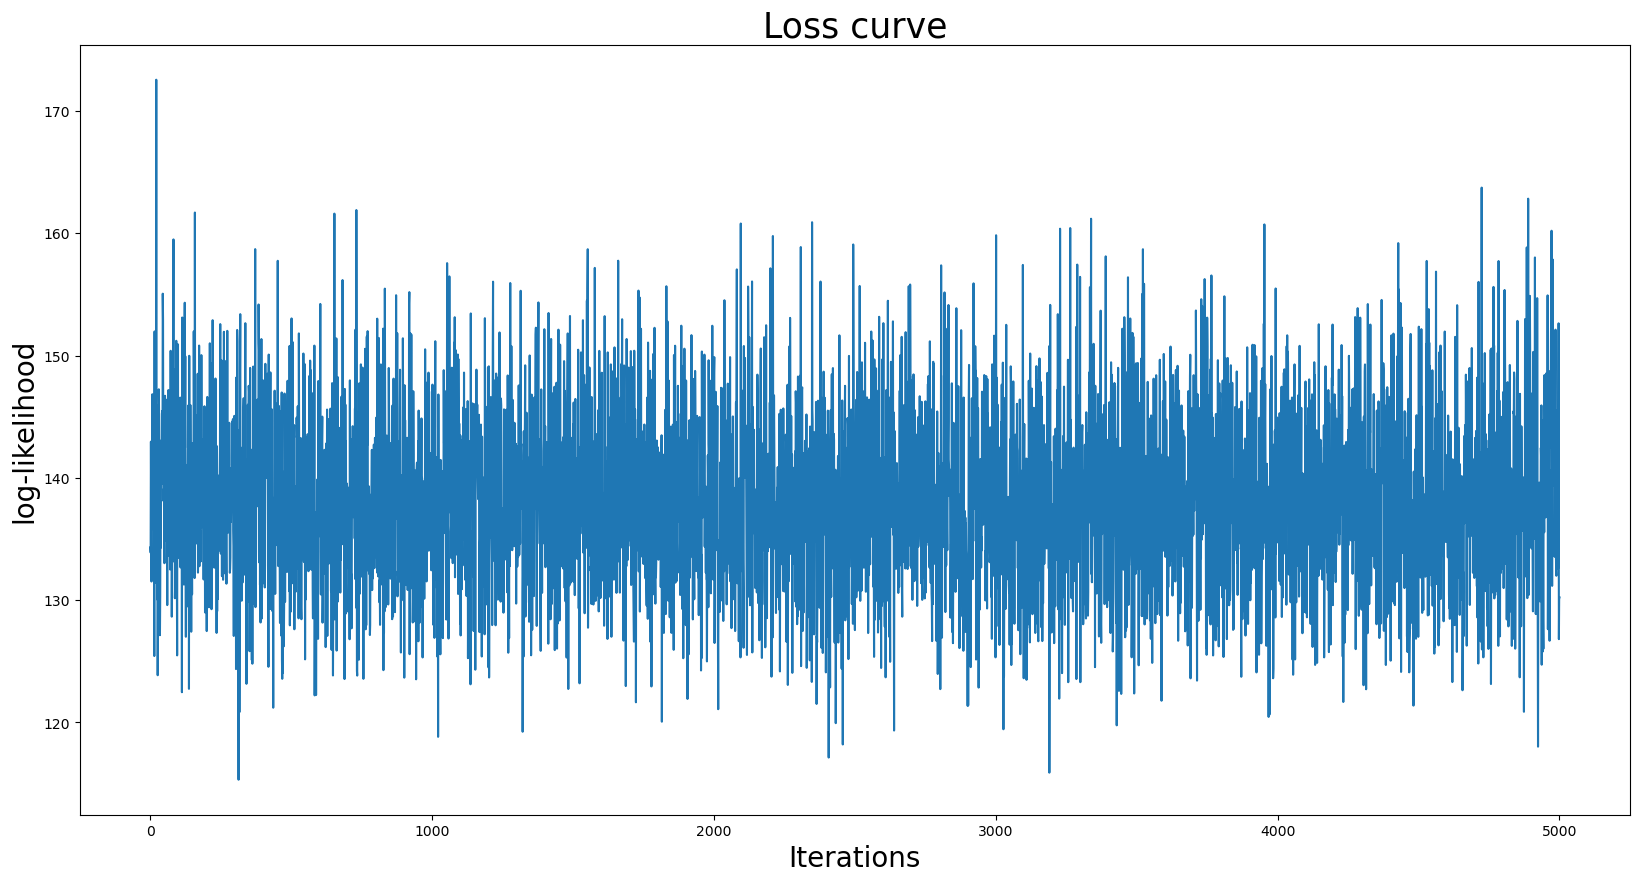

In [13]:
fig = plt.figure(figsize=(20, 10))
fig.patch.set_facecolor('xkcd:white')

plt.plot(list(map(lambda l: l.detach().numpy().ravel().ravel(), losses)))
plt.xlabel("Iterations", fontsize=20)
plt.ylabel("log-likelihood", fontsize=20)
plt.title("Loss curve", fontsize=25)
plt.show()

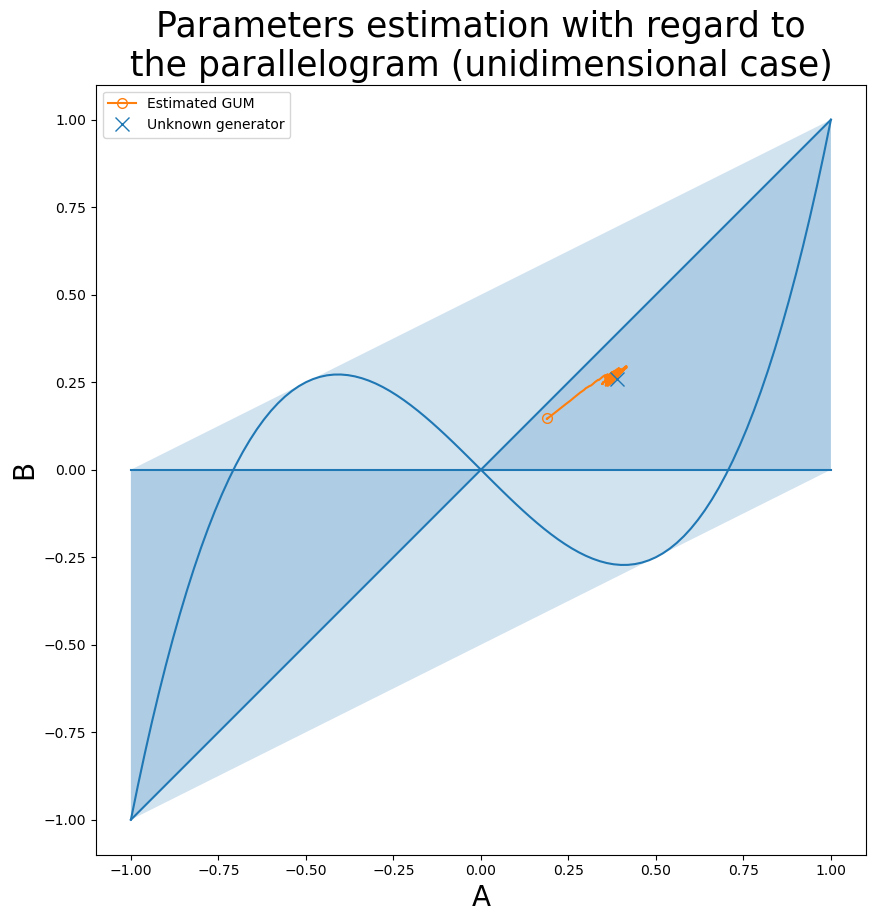

In [14]:
import matplotlib.patches as patches

fig = plt.figure(figsize=(10, 10)) 
fig.patch.set_facecolor('xkcd:white')
ax  = fig.add_subplot(111, aspect='equal')

# Parallelogram
x = [-1, -1, 1, 1]
y = [-1,  0, 1, 0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), facecolor="C0", alpha=.2))

# HMM
x = [0, 1, 1]
y = [0, 1, 0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), facecolor="C0", alpha=.2))

x = [0, -1, -1]
y = [0, -1,  0]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), facecolor="C0", alpha=.2))

# RNN
def f(a):
    return a * (2 * a**2 - 1)

n = 100
x = [-1 + 2 * (i / n) for i in range(n + 1)]
y = list(map(f, x))
ax.plot(x, y, color = "C0")
ax.plot(x, x, color = "C0")
ax.plot(x, [0 for _ in range(len(x))], color = "C0")


# Results
ax.plot(As, Bs, color="C1")

ax.plot([As[0]], [Bs[0]],
    marker="o", markersize=7, fillstyle="none", label="Estimated GUM", color="C1")

ax.plot(
    [unknown_gum.F.detach().numpy().ravel().ravel()], 
    [(unknown_gum.H @ unknown_gum.N).detach().numpy().ravel().ravel()],
    marker="x", markersize=10, label="Unknown generator", color="C0", linestyle="None"
)

# Show
ax.legend()
ax.set_xlabel("A", fontsize=20)
ax.set_ylabel("B", fontsize=20)
ax.set_title("Parameters estimation with regard to\nthe parallelogram (unidimensional case)", fontsize=25)
plt.show()